# 📘 Project Overview
This notebook contains the end-to-end process for identifying new mortgage prospects using machine learning techniques on retail banking data.

## Imports

## 1. Import Libraries

In [ ]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from ydata_profiling import ProfileReport

# Statistical analysis
from scipy.stats import chi2_contingency
from sklearn.feature_selection import mutual_info_classif

# Machine learning - model selection and preprocessing
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Machine learning - classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imbalanced data handling
from imblearn.pipeline import Pipeline as ImbPipeline

# Hyperparameter optimization
import optuna

# Model saving and utility
import json
import joblib

# Model explainability
import shap

# Set plotting size and style
sns.set(rc={'figure.figsize': (16, 8)})
sns.set_style("darkgrid")

# Warnings configuration
import warnings
warnings.filterwarnings('ignore')

## 2. Load & Preview Data

## Load Datasets

In [3]:
# Load the provided datasets
retail_df = pd.read_csv("../data/Retail data.csv", sep=";", decimal=",")
potential_df = pd.read_csv("../data/Potential Customers.csv", sep=";", decimal=",")

# Display the column information
retail_overview = {
    "info": retail_df.info()
}

potential_overview = {
    "info": potential_df.info()
}

(retail_df.shape, potential_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23983 entries, 0 to 23982
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Cocunut                 23983 non-null  int64  
 1   Mortgage_YN             23983 non-null  object 
 2   AGE_AT_ORIGINATION      306 non-null    float64
 3   AGE                     23983 non-null  int64  
 4   YEARS_WITH_BANK         23983 non-null  int64  
 5   MARTIAL_STATUS          23983 non-null  object 
 6   EDUCATION               23983 non-null  object 
 7   EMPLOYMENT              23983 non-null  object 
 8   GENDER                  23983 non-null  object 
 9   CUST_INCOME             23983 non-null  float64
 10  CURRENT_ADDRESS_DATE    23983 non-null  object 
 11  CURRENT_JOB_DATE        23983 non-null  object 
 12  CURRENT_WITH_BANK_DATE  23983 non-null  object 
 13  CURRENT_BALANCE_EUR     23983 non-null  float64
dtypes: float64(3), int64(3), object(8)
mem

((23983, 14), (2747, 12))

- Goal: Predict which customers in the potential dataset are likely to take a mortgage.

- Training Set (Retail data.csv): 23,983 samples with labels for Mortgage_YN.

- Prediction Set (Potential Customers.csv): 2,747 samples, almost same features  (except for AGE_AT_ORIGINATION) but no target label.

- Target Variable: Mortgage_YN (binary classification: has a mortgage or not).

**PREPROCESSING INSIGHTS**
1. Missing Values
AGE_AT_ORIGINATION in the retail dataset has only 306 non-null values → likely discarded during feature selection due to sparsity.

Other columns are complete, which is excellent for modeling.

2. Date Columns
Variables like CURRENT_ADDRESS_DATE, CURRENT_JOB_DATE, CURRENT_WITH_BANK_DATE are object type and will need to be transformed into numerical features (e.g., years since event).

3. Categorical Variables
Columns like MARTIAL_STATUS, EDUCATION, EMPLOYMENT, GENDER are object type → likely one-hot encoded or ordinal encoded.

These variables could hold socioeconomic insights tied to mortgage behavior.

## 3. Initial Data Cleaning & Preprocessing

In [4]:
# Clean column names
def clean_column_names(df):
    df.columns = (
        df.columns.str.strip()
        .str.replace('"', '', regex=False)
        .str.replace(" ", "_")
        .str.lower()
    )
    return df

retail_df = clean_column_names(retail_df)
potential_df = clean_column_names(potential_df)
retail_df.columns, potential_df.columns

(Index(['cocunut', 'mortgage_yn', 'age_at_origination', 'age',
        'years_with_bank', 'martial_status', 'education', 'employment',
        'gender', 'cust_income', 'current_address_date', 'current_job_date',
        'current_with_bank_date', 'current_balance_eur'],
       dtype='object'),
 Index(['cocunut', 'age', 'years_with_bank', 'martial_status', 'education',
        'employment', 'gender', 'cust_income', 'current_address_date',
        'current_job_date', 'current_with_bank_date', 'current_balance_eur'],
       dtype='object'))

In [5]:
# Replace the 'martial_status' with 'marital_status'
retail_df = retail_df.rename(columns={'martial_status': 'marital_status'})
potential_df = potential_df.rename(columns={'martial_status': 'marital_status'})

In [6]:
# Preview retail_df
retail_df.head()

cocunut mortgage_yn  age_at_origination  age  years_with_bank  \
0        1           Y                50.0   52               13   
1        9           Y                48.0   49               11   
2       11           Y                53.0   55               14   
3       12           Y                64.0   66               10   
4       18           Y                46.0   47                9   

  marital_status education employment gender  cust_income  \
0              M       HGH        PVE      M   909.501308   
1              M       HGH        SFE      M   288.461539   
2              M       BCR        STE      M  1280.528692   
3              M       BCR        OTH      F   620.959769   
4              S       MAS        PVE      F  2239.853846   

  current_address_date current_job_date current_with_bank_date  \
0           1979-04-18       2010-01-01             2004-03-16   
1           1999-12-16       2004-01-20             2005-11-07   
2           2005-06-28       1990-09-01             2003-06-25   
3           2000-12-22       9999-10-01             2006-12-21   
4           2009-08-01       2013-12-24             2007-08-07   

   current_balance_eur  
0          7648.350692  
1         30189.904920  
2         50553.174540  
3         15907.283380  
4         27916.192620

In [7]:
# Preview potential_df
potential_df.head()

cocunut  age  years_with_bank marital_status education employment gender  \
0    80001   32                3              M       HGH        PVE      M   
1    80002   51               10              W       SEC        RET      F   
2    80003   36                7              M       BCR        STE      F   
3    80004   46               11              D       BCR        TEA      F   
4    80005   39               10              M       HGH        PVE      M   

   cust_income current_address_date current_job_date current_with_bank_date  \
0   423.076923           1985-01-21       2005-01-01             2014-07-02   
1   140.610231           2010-10-23       9999-10-01             2007-02-21   
2   326.923077           1981-10-16       2009-09-10             2009-10-26   
3   738.820000           2008-09-01       2005-11-01             2005-11-30   
4   483.928231           1993-09-01       2013-06-01             2006-12-05   

   current_balance_eur  
0           143.000000  
1          2288.700154  
2          2268.491692  
3          4536.983462  
4          3076.923077

## 4. Exploratory Data Analysis (EDA)

In [8]:
# Descriptive statistics of retail_df
retail_df.describe(include='all').T

count unique         top   freq          mean  \
cocunut                 23983.0    NaN         NaN    NaN  39969.697786   
mortgage_yn               23983      2           N  23677           NaN   
age_at_origination        306.0    NaN         NaN    NaN     41.333333   
age                     23983.0    NaN         NaN    NaN     49.004378   
years_with_bank         23983.0    NaN         NaN    NaN      7.370804   
marital_status            23983      5           M  17024           NaN   
education                 23983      8         HGH  15987           NaN   
employment                23983      5         PVE  10743           NaN   
gender                    23983      2           F  12105           NaN   
cust_income             23983.0    NaN         NaN    NaN    381.512485   
current_address_date      23983   9000  2000-01-01    370           NaN   
current_job_date          23983   5645  9999-10-01   5771           NaN   
current_with_bank_date    23983   4142  2005-07-26     47           NaN   
current_balance_eur     23983.0    NaN         NaN    NaN   1960.854473   

                                 std   min         25%         50%  \
cocunut                 22996.273034   1.0     20076.0     40066.0   
mortgage_yn                      NaN   NaN         NaN         NaN   
age_at_origination          8.970992  22.0        35.0        40.0   
age                        12.976205  20.0        39.0        49.0   
years_with_bank             4.320568   0.0         3.0         9.0   
marital_status                   NaN   NaN         NaN         NaN   
education                        NaN   NaN         NaN         NaN   
employment                       NaN   NaN         NaN         NaN   
gender                           NaN   NaN         NaN         NaN   
cust_income               486.255438   0.0  212.304538  287.355692   
current_address_date             NaN   NaN         NaN         NaN   
current_job_date                 NaN   NaN         NaN         NaN   
current_with_bank_date           NaN   NaN         NaN         NaN   
current_balance_eur      5023.234656   0.0  107.677577     428.067   

                                75%          max  
cocunut                     59778.0      79998.0  
mortgage_yn                     NaN          NaN  
age_at_origination            47.75         64.0  
age                            60.0         92.0  
years_with_bank                11.0         40.0  
marital_status                  NaN          NaN  
education                       NaN          NaN  
employment                      NaN          NaN  
gender                          NaN          NaN  
cust_income              406.100269     25741.92  
current_address_date            NaN          NaN  
current_job_date                NaN          NaN  
current_with_bank_date          NaN          NaN  
current_balance_eur     2307.692308  187940.6455

- cocunut (Customer ID)
Range: 1 – 79,998

Used only as an identifier — not predictive.

- age_at_origination
Available only for 306 customers → Same count as mortgage "Yes" → possibly a leak feature.

Mean age at loan start: 41.3 years

Suggests people tend to get mortgages in their late 30s to early 40s.

-  age
Mean: 49 years, Std: ~13

Range: 20 to 92 years

Median (50%): 49, indicating a symmetric distribution.

Interpretation:

Majority of bank customers are middle-aged.

Since mortgage origination tends to happen earlier (~41), younger segments are of interest for targeting.

- years_with_bank
Mean: 7.37 years, Max: 40 years

25% of customers have been with the bank for <3 years.

75% have been with the bank for 11+ years.

Interpretation:

Longer tenure correlates with trust and mortgage eligibility.

Consideration on focusing CRM strategies on customers with >5 years tenure.

- marital_status
5 unique categories; "M" (married) dominates with 17,024 (~71%)

May reflect greater financial stability or dual incomes → higher likelihood for mortgage.

- education
8 unique categories; "HGH" (likely High School or Higher Education) is most frequent with 15,987

Education often aligns with income and employment, which are mortgage indicators.

- employment
5 types; "PVE" (Private Employment?) most common (~45%)

This feature captures job type variability which can inform stability and income level.

- gender
Fairly balanced: F: 12,105, M: 11,878

Could help refine CRM segmentation if gender-specific behavior trends are found.

- cust_income
Mean: €381, but highly skewed — Max: €25,741

25% earn < €212, and 75% earn < €406

Interpretation:

A large portion of the customer base earns less than €400/month — indicating low purchasing power.

Mortgage holders likely skew to upper quartile income.

- Date Columns (current_address_date, current_job_date, current_with_bank_date)
Many unique values, suggesting strong granularity.

Most common:

current_address_date: 2000-01-01

current_job_date: 9999-10-01 → likely placeholder for missing.

current_with_bank_date: 2005-07-26

- current_balance_eur
Mean: €1,960 — very skewed (Max: €187,940)

Median: €428 → again shows skewness

Interpretation:

High balance customers represent key leads.

CRM campaigns can target customers in top quartile for financial products like mortgages.

In [9]:
# Descriptive statistics of potential_df
potential_df.describe(include='all').T

count unique         top  freq         mean  \
cocunut                 2747.0    NaN         NaN   NaN      81374.0   
age                     2747.0    NaN         NaN   NaN    48.736804   
years_with_bank         2747.0    NaN         NaN   NaN     6.991263   
marital_status            2747      5           M  1898          NaN   
education                 2747      8         HGH  1872          NaN   
employment                2747      6         PVE  1186          NaN   
gender                    2747      2           M  1379          NaN   
cust_income             2747.0    NaN         NaN   NaN   368.593527   
current_address_date      2747   1675  9999-10-01    61          NaN   
current_job_date          2747   1284  9999-10-01   711          NaN   
current_with_bank_date    2747   1752  2016-10-11    28          NaN   
current_balance_eur     2747.0    NaN         NaN   NaN  3122.632321   

                                std      min          25%          50%  \
cocunut                  793.134919  80001.0      80687.5      81374.0   
age                       13.186774     21.0         38.0         49.0   
years_with_bank            4.522815      0.0          3.0          8.0   
marital_status                  NaN      NaN          NaN          NaN   
education                       NaN      NaN          NaN          NaN   
employment                      NaN      NaN          NaN          NaN   
gender                          NaN      NaN          NaN          NaN   
cust_income              333.434057      0.0   214.624769   292.307692   
current_address_date            NaN      NaN          NaN          NaN   
current_job_date                NaN      NaN          NaN          NaN   
current_with_bank_date          NaN      NaN          NaN          NaN   
current_balance_eur     2447.362072      0.0  1274.979385  2307.692308   

                                75%          max  
cocunut                     82060.5      82747.0  
age                            60.0         74.0  
years_with_bank                11.0         15.0  
marital_status                  NaN          NaN  
education                       NaN          NaN  
employment                      NaN          NaN  
gender                          NaN          NaN  
cust_income              410.403462  7978.961538  
current_address_date            NaN          NaN  
current_job_date                NaN          NaN  
current_with_bank_date          NaN          NaN  
current_balance_eur     4615.384615  18176.99415

1. age
Metric	Retail (mortgage_yn)	Potential
Mean	49.0	48.7
Std	13.0	13.2
Range	20–92	21–74
Median (50%)	49	49
Insight:
→ Very similar age distribution. No domain shift here. Potential customers match the age profile of current customers, including those who took mortgages.

2. years_with_bank
Metric	Retail	Potential
Mean	7.37	6.99
Median	9	8
Max	40	15
Insight:
→ Potential customers tend to have shorter tenures. 

3. marital_status
Most Common	Retail	Potential
Top Value	M (17,024)	M (1,898)
% Married	~71%	~69%
Insight:
→ Distribution is consistent. Married status continues to dominate, which could indicate stable income and better mortgage prospects.

4. education
Top Value	Retail	Potential
HGH	15,987	1,872
% HGH	~67%	~68%
Insight:
→ Education profiles are well-aligned. Suggests comparable socioeconomic segments in both groups.

5. employment
Top Value	Retail	Potential
PVE	10,743	1,186
Unique	5	6
Insight:
→ Similar employment breakdown. But potential dataset has 1 extra category, worth checking for unseen category during inference. 

6. gender
Distribution	Retail	Potential
F / M	~50.5% / ~49.5%	49.8% / 50.2%
Insight:
→ Well balanced in both datasets.

7. cust_income
Metric	Retail	Potential
Mean	€381.51	€368.59
Std	€486.26	€333.43
Max	€25,742	€7,979
75th %ile	€406.10	€410.40
Insight:
→ Average incomes are similar, but potential customers lack high-end earners (max is 3x lower).
→ Suggests they may be slightly less affluent on average, but still aligned in distribution.

8. current_balance_eur
Metric	Retail	Potential
Mean	€1,961	€3,123
Median	€428	€2,308
Max	€187,940	€18,177
Insight:
→ Potential customers have much higher balances on average despite lower max values.
→ This is a huge positive signal. Higher liquidity could mean readiness for mortgage acquisition.

9. Dates (e.g., current_job_date)
9999-10-01 is again a placeholder, needs to be handled as missing.

In [10]:
# Date columns to search
date_cols = ["current_address_date", "current_job_date", "current_with_bank_date"]

# Count occurrences of '9999-10-01'
retail_9999_counts = {col: retail_df[col].str.strip().eq("9999-10-01").sum() for col in date_cols}
potential_9999_counts = {col: potential_df[col].str.strip().eq("9999-10-01").sum() for col in date_cols}

(retail_9999_counts, potential_9999_counts)

({'current_address_date': 194,
  'current_job_date': 5771,
  'current_with_bank_date': 0},
 {'current_address_date': 61,
  'current_job_date': 711,
  'current_with_bank_date': 0})

- **current_with_bank_date**: 0 placeholder values

This is excellent — means years_with_bank is 100% trustworthy.

- **current_address_date**: 194 (Retail), 61 (Potential)

Roughly 0.8% of retail_df and 2.2% of potential_df entries are placeholders.

- **current_job_date**: 5,771 (Retail), 711 (Potential)

This is the big one:

~24% of retail data

~25% of potential data

This likely reflects missing job start date data, which can drastically skew job_stability_years.

In [11]:
def convert_to_datetime(df, columns):
    for col in columns:
        try:
            df[col] = pd.to_datetime(df[col])
            print(f"Converted '{col}' to datetime.")
        except Exception as e:
            print(f"Failed to convert '{col}' to datetime: {e}")
    return df

# Call the function
retail_df = convert_to_datetime(retail_df, ["current_with_bank_date"])

# Call the function
potential_df = convert_to_datetime(potential_df, ["current_with_bank_date"])

Converted 'current_with_bank_date' to datetime.
Converted 'current_with_bank_date' to datetime.


In [12]:
# Convert and clean additional date fields
for col in ["current_address_date", "current_job_date"]:
    retail_df[col] = pd.to_datetime(retail_df[col].replace("9999-10-01", pd.NaT), errors="coerce")
    potential_df[col] = pd.to_datetime(potential_df[col].replace("9999-10-01", pd.NaT), errors="coerce")

In [13]:
retail_df["current_address_date"].isna().sum(), potential_df["current_address_date"].isna().sum()

(194, 61)

In [14]:
retail_df["current_job_date"].isna().sum(), potential_df["current_job_date"].isna().sum()

(5771, 711)

In [15]:
retail_df["current_job_date"].head()

0   2010-01-01
1   2004-01-20
2   1990-09-01
3          NaT
4   2013-12-24
Name: current_job_date, dtype: datetime64[ns]

In [16]:
retail_df[["current_with_bank_date", "current_job_date", "current_address_date"]].agg(["min", "max", "nunique", "count"])


current_with_bank_date     current_job_date current_address_date
min        1976-07-17 00:00:00  1970-01-21 00:00:00  1925-04-04 00:00:00
max        2016-10-05 00:00:00  2016-10-02 00:00:00  2049-12-16 00:00:00
nunique                   4142                 5644                 8999
count                    23983                18212                23789

- **current_with_bank_date**

100% valid data (no missing).

Reasonable range from 1976–2016.


- **current_job_date**

~24% missing (i.e., 5,771 nulls).

Date range is valid (1970–2016).

High number of unique values (5,644 out of 18,212 non-null).

Interpretation:

Job history is available for the majority.

High cardinality → fine for converting to a duration feature (job_stability_years).

- **current_address_date**

Only 194 missing values → minor issue.

Max value: 2049-12-16 → this is clearly invalid (in the future).

We will clip the range.

In [17]:
potential_df[["current_with_bank_date", "current_job_date", "current_address_date"]].agg(["min", "max", "nunique", "count"])

current_with_bank_date     current_job_date current_address_date
min        2001-09-11 00:00:00  1974-01-08 00:00:00  1944-08-10 00:00:00
max        2016-10-19 00:00:00  2016-10-12 00:00:00  2016-04-01 00:00:00
nunique                   1752                 1283                 1674
count                     2747                 2036                 2686

- **current_with_bank_date**

Complete and has realistic dates.

Time range: 2001 to 2016 → aligns well with training data.

- **current_job_date**

~26% missing → consistent with retail_df.

Range is plausible (1974–2016).

- **current_address_date**

Only ~2.2% missing.

Min value: 1944 → might indicate data entry error or long-time residence.

## 5. Feature Engineering

In [18]:
# Calculate the most recent date of the date column of the bank
today = retail_df["current_with_bank_date"].max()
today

Timestamp('2016-10-05 00:00:00')

In [19]:
# Convert the extreme futuristic dates to null
retail_df["current_address_date"] = retail_df["current_address_date"].apply(
    lambda x: x if pd.isna(x) or x <= today else pd.NaT
)

In [20]:
retail_df[["current_with_bank_date", "current_job_date", "current_address_date"]].agg(["min", "max", "nunique", "count"])

current_with_bank_date     current_job_date current_address_date
min        1976-07-17 00:00:00  1970-01-21 00:00:00  1925-04-04 00:00:00
max        2016-10-05 00:00:00  2016-10-02 00:00:00  2016-08-26 00:00:00
nunique                   4142                 5644                 8986
count                    23983                18212                23775

In [21]:
# Create derived features for both datasets
retail_df["job_stability_years"] = (today - pd.to_datetime(retail_df["current_job_date"], errors="coerce")).dt.days / 365
retail_df["address_stability_years"] = (today - pd.to_datetime(retail_df["current_address_date"], errors="coerce")).dt.days / 365

# Add missing flags
retail_df["job_stability_missing"] = retail_df["job_stability_years"].isna().astype(int)
retail_df["address_stability_missing"] = retail_df["address_stability_years"].isna().astype(int)

# Impute missing values with medians from the training data
job_median = retail_df["job_stability_years"].median()
address_median = retail_df["address_stability_years"].median()

retail_df["job_stability_years"] = retail_df["job_stability_years"].fillna(job_median)
retail_df["address_stability_years"] = retail_df["address_stability_years"].fillna(address_median)

In [22]:
job_median, address_median

(8.73150684931507, 23.224657534246575)

In [23]:
# Convert to datetime and nullify future dates
potential_df["current_address_date"] = pd.to_datetime(potential_df["current_address_date"], errors="coerce")
potential_df.loc[potential_df["current_address_date"] > today, "current_address_date"] = pd.NaT

# Create engineered features
potential_df["job_stability_years"] = (today - pd.to_datetime(potential_df["current_job_date"], errors="coerce")).dt.days / 365
potential_df["address_stability_years"] = (today - potential_df["current_address_date"]).dt.days / 365

# Create flags
potential_df["job_stability_missing"] = potential_df["job_stability_years"].isna().astype(int)
potential_df["address_stability_missing"] = potential_df["address_stability_years"].isna().astype(int)

# Impute using training set medians
potential_df["job_stability_years"] = potential_df["job_stability_years"].fillna(job_median)
potential_df["address_stability_years"] = potential_df["address_stability_years"].fillna(address_median)

In [24]:
# Recheck missing flags
missing_flags_retail = retail_df[["job_stability_missing", "address_stability_missing"]].sum()
missing_flags_potential = potential_df[["job_stability_missing", "address_stability_missing"]].sum()

(missing_flags_retail, missing_flags_potential)

(job_stability_missing        5771
 address_stability_missing     208
 dtype: int64,
 job_stability_missing        711
 address_stability_missing     61
 dtype: int64)

- These flags accurately reflect the original missing values in the engineered features before imputation.

This is extremely useful for:

- Tree-based models (they can learn from missing-ness itself).

In [25]:
# Drop the original date columns
retail_df.drop(columns=["current_job_date", "current_address_date"], inplace=True)
potential_df.drop(columns=["current_job_date", "current_address_date"], inplace=True)

In [26]:
retail_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23983 entries, 0 to 23982
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   cocunut                    23983 non-null  int64         
 1   mortgage_yn                23983 non-null  object        
 2   age_at_origination         306 non-null    float64       
 3   age                        23983 non-null  int64         
 4   years_with_bank            23983 non-null  int64         
 5   marital_status             23983 non-null  object        
 6   education                  23983 non-null  object        
 7   employment                 23983 non-null  object        
 8   gender                     23983 non-null  object        
 9   cust_income                23983 non-null  float64       
 10  current_with_bank_date     23983 non-null  datetime64[ns]
 11  current_balance_eur        23983 non-null  float64       
 12  job_

In [27]:
retail_df["job_stability_missing"].value_counts()

job_stability_missing
0    18212
1     5771
Name: count, dtype: int64

In [28]:
retail_df["address_stability_missing"].value_counts()

address_stability_missing
0    23775
1      208
Name: count, dtype: int64

In [29]:
# Define a function to find common columns
def find_common_columns(df1, df2):
    common_cols = df1.columns.intersection(df2.columns)
    print("Common Columns:")
    return list(common_cols)

common_columns = find_common_columns(retail_df, potential_df)
print(common_columns)
print("\nNumber of Common Columns:", len(common_columns))

Common Columns:
['cocunut', 'age', 'years_with_bank', 'marital_status', 'education', 'employment', 'gender', 'cust_income', 'current_with_bank_date', 'current_balance_eur', 'job_stability_years', 'address_stability_years', 'job_stability_missing', 'address_stability_missing']

Number of Common Columns: 14


In [30]:
# Define a function to check data quality
def check_data_quality(df, name="DataFrame"):
    print(f"--- Data Quality Report for: {name} ---\n")
    print("Rows           :", df.shape[0])
    print("Columns        :", df.shape[1])
    print("\nFeatures       :", df.columns.tolist())
    print("\nMissing Values :", df.isnull().sum().values.sum())
    print("Duplicates     :", df.duplicated().sum())
    print("\nUnique Values  :\n", df.nunique())
    print("\nMemory Usage   : %.2f MB" % (df.memory_usage().sum() / 1024**2))
    print("\n--- End of Report ---")

In [31]:
# Check data quality for retail_df
check_data_quality(retail_df, name="retail_df")

# Check data quality for potential_df
check_data_quality(potential_df, name="potential_df")

--- Data Quality Report for: retail_df ---

Rows           : 23983
Columns        : 16

Features       : ['cocunut', 'mortgage_yn', 'age_at_origination', 'age', 'years_with_bank', 'marital_status', 'education', 'employment', 'gender', 'cust_income', 'current_with_bank_date', 'current_balance_eur', 'job_stability_years', 'address_stability_years', 'job_stability_missing', 'address_stability_missing']

Missing Values : 23677
Duplicates     : 0

Unique Values  :
 cocunut                      23983
mortgage_yn                      2
age_at_origination              41
age                             73
years_with_bank                 18
marital_status                   5
education                        8
employment                       5
gender                           2
cust_income                  18823
current_with_bank_date        4142
current_balance_eur          18415
job_stability_years           5644
address_stability_years       8986
job_stability_missing            2
address_st

In [32]:
# Function for missing values
def missing_value_summary(data):
    # Calculate the number of missing values and their percentage
    missing_value = data.isnull().sum().reset_index()
    missing_value.columns = ['Variable', 'Number of Missing']
    missing_value['Percentage of Missing'] = (missing_value['Number of Missing'] / data.shape[0] * 100).round(2)

    # Sort the summary by the percentage of missing values in descending order
    missing_value = missing_value.sort_values(by='Percentage of Missing', ascending=False).reset_index(drop=True)

    return missing_value

# Check missing values for retail_df
missing_value_summary(retail_df)

Variable  Number of Missing  Percentage of Missing
0          age_at_origination              23677                  98.72
1                     cocunut                  0                   0.00
2                 mortgage_yn                  0                   0.00
3                         age                  0                   0.00
4             years_with_bank                  0                   0.00
5              marital_status                  0                   0.00
6                   education                  0                   0.00
7                  employment                  0                   0.00
8                      gender                  0                   0.00
9                 cust_income                  0                   0.00
10     current_with_bank_date                  0                   0.00
11        current_balance_eur                  0                   0.00
12        job_stability_years                  0                   0.00
13    address_stability_years                  0                   0.00
14      job_stability_missing                  0                   0.00
15  address_stability_missing                  0                   0.00

In [33]:
# Check values for target variable
retail_df.mortgage_yn.value_counts()

mortgage_yn
N    23677
Y      306
Name: count, dtype: int64

In [34]:
# Check correlation between mortgage_yn and age_at_origination_missing missingness
retail_df["age_at_origination_missing"] = retail_df["age_at_origination"].isna()
missing_mortgage_ct = pd.crosstab(retail_df["mortgage_yn"], retail_df["age_at_origination_missing"])

missing_mortgage_ct

age_at_origination_missing  False  True 
mortgage_yn                             
N                               0  23677
Y                             306      0

**Interpretation**:

"age_at_origination" is only present for customers who already have a mortgage.

It's completely missing for those who don’t.

So, its absence isn’t random — it reflects conditional availability based on the target variable.

Evaluated the 'age_at_origination' feature, but since it had over 98% missing values and wasn’t available for potential customers, it will be excluded from modeling.

**Why We Drop It**:

Even though it holds meaning:

  - It leaks target information (it's only known after a customer takes a mortgage)

  - It's not available for future/potential customers

  - Including it would bias the model and invalidate predictions

In [35]:
# Drop 'age_at_origination' column
retail_df = retail_df.drop(columns=['age_at_origination', 'age_at_origination_missing'])
retail_df.columns

Index(['cocunut', 'mortgage_yn', 'age', 'years_with_bank', 'marital_status',
       'education', 'employment', 'gender', 'cust_income',
       'current_with_bank_date', 'current_balance_eur', 'job_stability_years',
       'address_stability_years', 'job_stability_missing',
       'address_stability_missing'],
      dtype='object')

In [36]:
# Plot distributions for numerical features
def plot_distributions(data, features):
    for feature in features:
        plt.figure(figsize=(8, 5))
        sns.histplot(data[feature], kde=True, bins=30)
        plt.title(f"Distribution of {feature}")
        plt.xlabel(feature)
        plt.ylabel("Frequency")
        plt.show()

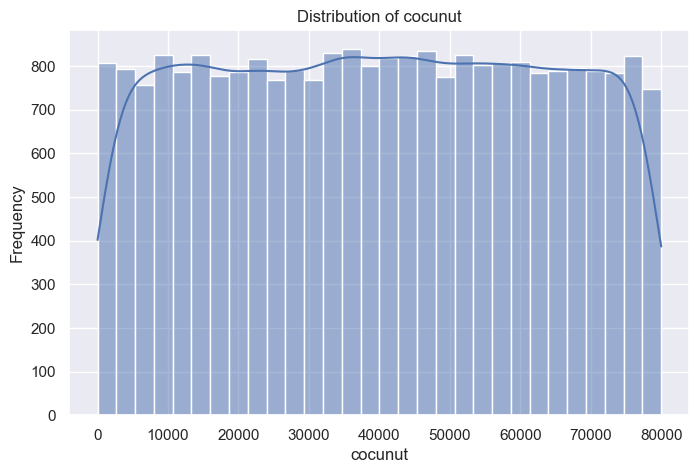

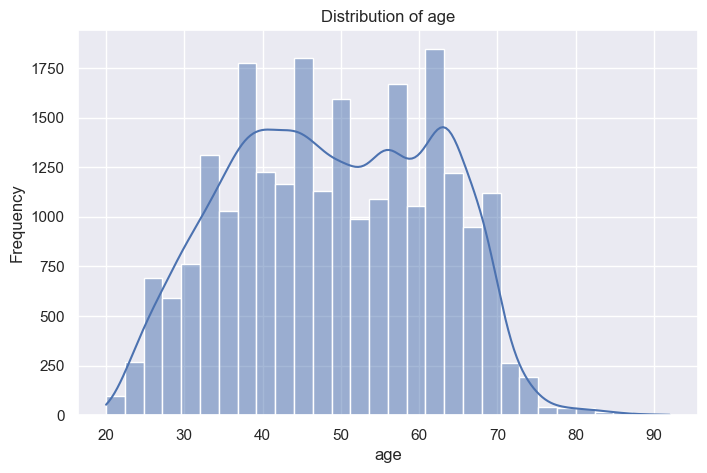

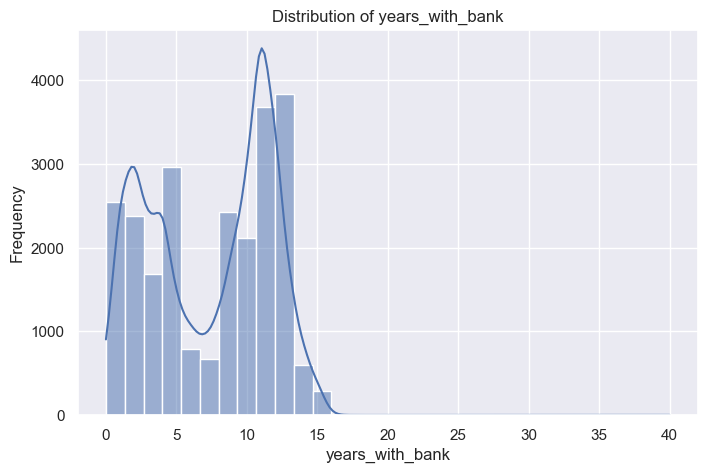

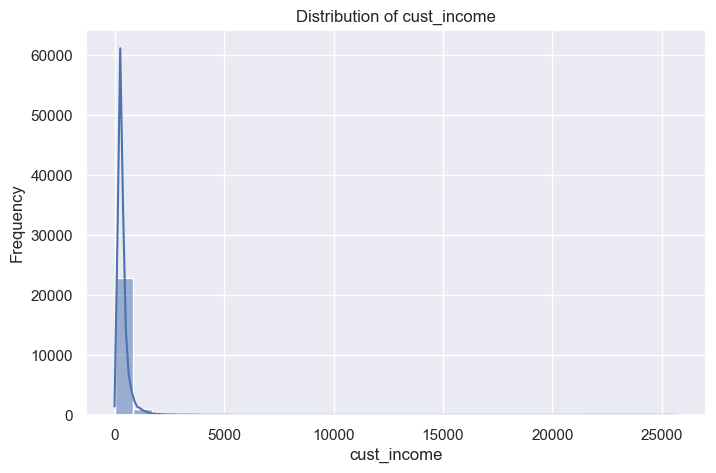

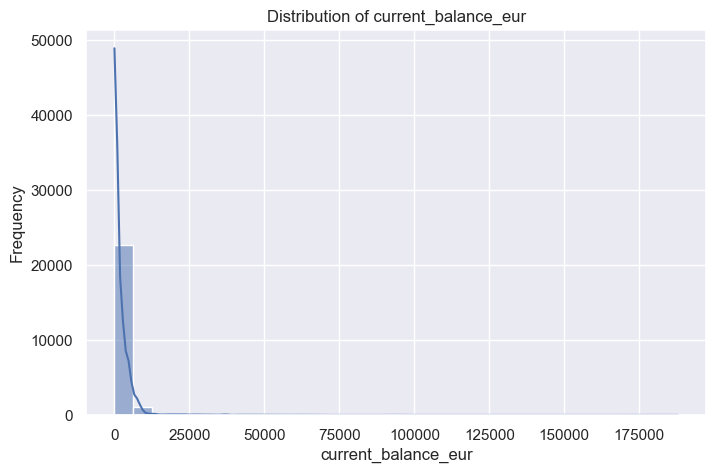

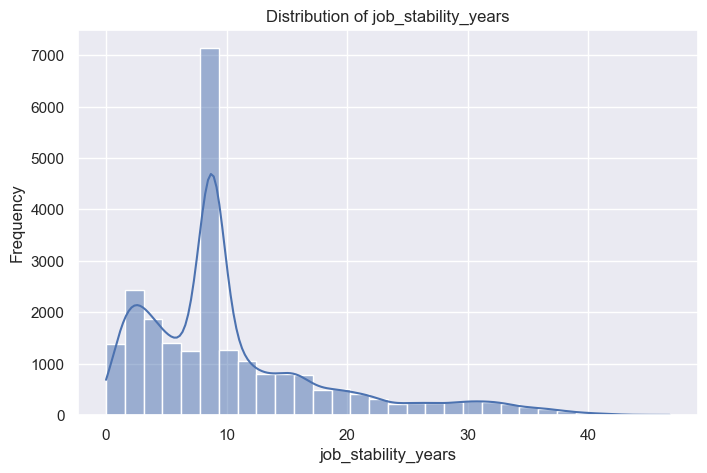

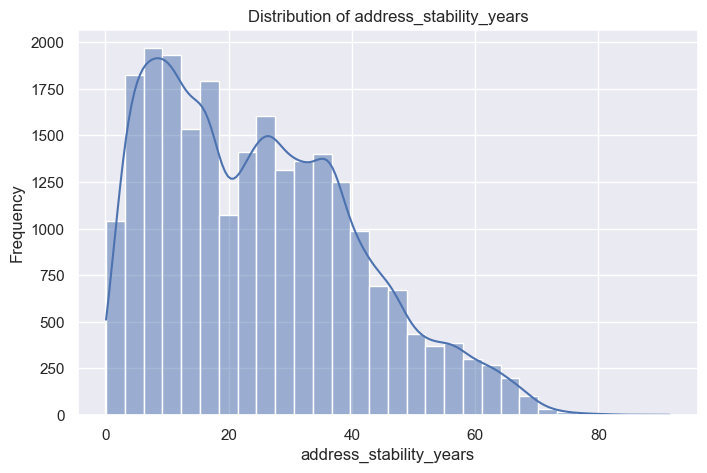

In [37]:
# Select numerical features for visualization
numerical_features = retail_df.select_dtypes(include=['int64', 'float64']).columns

# Plot the distributions
plot_distributions(retail_df, numerical_features)

1. **Distribution of Age**

Most customers fall between 30 and 65.

Bimodal-like shape with peaks around 40 and 60.

Very few customers are older than 75 or younger than 30.

This is an age group that aligns well with mortgage targeting — prime earning years and pre-retirement.

Younger segments (20–30) are underrepresented, which may reflect bank clientele, but could also hint at an untapped market.

2. **Distribution of Years with Bank**

Bimodal distribution:

A cluster near 0–2 years: new customers

Another peak at 10–12 years

Steep drop-off after 15 years.

There's a split between newer clients and long-term loyal customers.

The second group could represent an ideal base for upselling mortgages.

The first group (0–2 years) may need more nurturing or credit scoring before they can be approached.

3. **Distribution of Customer Income**

Highly right-skewed (long tail).

Majority earn under €1,000, most under €500.

Outliers go up to €25,000.

Extreme inequality in income distribution.

High-income individuals are rare but may be high-value leads for premium mortgage products.

4. **Distribution of Current Balance (EUR)**

Also heavily right-skewed.

Most customers have balances under €5,000.

A few extreme outliers go up to €180,000+.

High balances may be strong indicators of creditworthiness or savings readiness for a mortgage.

5. **Distribution of Job Stability (Years)**

Peak at around 8–9 years, then sharp decline.

Long tail extends to 40+ years.

Smaller peak around 1–2 years → possibly newer professionals.

Two key customer segments:

Long-term employed → more stable, mortgage-eligible.

New workforce entrants → lower eligibility but future potential.

Job stability is likely a highly predictive feature in the model.

6. **Distribution of Address Stability (Years)**

Very broad distribution.

Peaks in the first 10 years, then gradually tapers off.

Some customers have lived at their address for 80+ years (possible data anomalies or very old individuals).

Long-term residence implies credit and life stability.

Very high address stability may correlate with older, risk-averse individuals.

This could be important for segmenting high-trust, low-risk mortgage prospects.

In [38]:
# Bar plot for categorical features
def plot_categorical_distribution(data, feature):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature, data=data)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

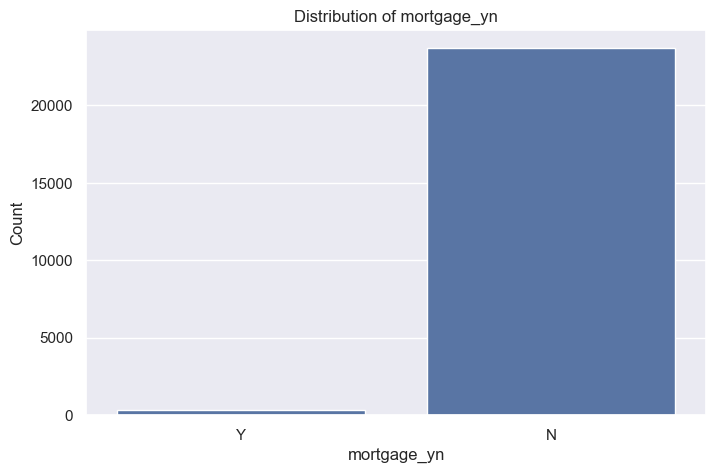

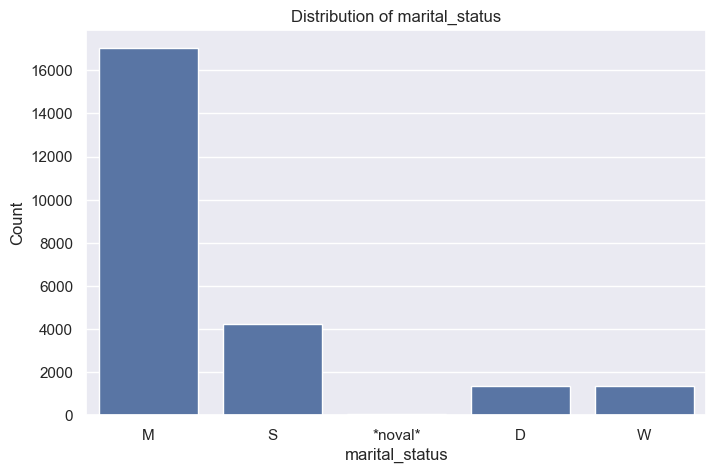

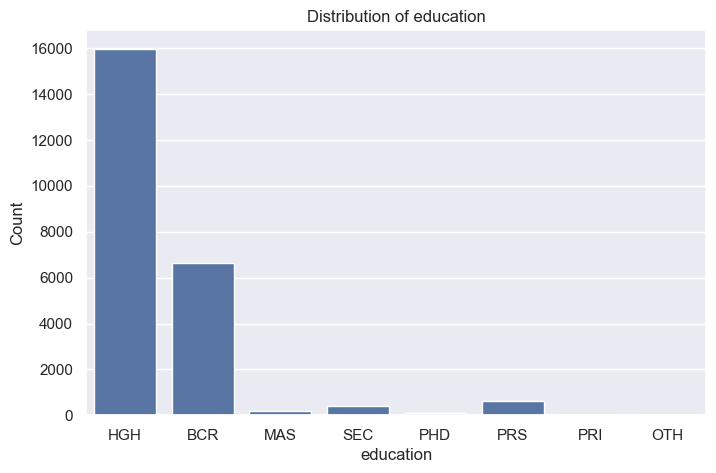

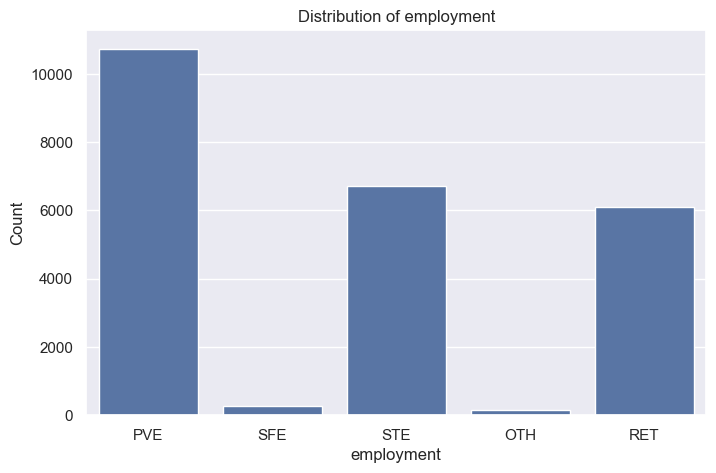

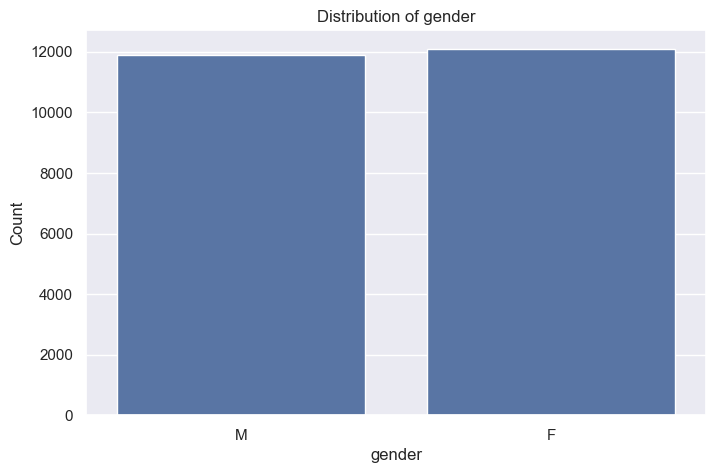

In [39]:
# Plot categorical features
categorical_features = retail_df.select_dtypes(include=['object']).columns

for feature in categorical_features:
    plot_categorical_distribution(retail_df, feature)

1. **Distribution of mortgage_yn**

Class imbalance is severe.

Vast majority of samples are labeled "N" (no mortgage).

Only a tiny fraction has a mortgage ("Y").

This confirms the earlier stat: only ~1.27% of retail customers have mortgages.

Critical for modeling → Requires:

Resampling techniques (e.g., SMOTE)

Careful metric selection (e.g., Precision-Recall AUC, ROC-AUC)

2. **Distribution of marital_status**

Most common: M (Married) — by a huge margin.

Then: S (Single), followed by D (Divorced), W (Widowed), and a few entries labeled *noval*.

Married individuals dominate the customer base.

Could indicate stability → potential indicator for creditworthiness.

*noval* is likely a placeholder → can be imputed.

3. **Distribution of education**

Top level: HGH (likely High School or Higher General).

Followed by BCR (Bachelor).

Rest (MAS, SEC, PHD, etc.) are minor.

Education is concentrated in mid-level qualifications.

4. **Distribution of employment**

Most common: PVE (Private Sector Employment).

Then STE (State Employment) and RET (Retired).

Smaller categories: SFE (Self-employed) and OTH.

Strong representation from working professionals (private and state sectors).

5. **Distribution of gender**

Near-perfect balance between M and F.

Gender won’t drive model bias but can still contribute subtle patterns in behavior or preferences.

In [40]:
retail_df["marital_status"].value_counts()

marital_status
M          17024
S           4223
D           1364
W           1329
*noval*       43
Name: count, dtype: int64

Rather than dropping or replacing the *noval* entries in marital_status, we train a HistGradientBoostingClassifier to impute the missing values using other customer attributes (e.g., income, education, employment). This preserves natural category distributions and adds modeling robustness.

In [41]:
# Use HistGradientBoostingClassifier for imputation
# Prepare training data (marital_status != '*noval*')
df = retail_df.copy()
df["marital_status_knn"] = df["marital_status"].replace("*noval*", np.nan)

# Define feature columns
numerical_cols = ["age", "cust_income", "current_balance_eur", "years_with_bank"]
categorical_cols = ["gender", "employment", "education"]

# Encode categorical target (keep original labels)
train_df = df[df["marital_status_knn"].notna()]
X_train = train_df[numerical_cols + categorical_cols]
y_train = train_df["marital_status_knn"]

# Use one-hot encoding only for 'gender', 'employment', 'education'
X_train = pd.get_dummies(X_train, drop_first=True)

# Train the classifier
hgb = HistGradientBoostingClassifier(random_state=42)
hgb.fit(X_train, y_train)

# Prepare test data (only *noval* rows)
noval_df = df[df["marital_status"] == "*noval*"]
X_test = noval_df[numerical_cols + categorical_cols]
X_test = pd.get_dummies(X_test, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=np.nan)

# Predict and update
predicted = hgb.predict(X_test)
retail_df.loc[noval_df.index, "marital_status"] = predicted

# Show updated counts
retail_df["marital_status"].value_counts()

marital_status
M    17061
S     4227
D     1364
W     1331
Name: count, dtype: int64

In [42]:
# Doing the same for potential_df
# Copy and isolate the *noval* entries
pot_df = potential_df.copy()
pot_df["marital_status_knn"] = pot_df["marital_status"].replace("*noval*", np.nan)

# Reuse same features as used in retail_df imputation
numerical_cols = ["age", "cust_income", "current_balance_eur", "years_with_bank"]
categorical_cols = ["gender", "employment", "education"]

# Training data from retail_df
train_df = retail_df[retail_df["marital_status"] != "*noval*"]
X_train = train_df[numerical_cols + categorical_cols]
y_train = train_df["marital_status"]
X_train = pd.get_dummies(X_train, drop_first=True)
hgb.fit(X_train, y_train)

# Apply the model to potential_df where marital_status == *noval*
pot_noval_df = pot_df[pot_df["marital_status"] == "*noval*"]
X_test = pot_noval_df[numerical_cols + categorical_cols]
X_test = pd.get_dummies(X_test, drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=np.nan)

# Predict and fill in marital_status
predicted = hgb.predict(X_test)
potential_df.loc[pot_noval_df.index, "marital_status"] = predicted

# Check updated counts
print(potential_df["marital_status"].value_counts())

marital_status
M    1930
S     478
W     177
D     162
Name: count, dtype: int64


In [43]:
# Check maximum values for stability features in order to understand outliers
retail_df['address_stability_years'].max(), potential_df['address_stability_years'].max()

(91.56712328767124, 72.2027397260274)

Apply capping at 60 years — typical retirement span, ensuring:

- Reduced variance

- Improved interpretability

In [44]:
cap_val = 60
retail_df["address_stability_years"] = np.minimum(retail_df["address_stability_years"], cap_val)
potential_df["address_stability_years"] = np.minimum(potential_df["address_stability_years"], cap_val)

In [45]:
retail_df["address_stability_years"].max(), potential_df["address_stability_years"].max()

(60.0, 60.0)

In [46]:
# For education column, map to fewer general categories
edu_map = {"HGH": "HGH", "BCR": "BCR", "MAS": "MAS"}
retail_df["education"] = retail_df["education"].apply(lambda x: edu_map.get(x, "OTH"))
potential_df["education"] = potential_df["education"].apply(lambda x: edu_map.get(x, "OTH"))
retail_df["education"].value_counts(), potential_df["education"].value_counts()

(education
 HGH    15987
 BCR     6629
 OTH     1174
 MAS      193
 Name: count, dtype: int64,
 education
 HGH    1872
 BCR     741
 OTH     110
 MAS      24
 Name: count, dtype: int64)

In [47]:
# For employment column, map to fewer general categories
emp_map = {"PVE": "PVE", "STE": "STE", "RET": "RET"}
retail_df["employment"] = retail_df["employment"].apply(lambda x: emp_map.get(x, "MISC"))
potential_df["employment"] = potential_df["employment"].apply(lambda x: emp_map.get(x, "MISC"))
retail_df["employment"].value_counts(), potential_df["employment"].value_counts()

(employment
 PVE     10743
 STE      6709
 RET      6100
 MISC      431
 Name: count, dtype: int64,
 employment
 PVE     1186
 STE      742
 RET      699
 MISC     120
 Name: count, dtype: int64)

For the 'cust_income' since it is extremely skewed with long tail, we will Log-transform this for algorithms sensitive to scale. This will normalize the spread and reduce model distortion.

In [48]:
# Apply log1p transformation
retail_df["cust_income_log"] = np.log1p(retail_df["cust_income"])
potential_df["cust_income_log"] = np.log1p(potential_df["cust_income"])

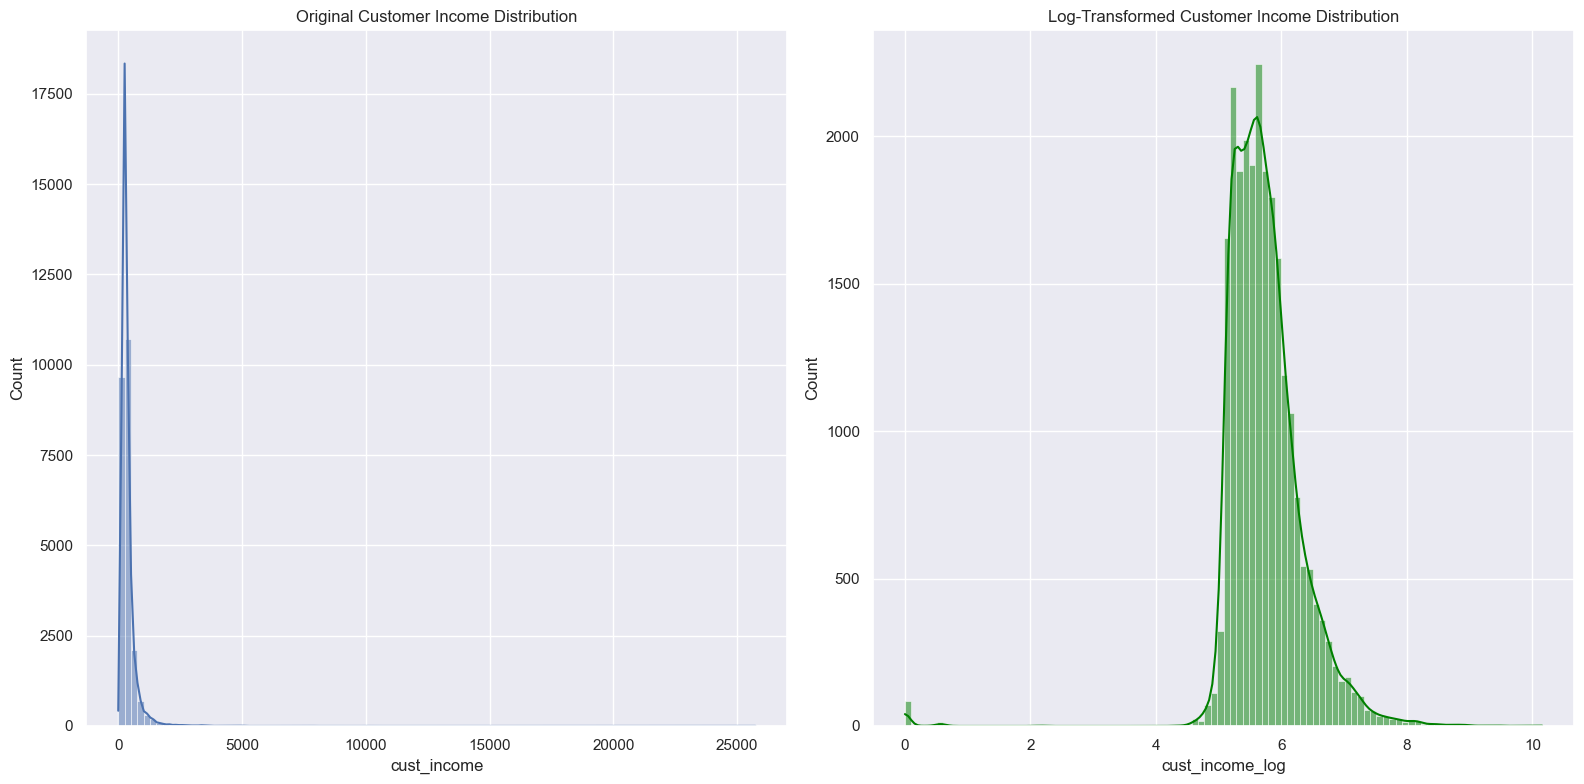

In [49]:
# Plot distributions before and after transformation
fig, axes = plt.subplots(1, 2)

sns.histplot(retail_df["cust_income"], bins=100, ax=axes[0], kde=True)
axes[0].set_title("Original Customer Income Distribution")
axes[0].set_xlabel("cust_income")

sns.histplot(retail_df["cust_income_log"], bins=100, ax=axes[1], kde=True, color='green')
axes[1].set_title("Log-Transformed Customer Income Distribution")
axes[1].set_xlabel("cust_income_log")

plt.tight_layout()
plt.show()

                                             |          | [  0%]   00:00 -> (? left)

Report ../reports/Retail Profile.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



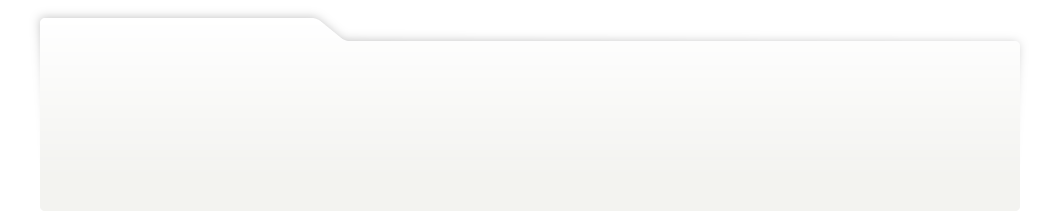
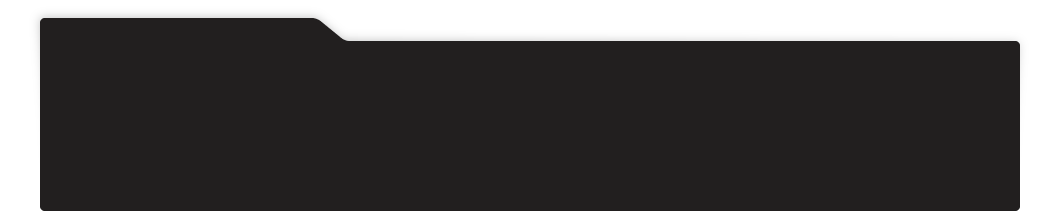
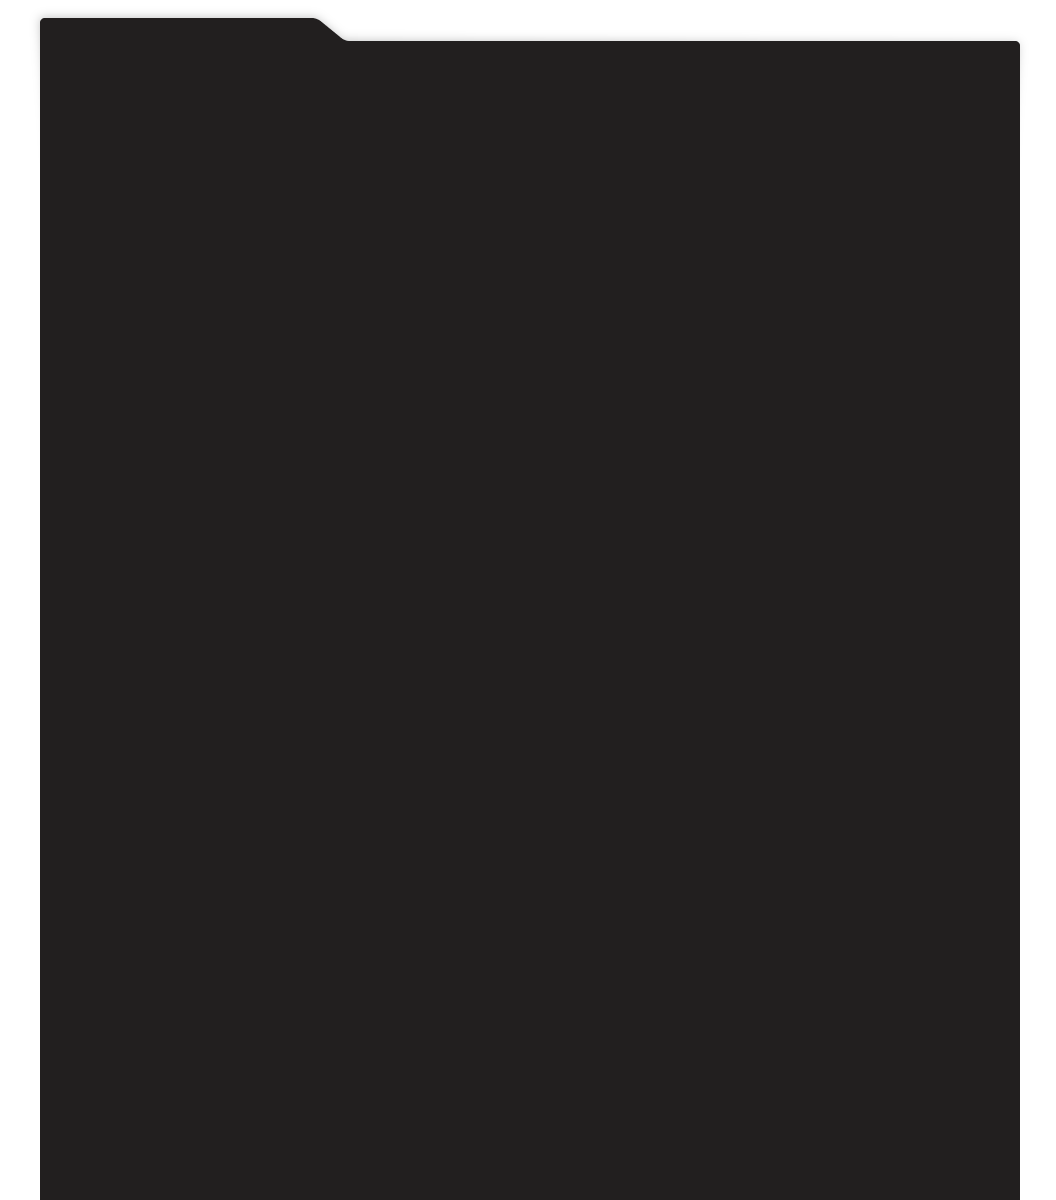
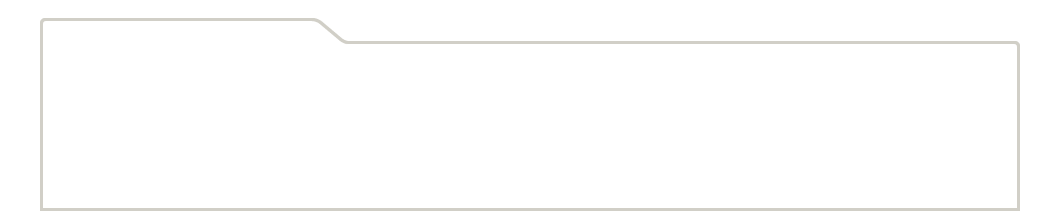
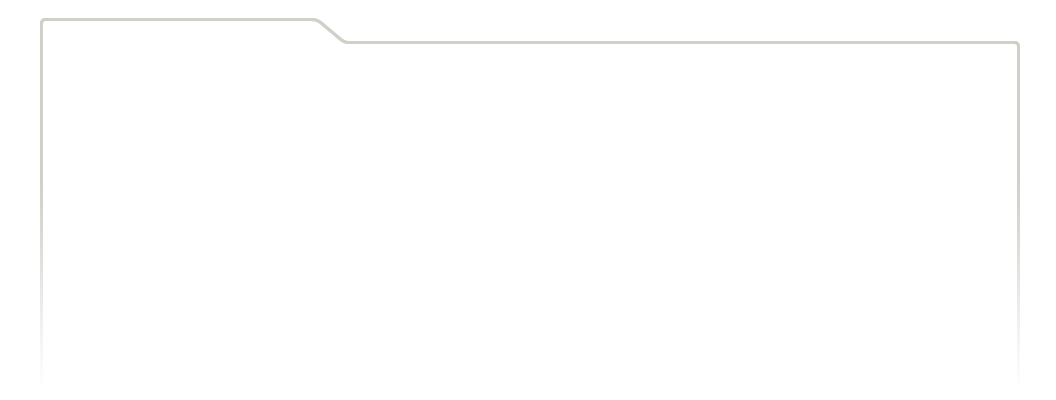
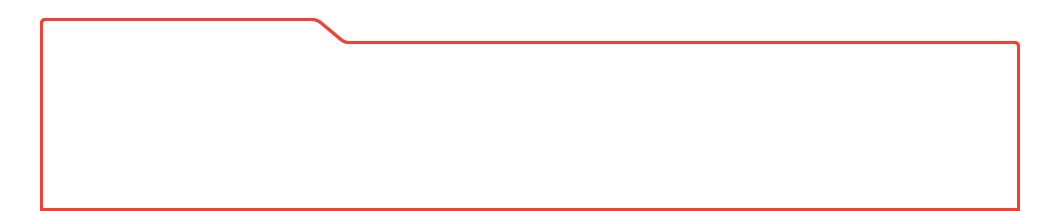
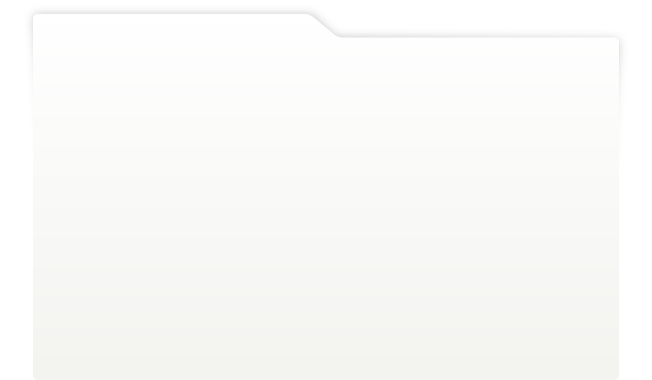
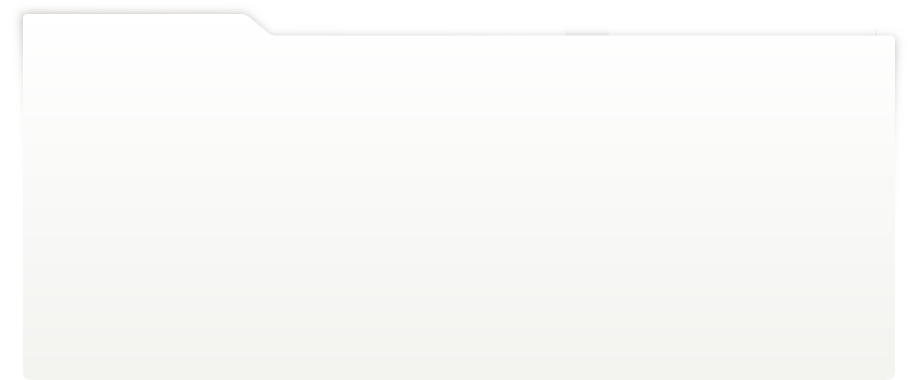
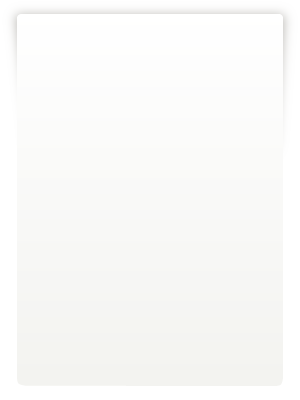
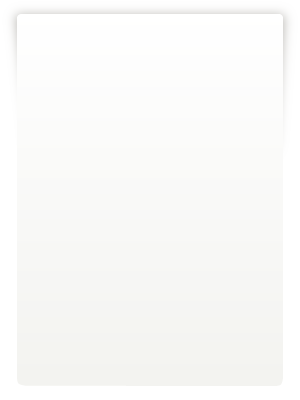
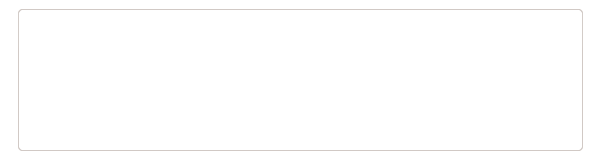
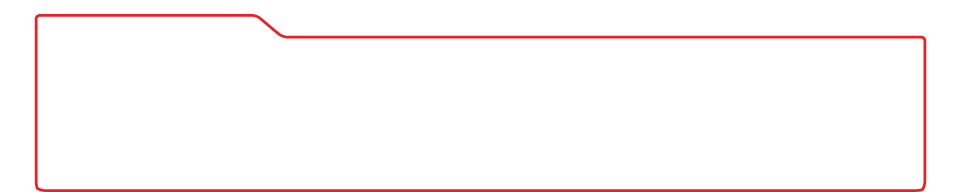
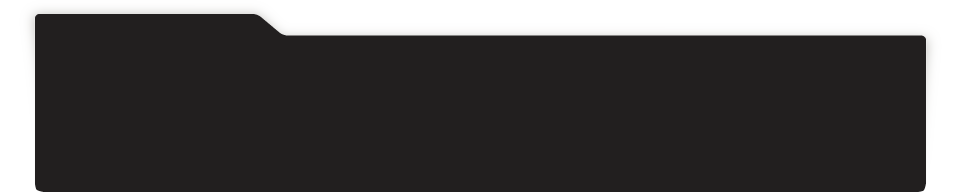
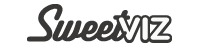
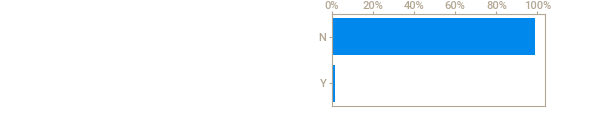
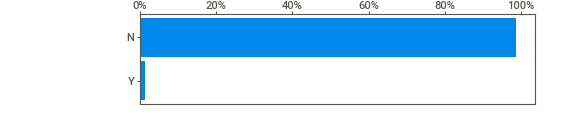
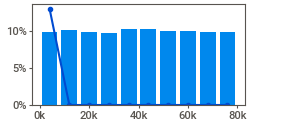
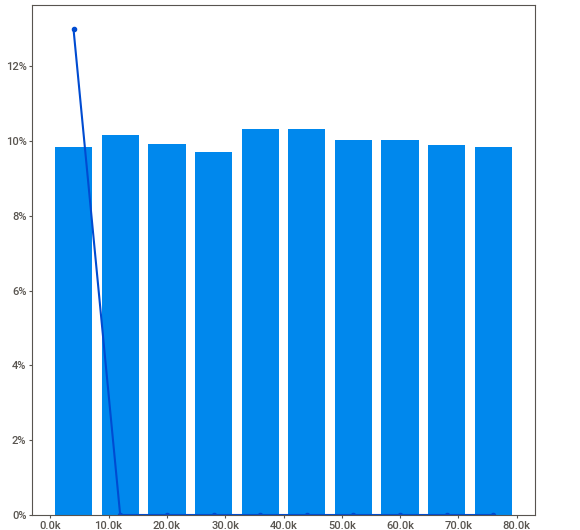
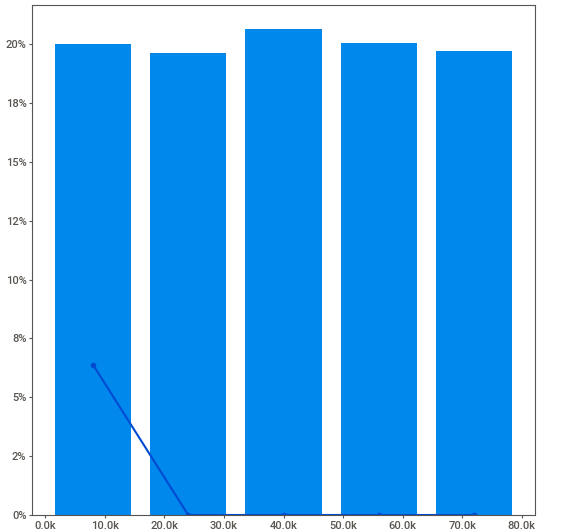
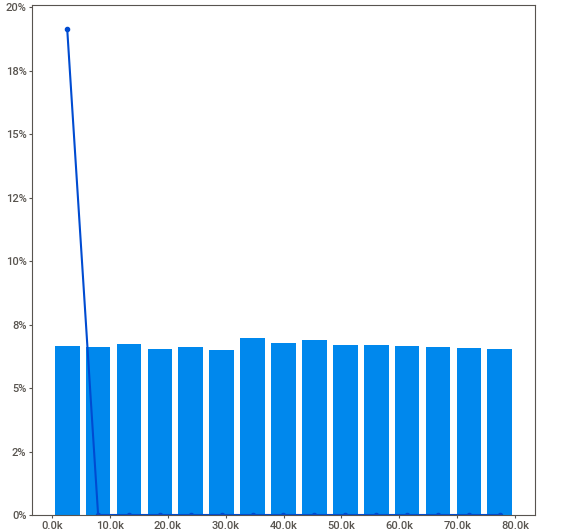
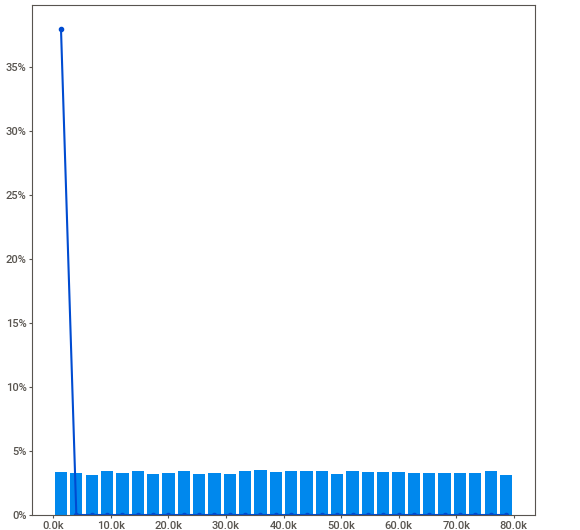
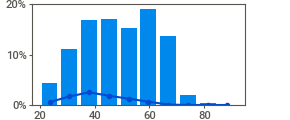
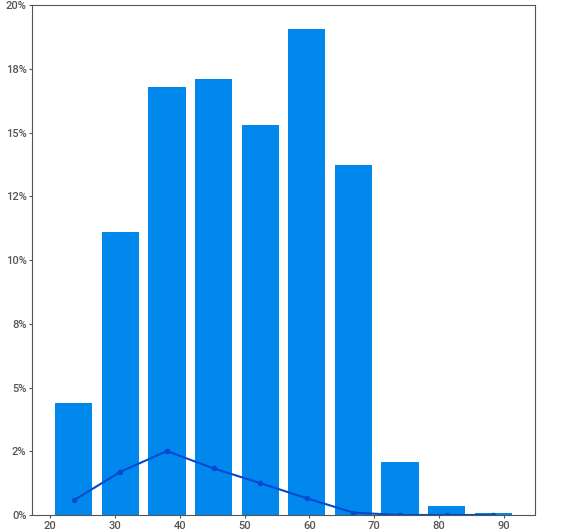
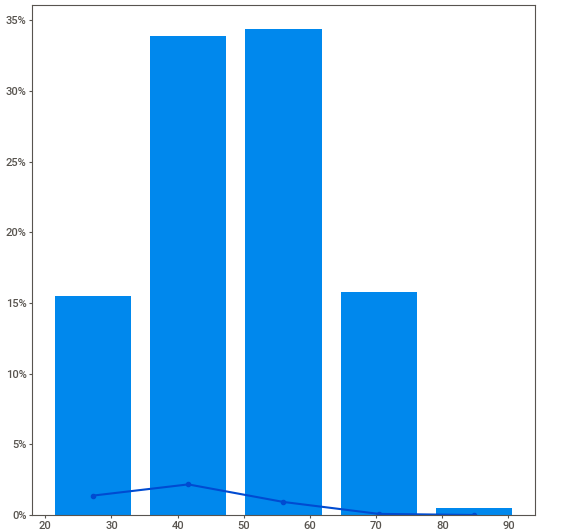
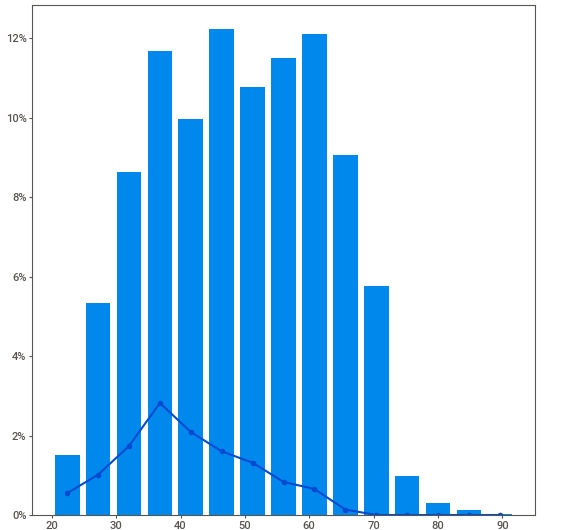
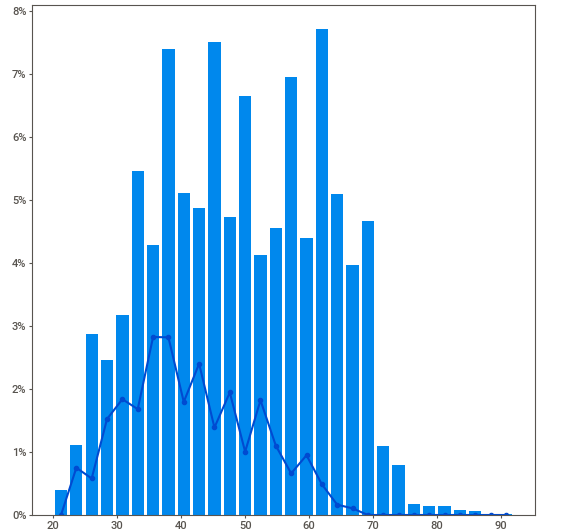
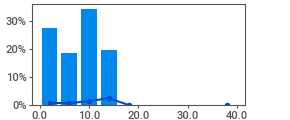
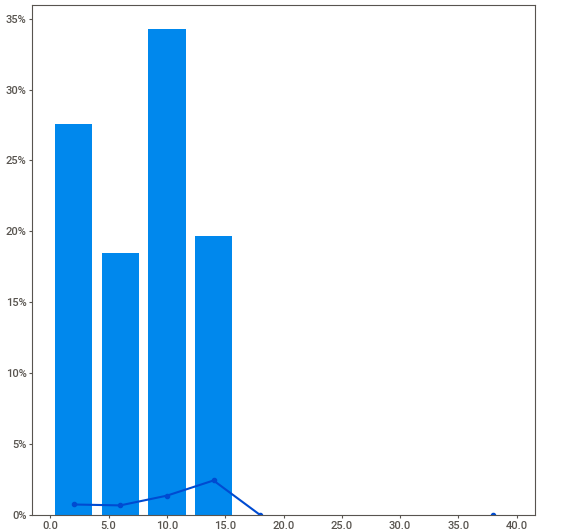
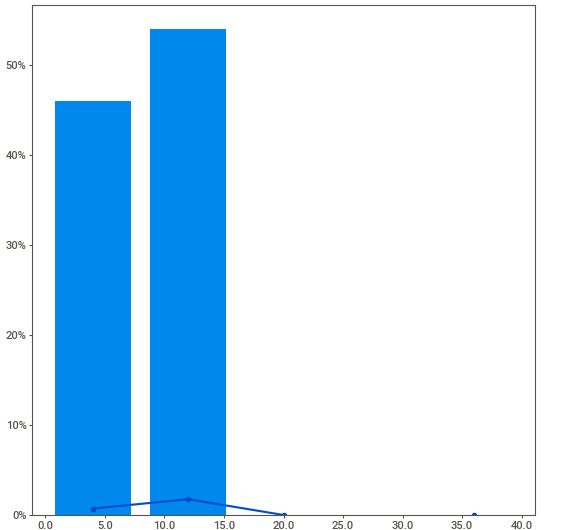
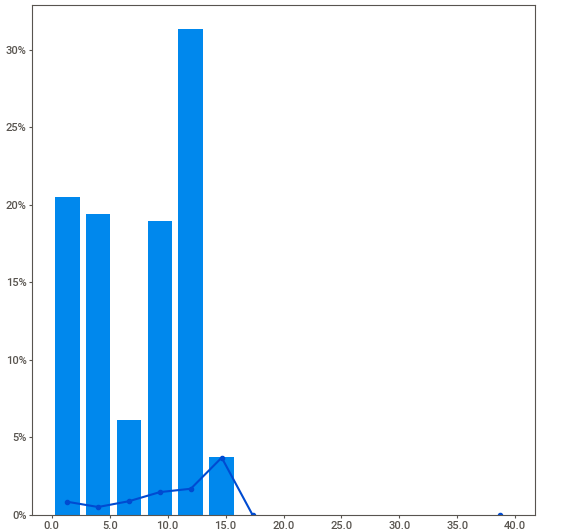
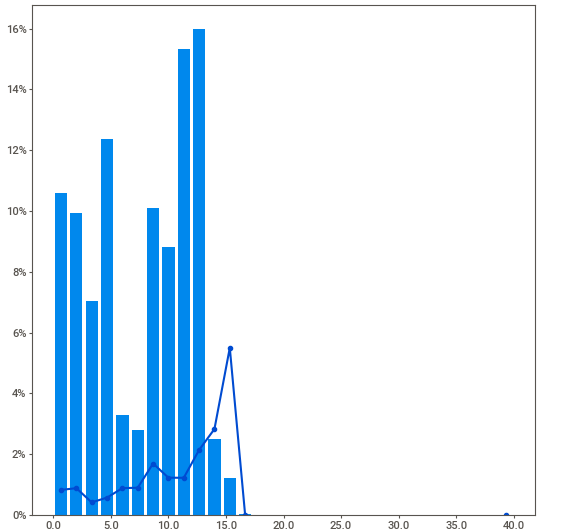
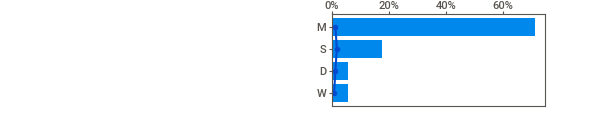
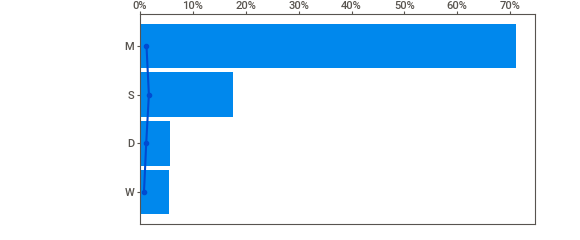
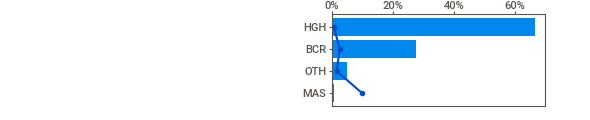
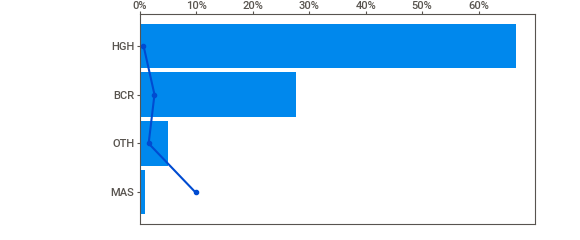
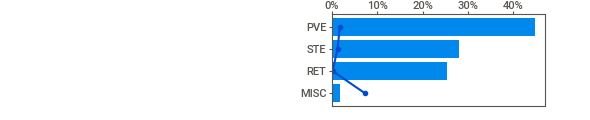
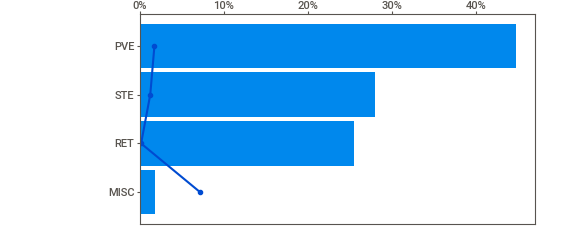
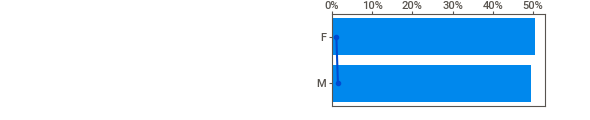
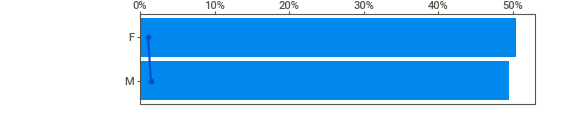
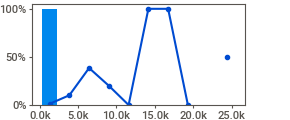
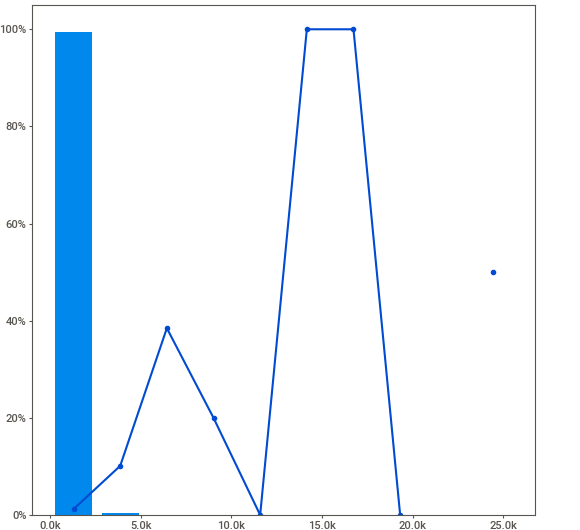
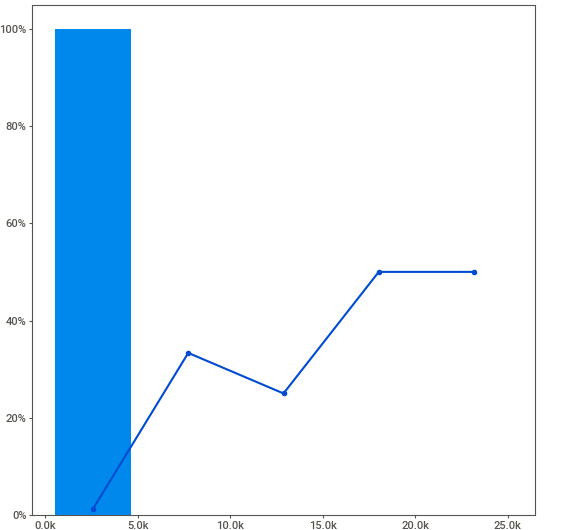
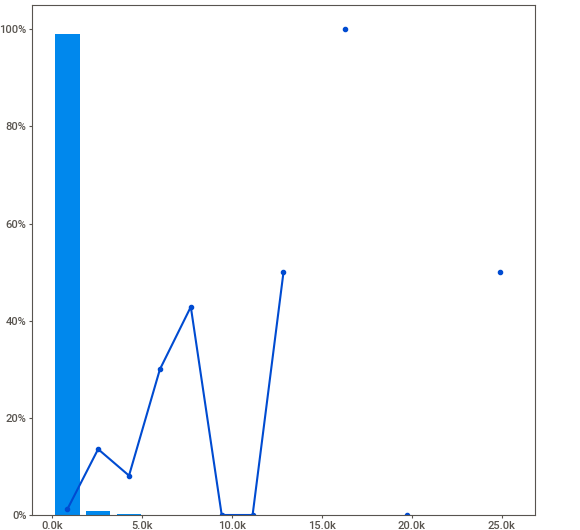
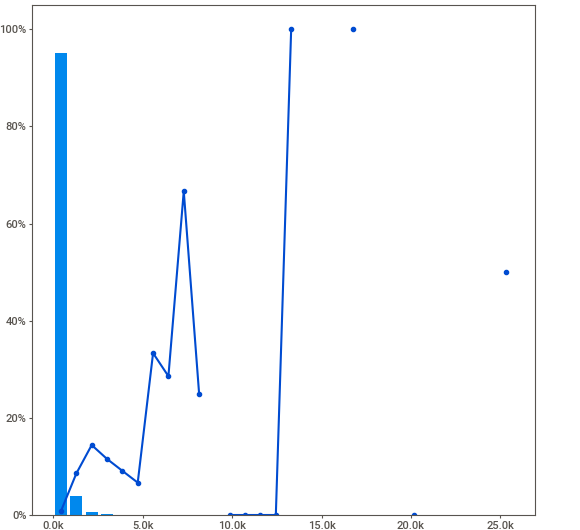
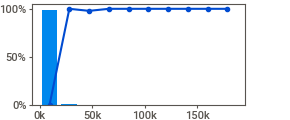
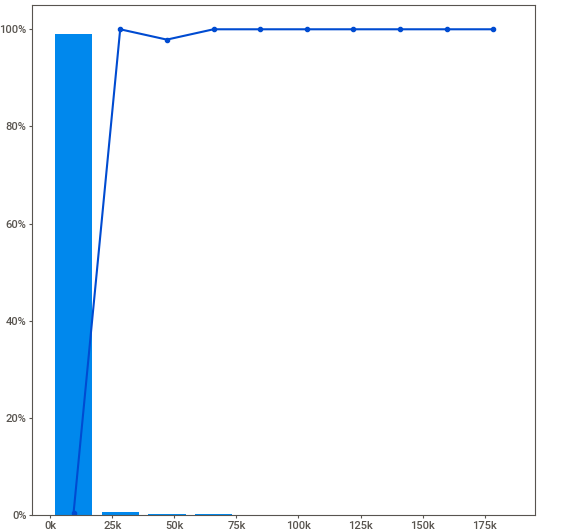
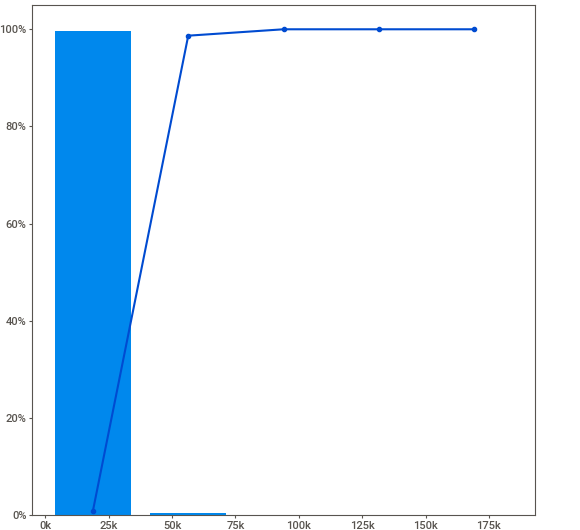
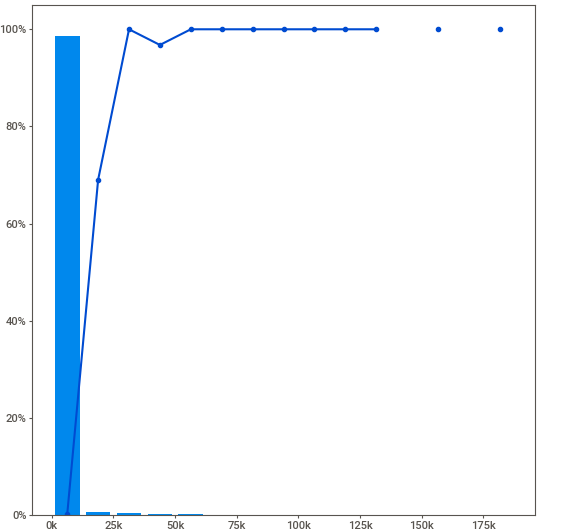
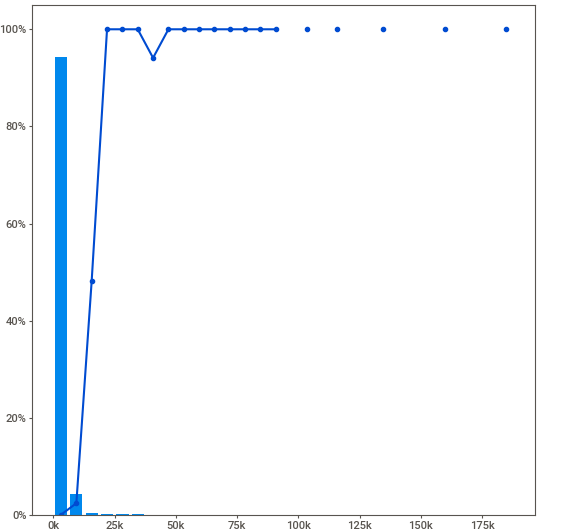
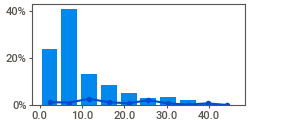
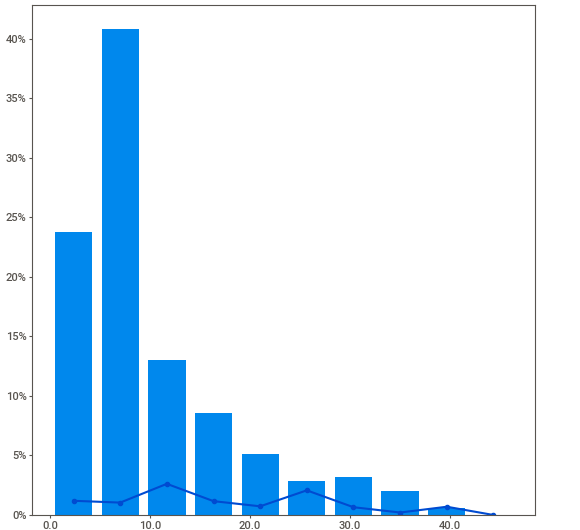
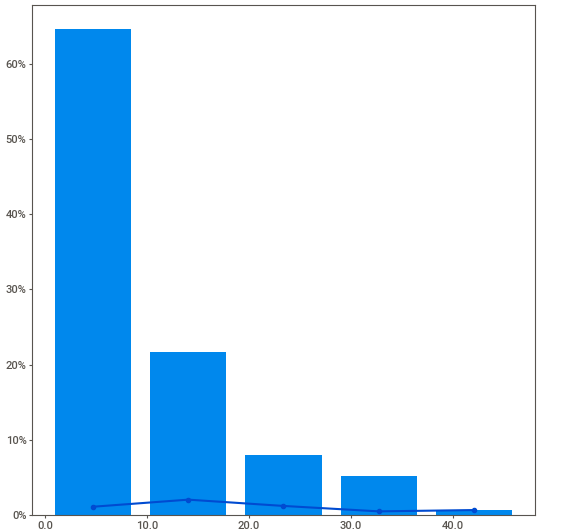
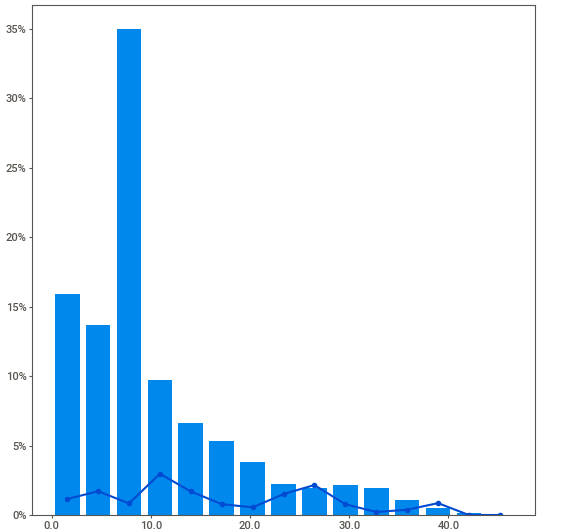
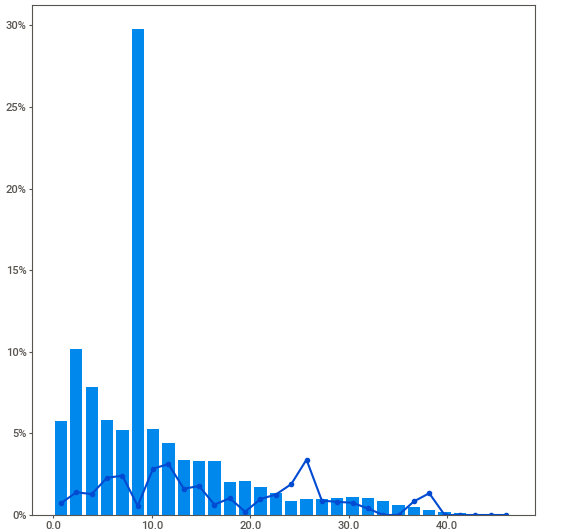
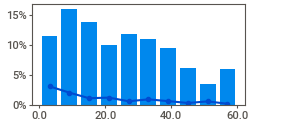
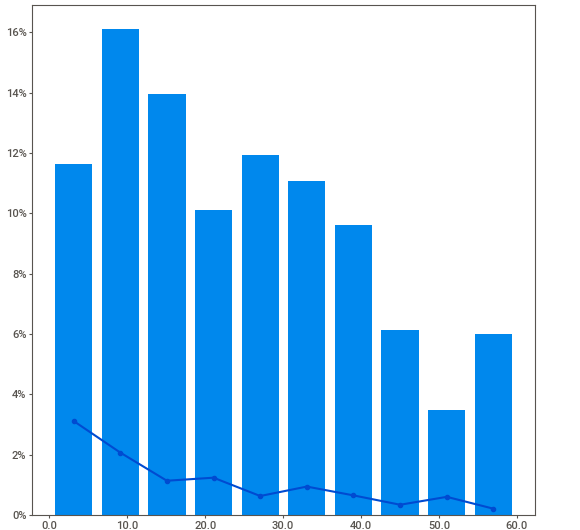
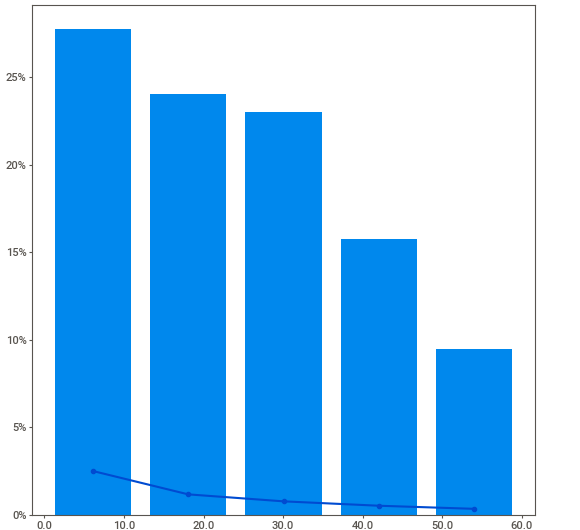
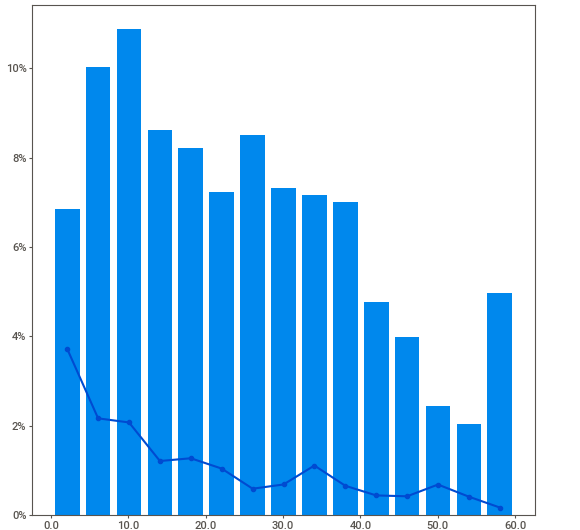
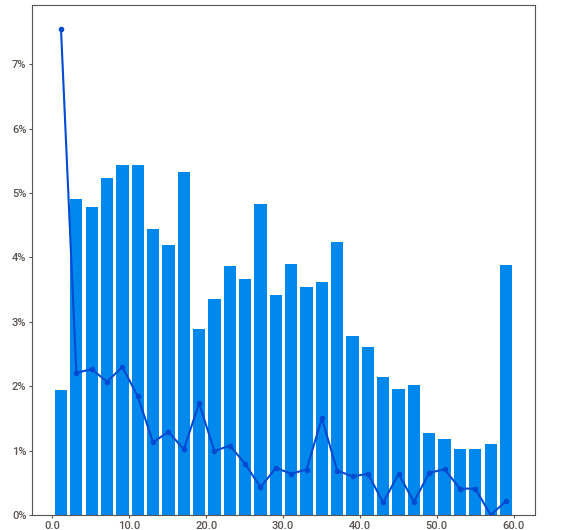
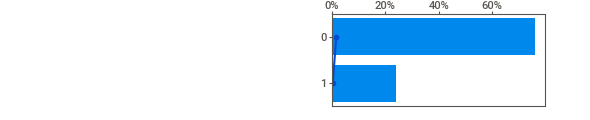
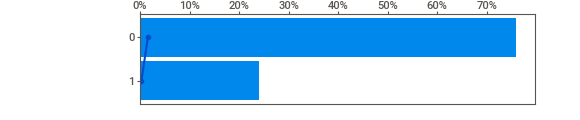
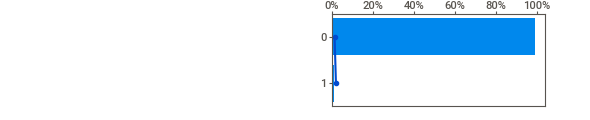
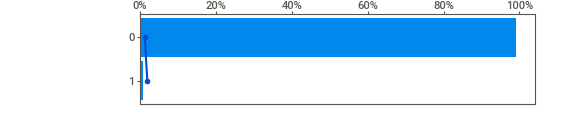
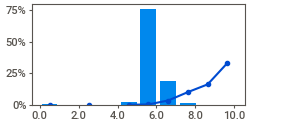
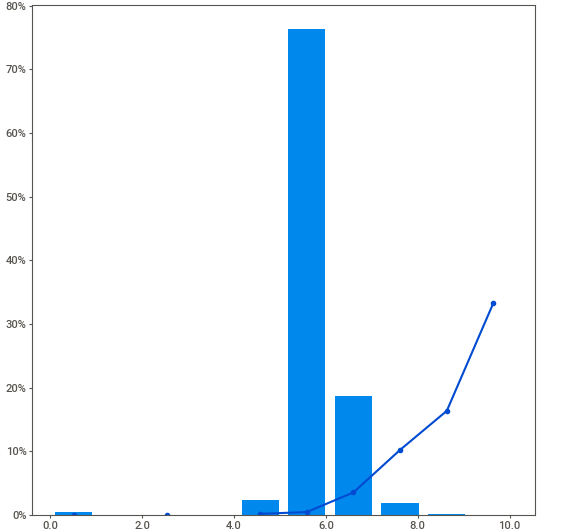
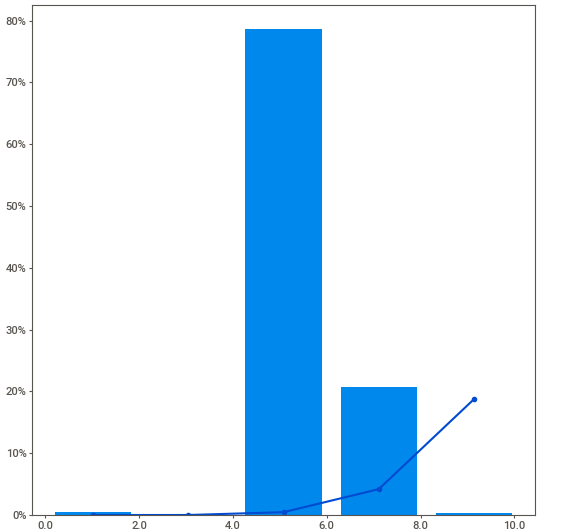
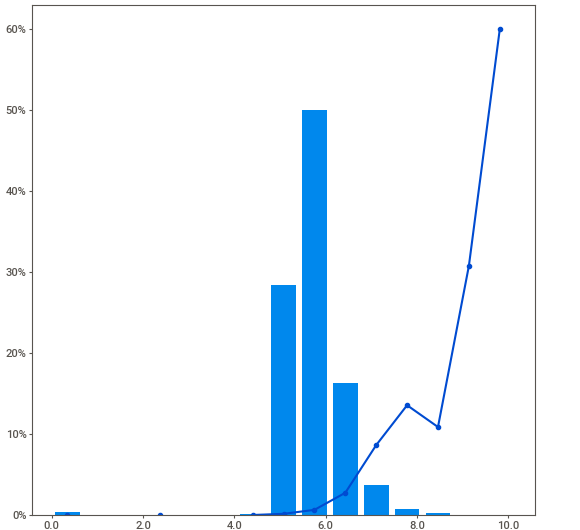
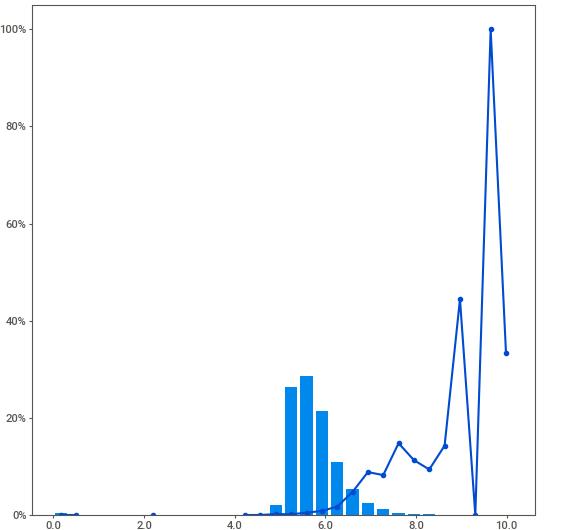
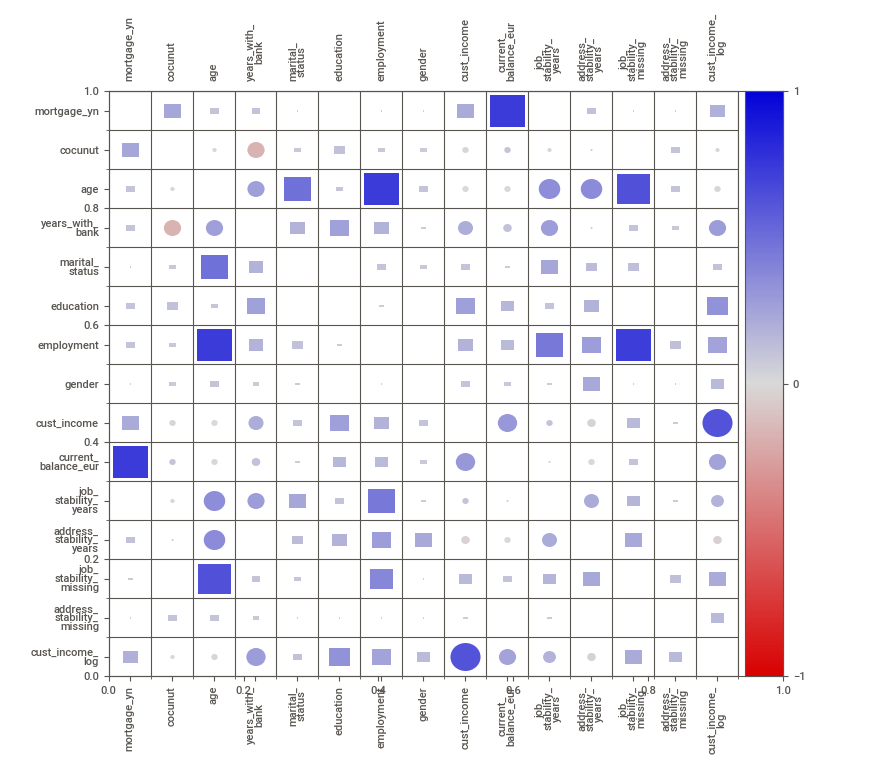
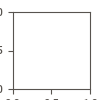

In [50]:
# Use the power of sweetviz library to understand retail_df in relevance to the target variable 'mortgage_yn'
my_report = sv.analyze(retail_df, target_feat='mortgage_yn')
my_report.show_html('../reports/Retail Profile.html')

my_report.show_notebook(w=None,
                h=None,
                scale=None,
                layout='widescreen',
                filepath=None)

                                             |          | [  0%]   00:00 -> (? left)

Report ../reports/Compare.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



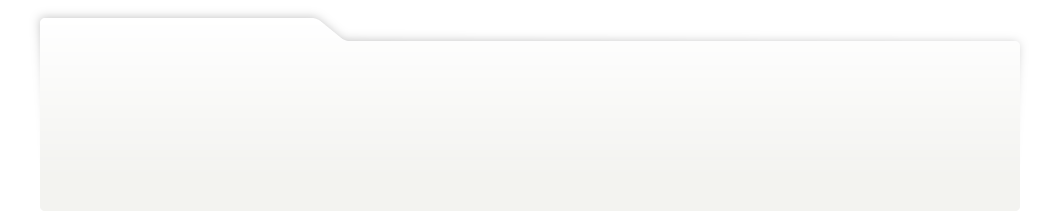
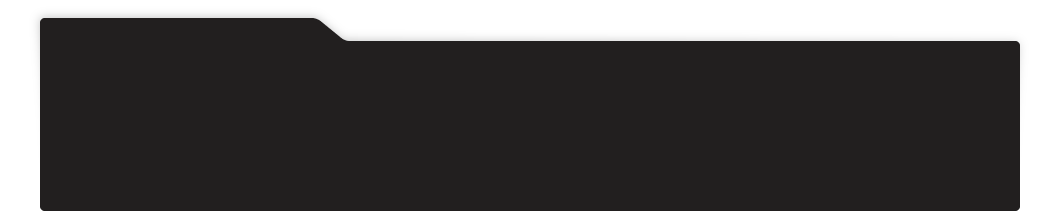
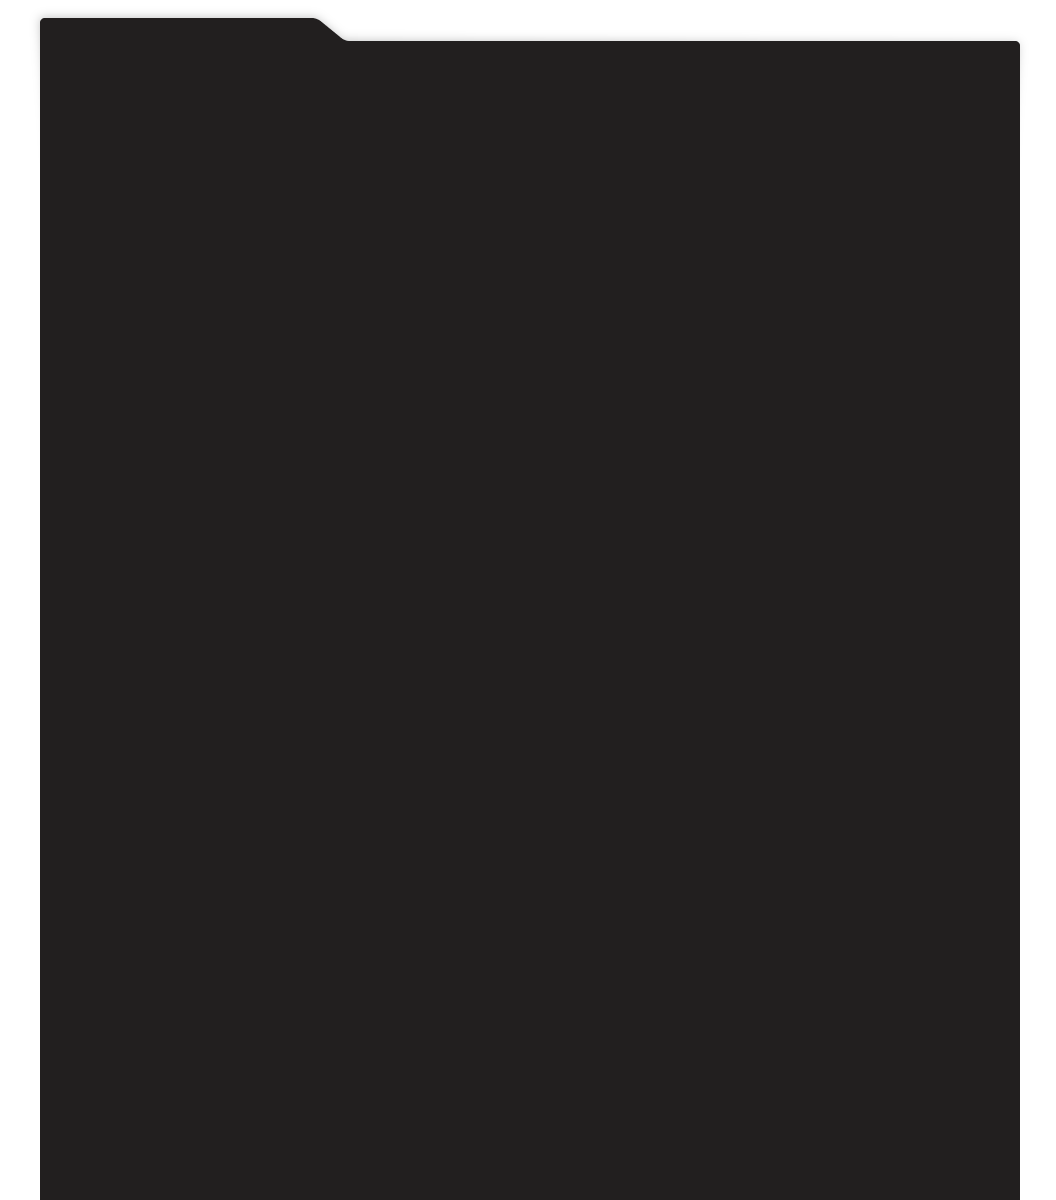
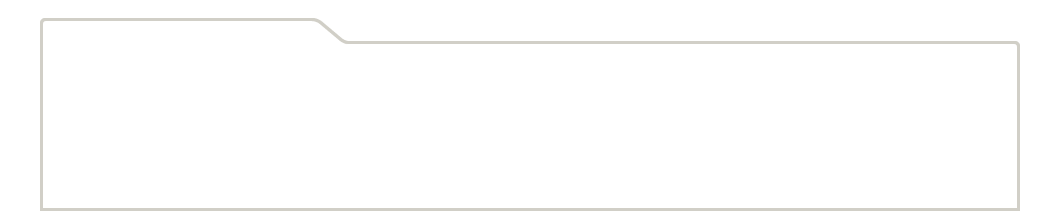
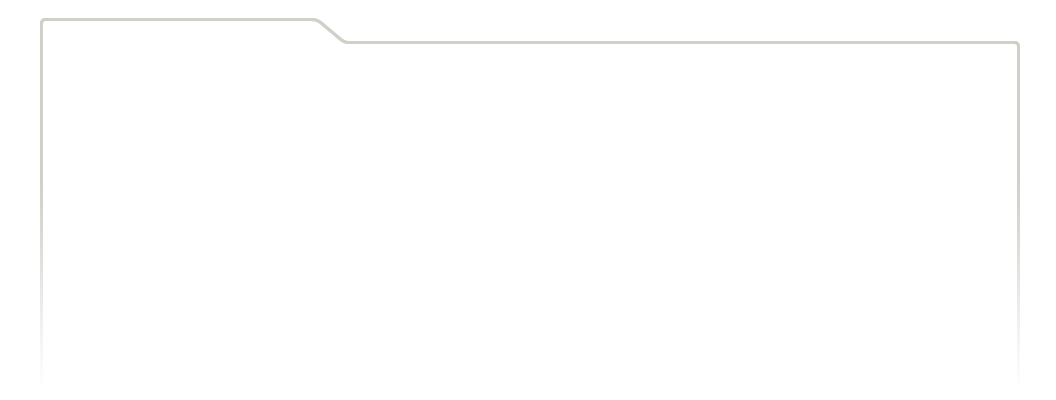
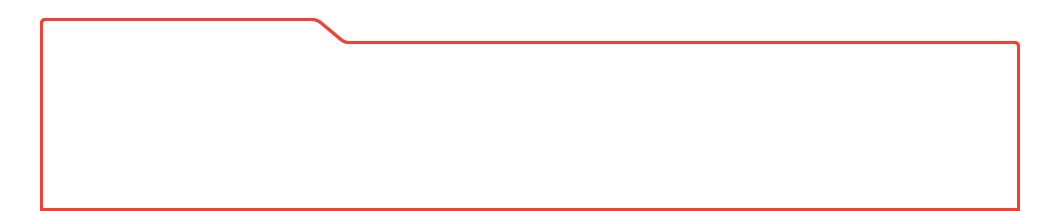
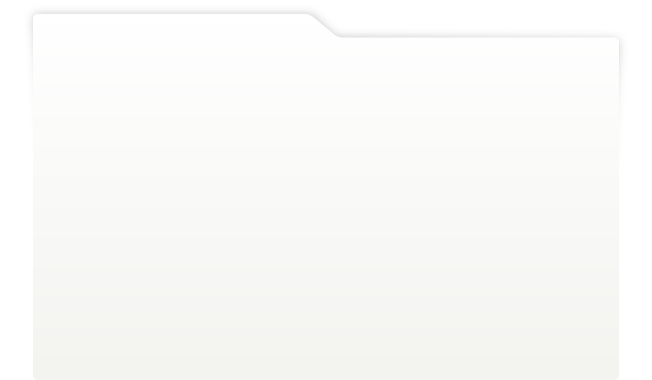
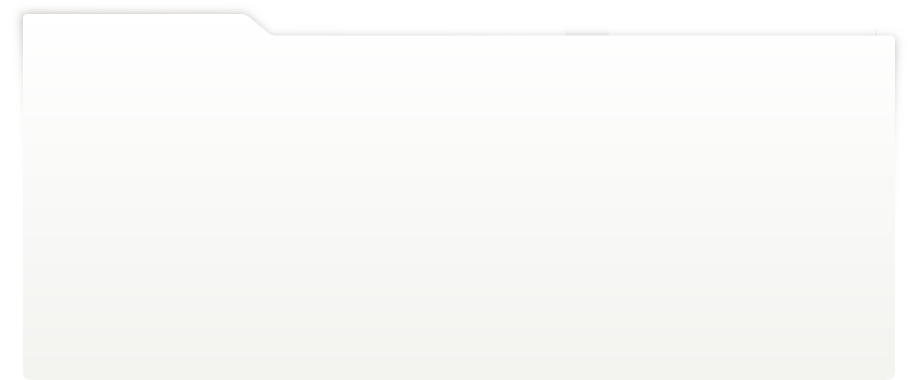
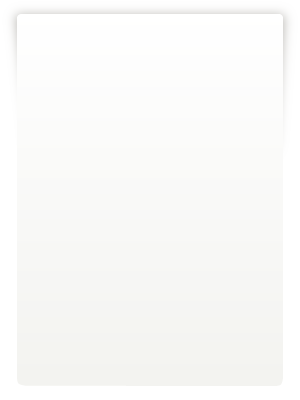
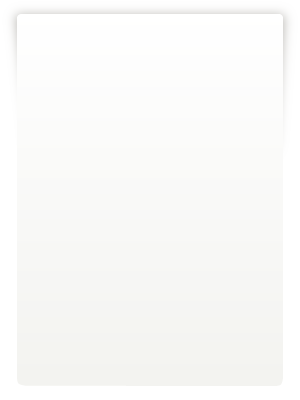
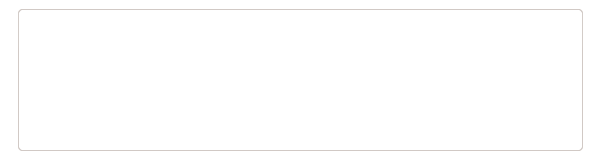
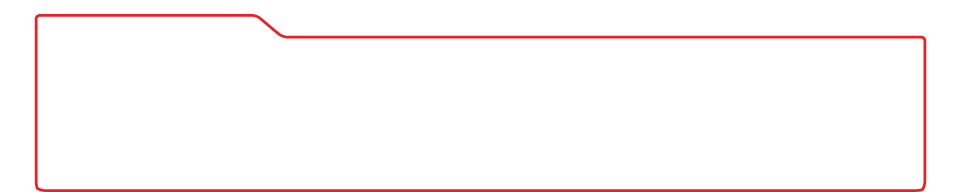
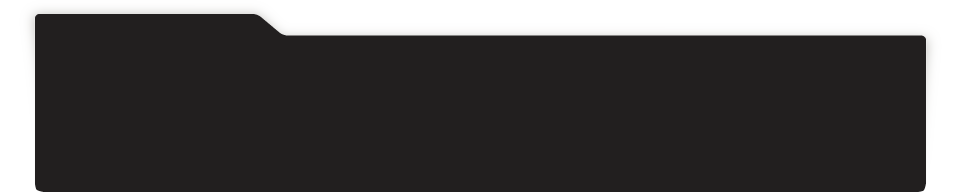
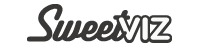
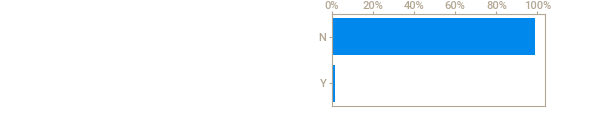
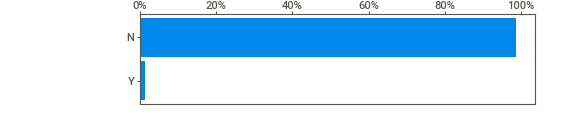
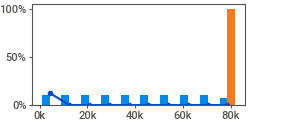
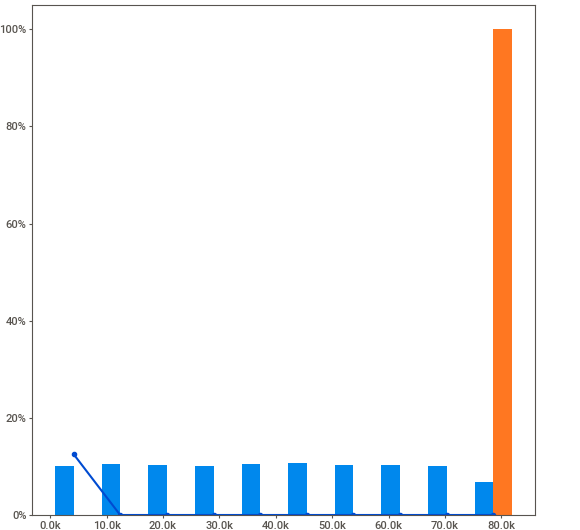
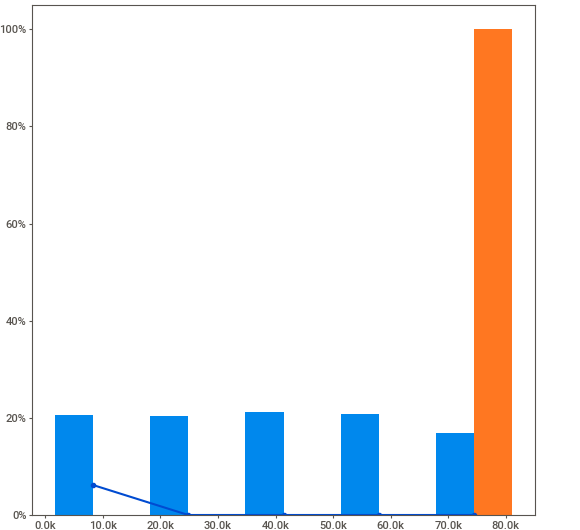
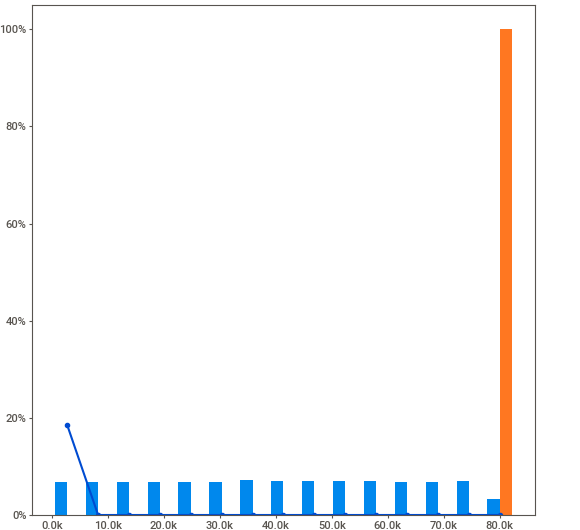
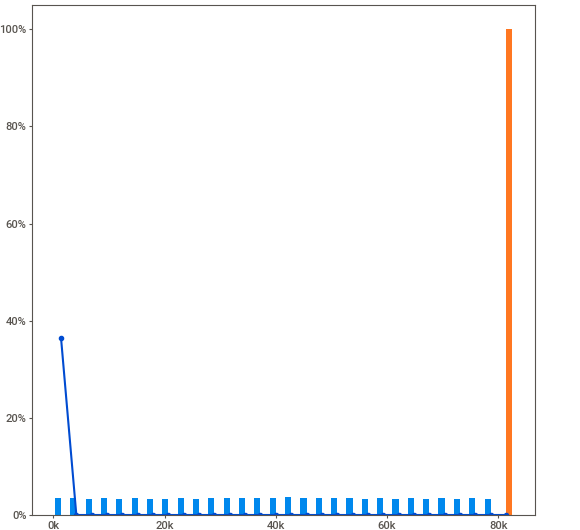
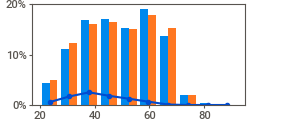
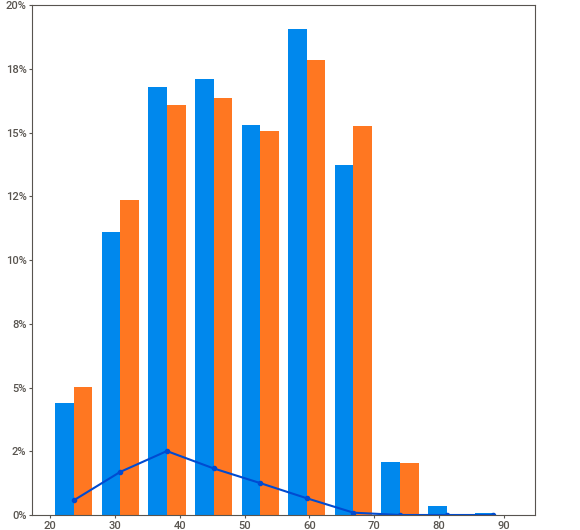
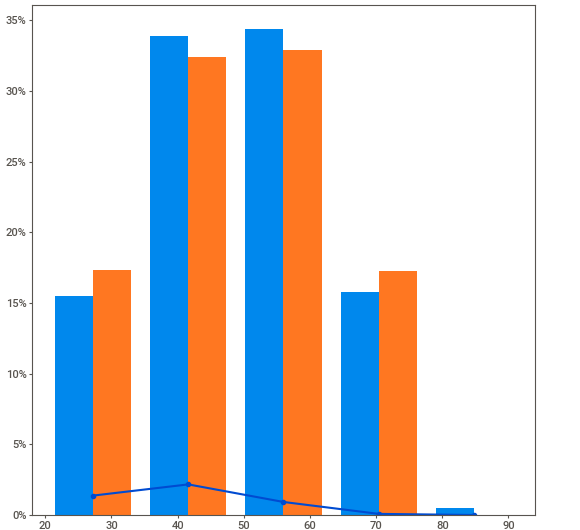
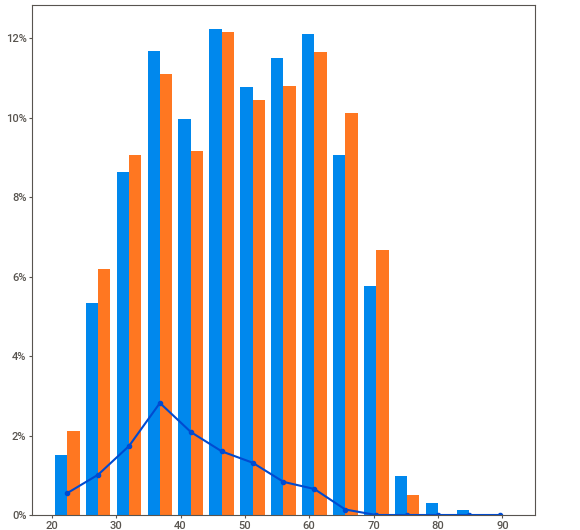
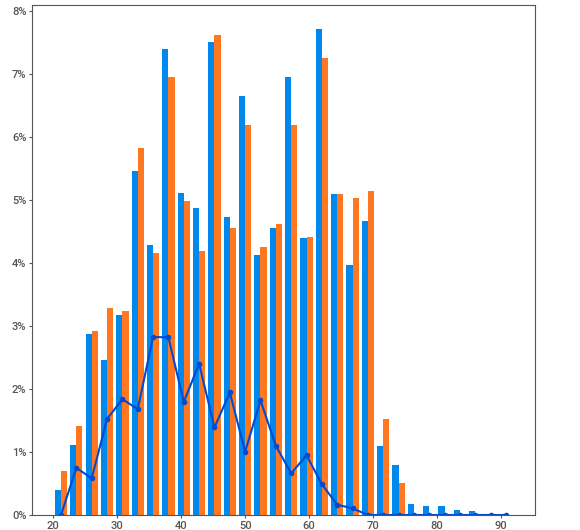
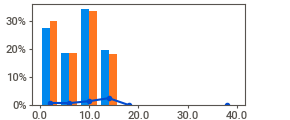
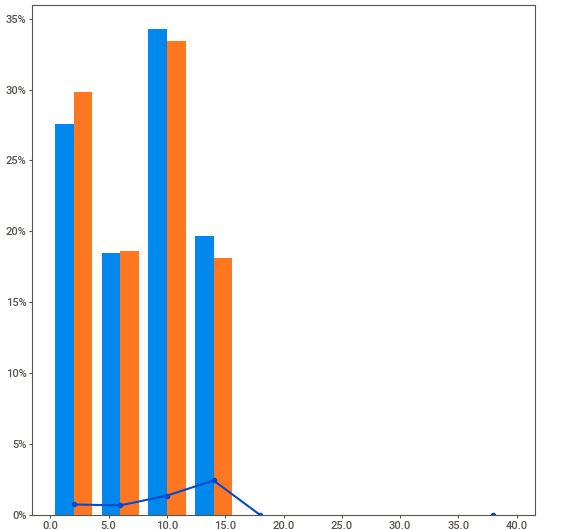
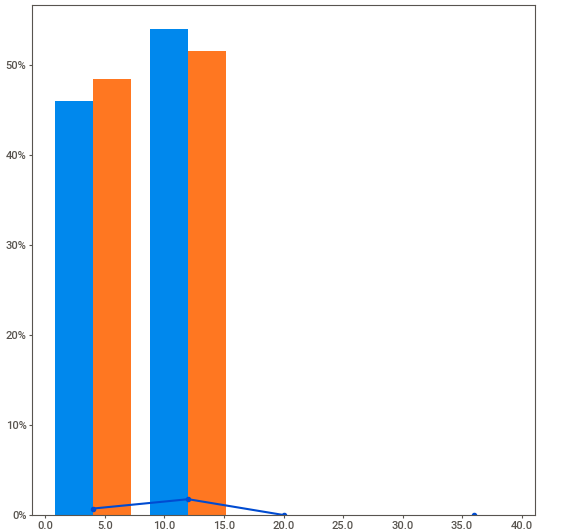
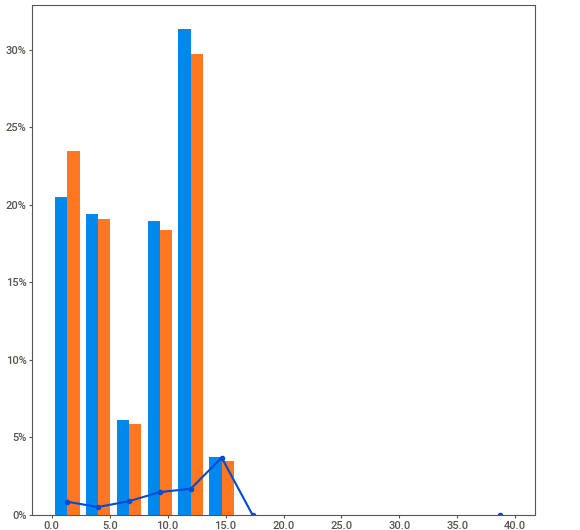
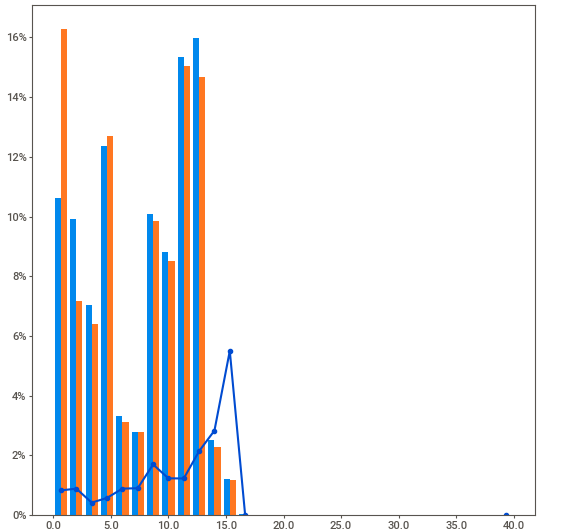
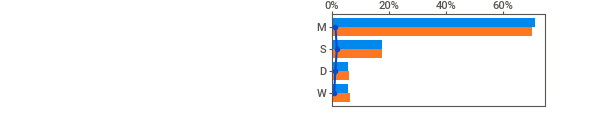
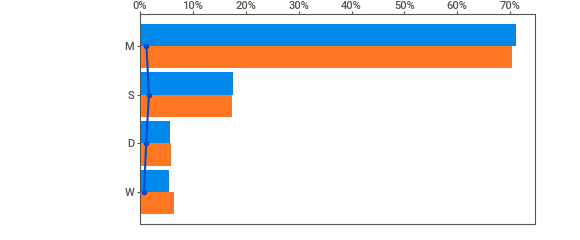
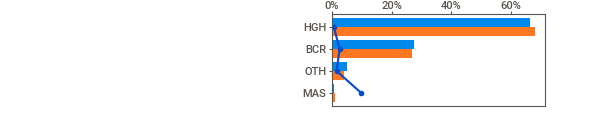
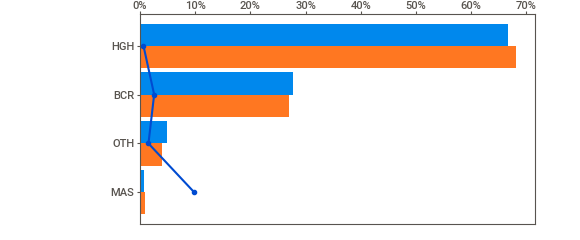
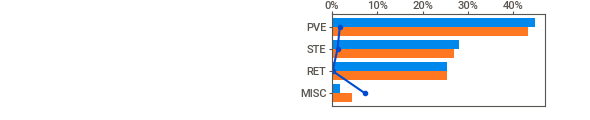
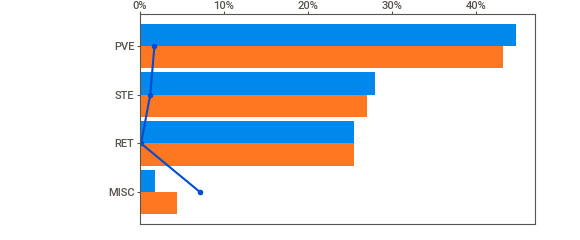
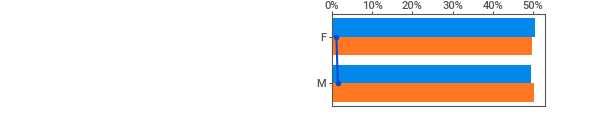
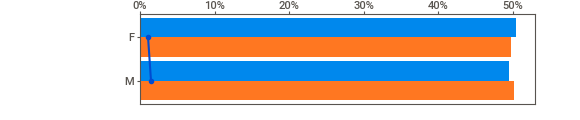
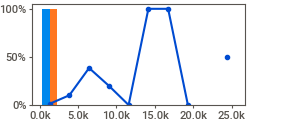
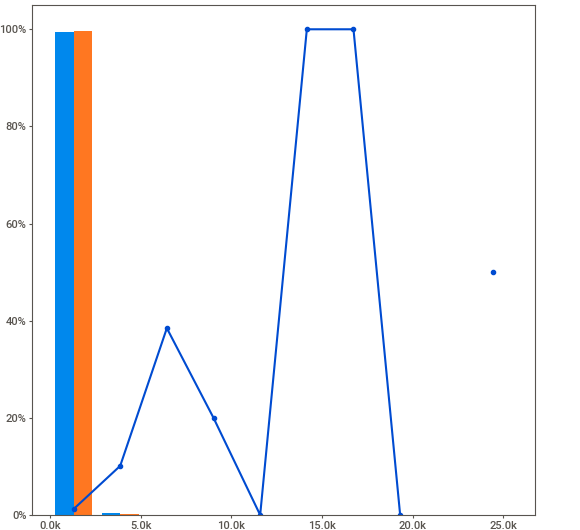
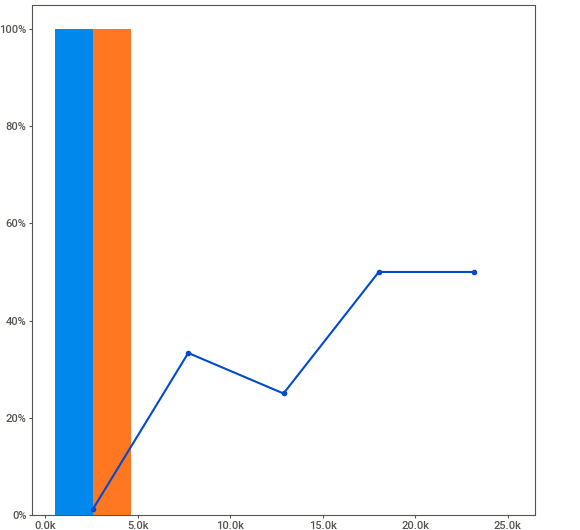
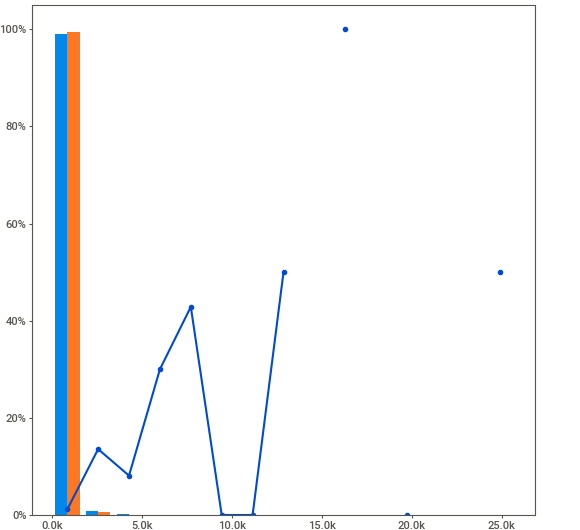
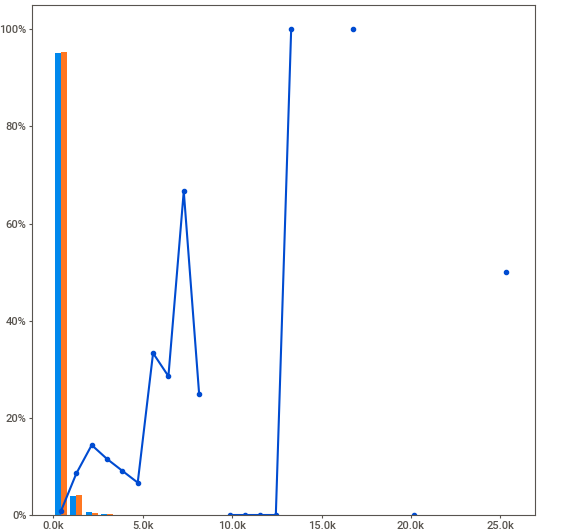
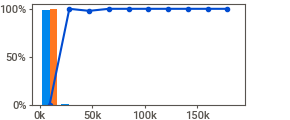
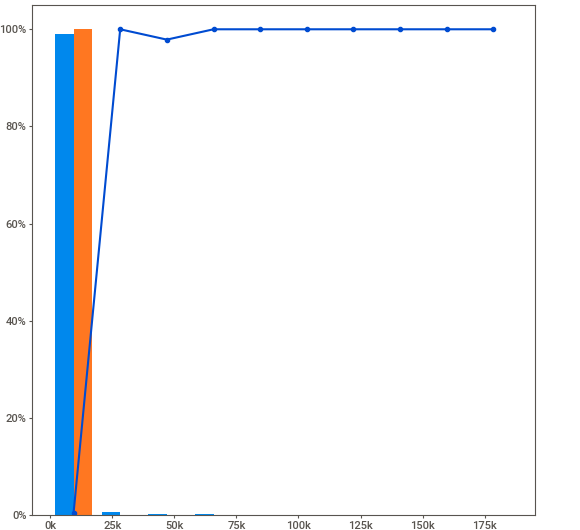
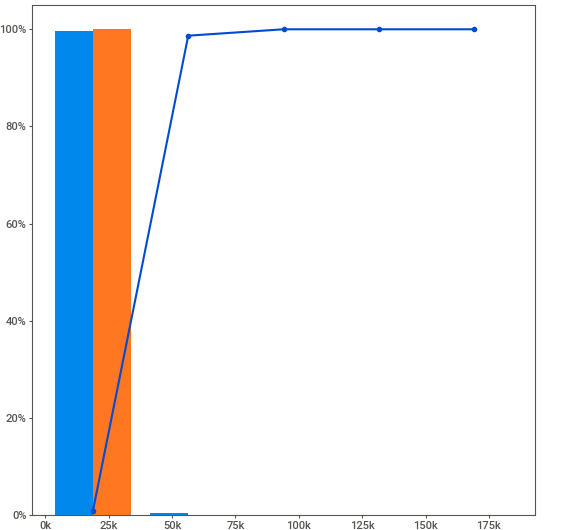
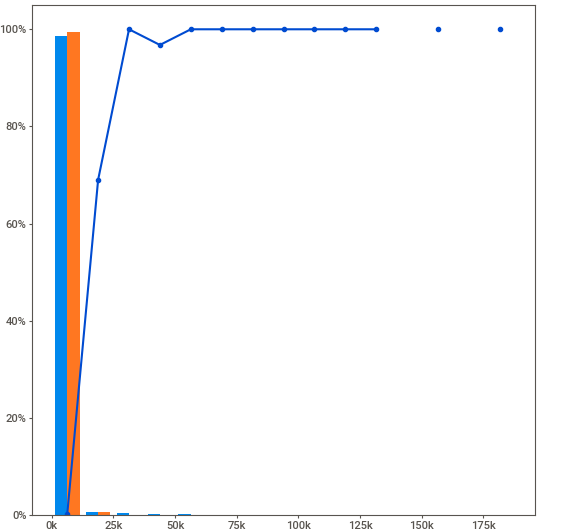
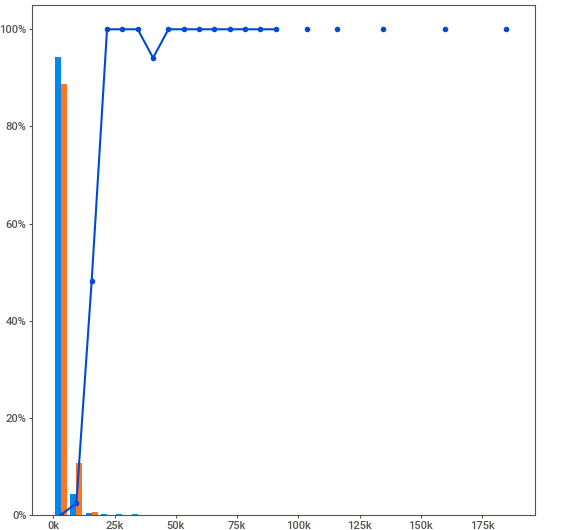
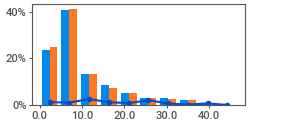
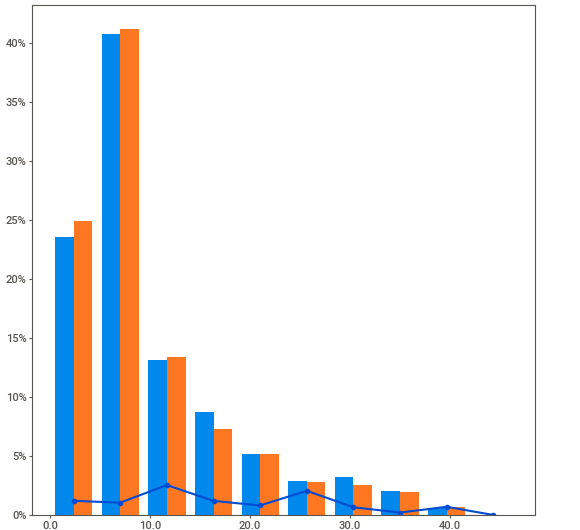
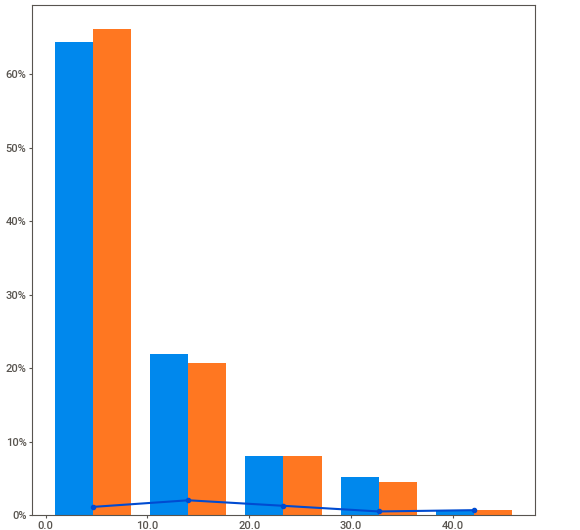
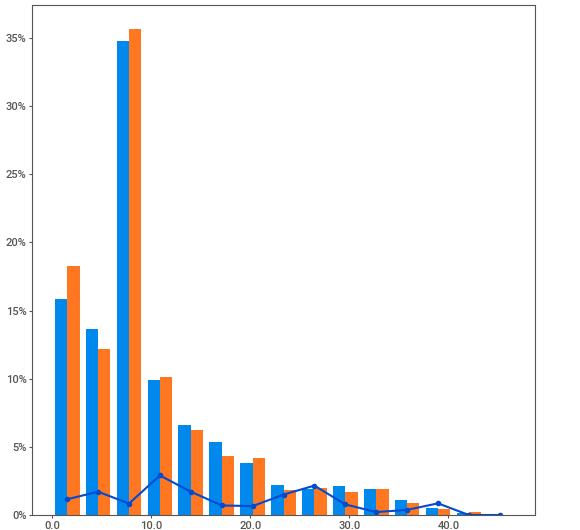
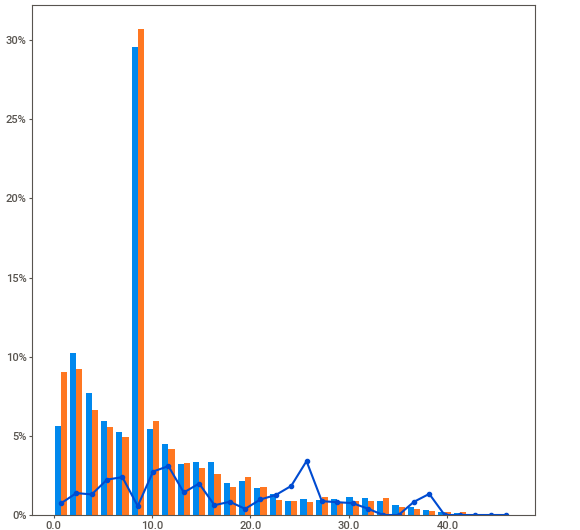
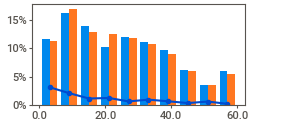
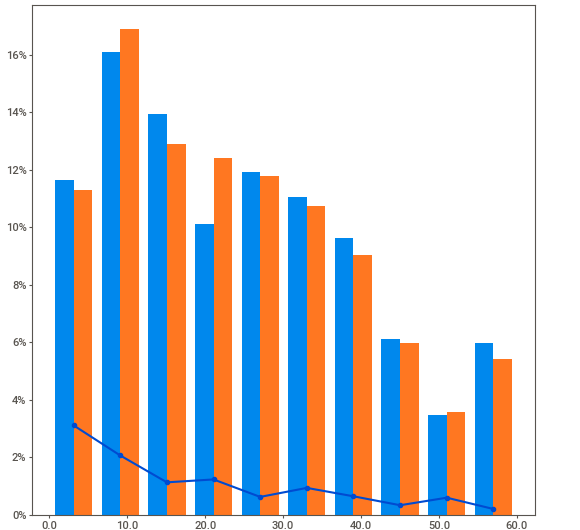
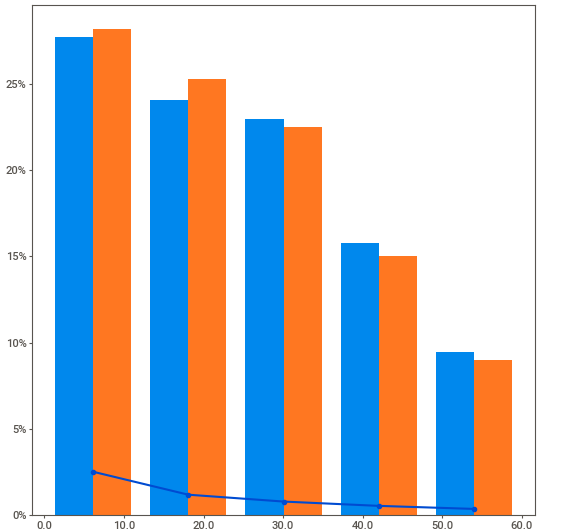
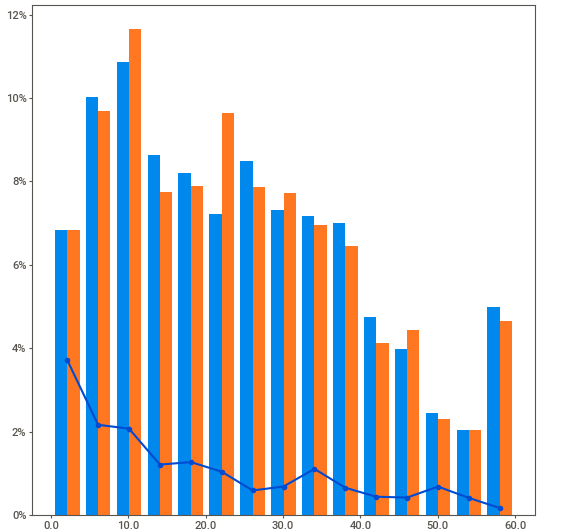
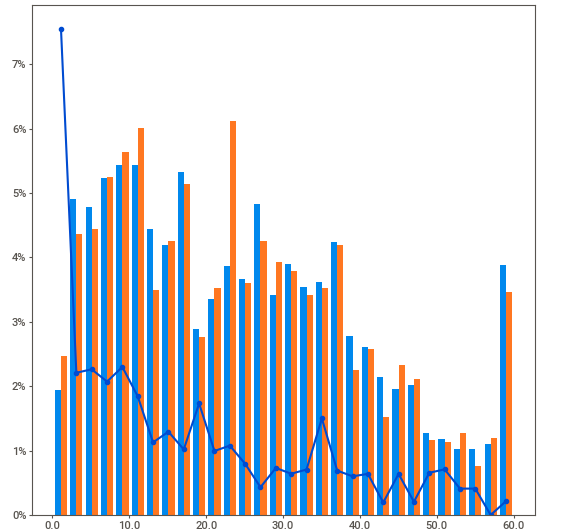
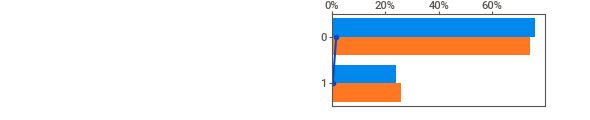
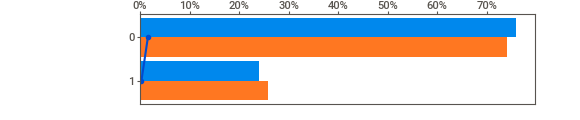
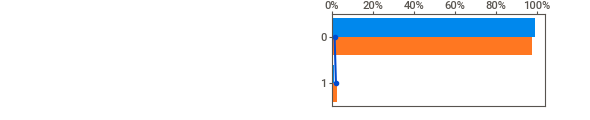
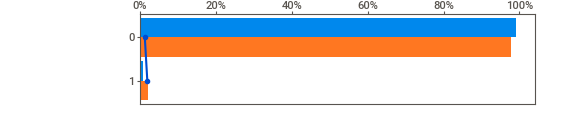
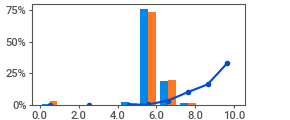
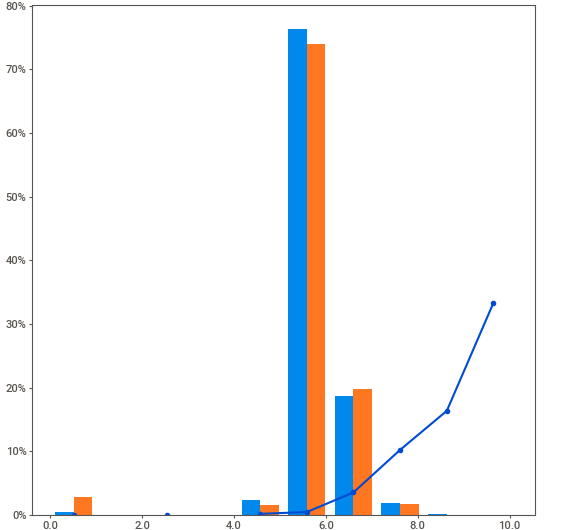
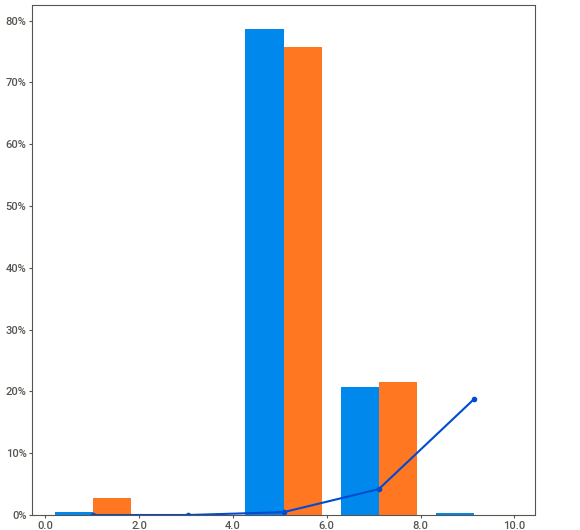
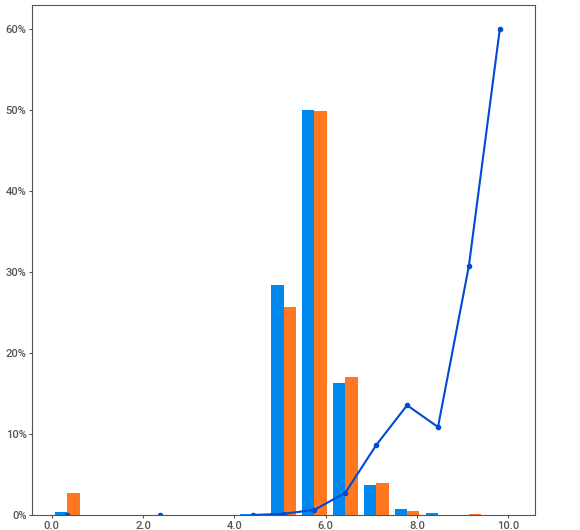
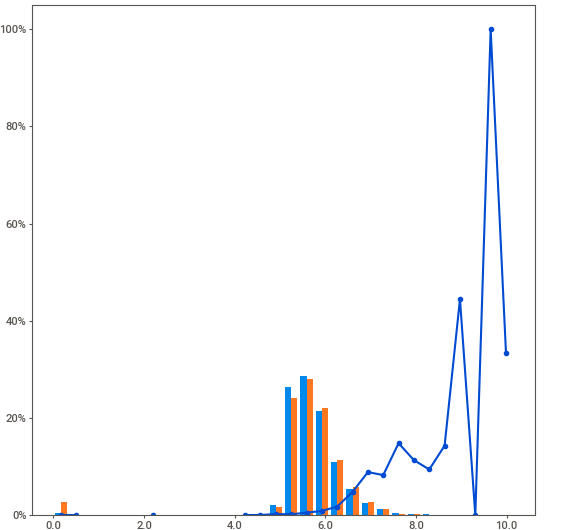
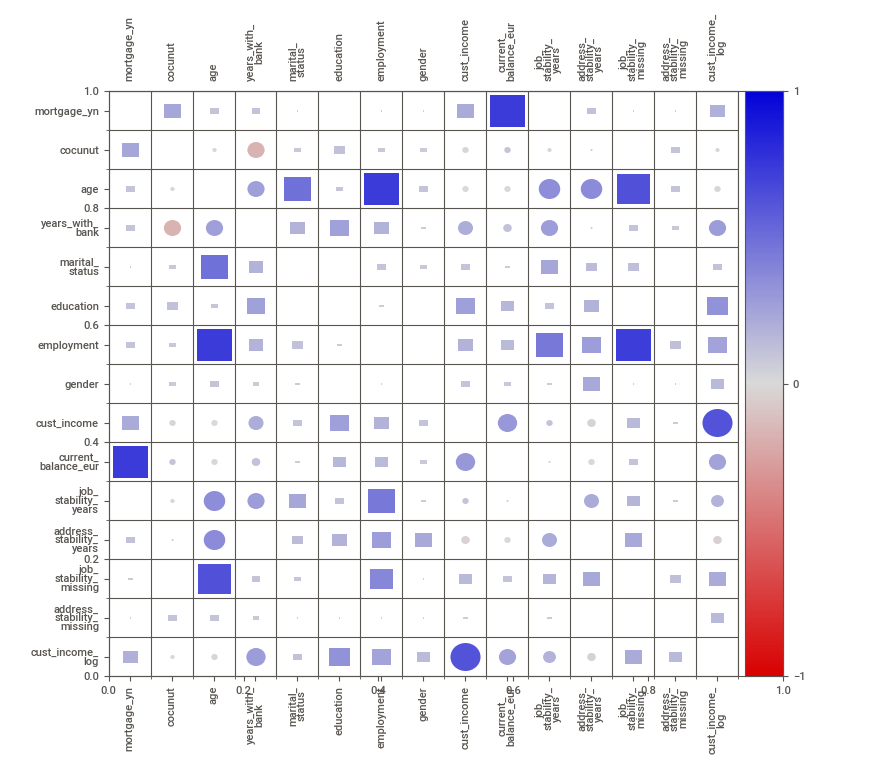
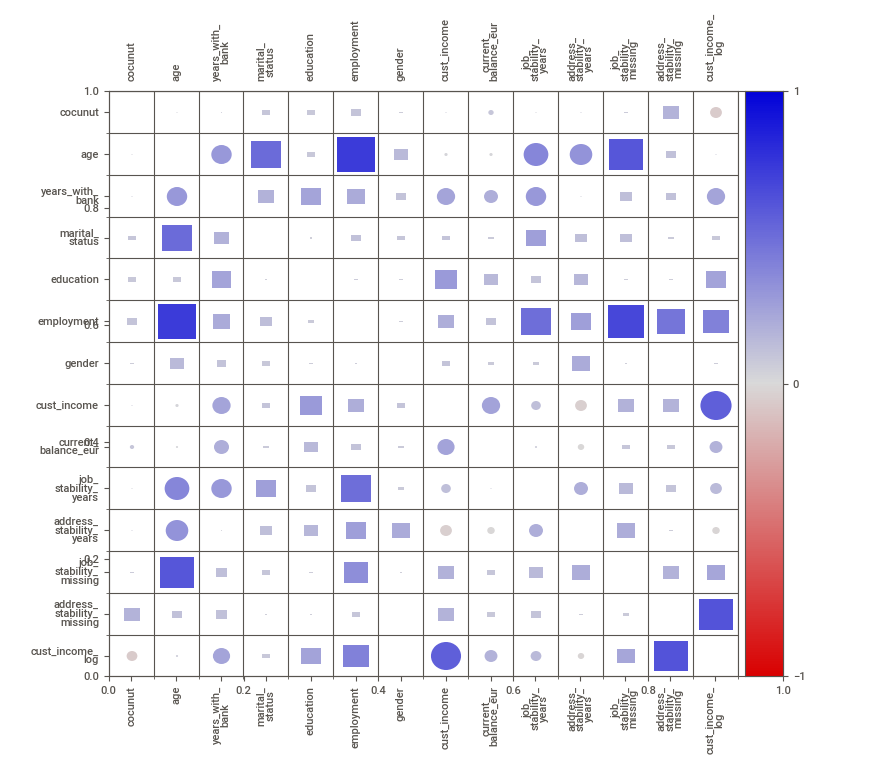

In [51]:
# Compare the retail_df and potential_df
compare = sv.compare(source=retail_df, compare=potential_df, target_feat="mortgage_yn")

# Show the result
compare.show_html('../reports/Compare.html')

compare.show_notebook(w=None,
                h=None,
                scale=None,
                layout='widescreen',
                filepath=None)

In [52]:
profile = ProfileReport(retail_df, title="../reports/Profiling Report")
profile.to_file("../reports/Retail Profile 2.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:05<00:00,  2.72it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
profile = ProfileReport(potential_df, title="Profiling Report")
profile.to_file("../reports/Potential Profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 28.63it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
retail_df.columns, potential_df.columns

(Index(['cocunut', 'mortgage_yn', 'age', 'years_with_bank', 'marital_status',
        'education', 'employment', 'gender', 'cust_income',
        'current_with_bank_date', 'current_balance_eur', 'job_stability_years',
        'address_stability_years', 'job_stability_missing',
        'address_stability_missing', 'cust_income_log'],
       dtype='object'),
 Index(['cocunut', 'age', 'years_with_bank', 'marital_status', 'education',
        'employment', 'gender', 'cust_income', 'current_with_bank_date',
        'current_balance_eur', 'job_stability_years', 'address_stability_years',
        'job_stability_missing', 'address_stability_missing',
        'cust_income_log'],
       dtype='object'))

In [55]:
# Group statistics by mortgage_yn
eda_summary = retail_df.groupby("mortgage_yn")[["age", "cust_income", "years_with_bank", "address_stability_years", "job_stability_years"]].mean()

# Count by marital status and mortgage
marital_mortgage = pd.crosstab(retail_df["marital_status"], retail_df["mortgage_yn"], normalize='index') * 100

# Count by employment status and mortgage
employment_mortgage = pd.crosstab(retail_df["employment"], retail_df["mortgage_yn"], normalize='index') * 100

eda_summary, marital_mortgage, employment_mortgage

(                   age  cust_income  years_with_bank  address_stability_years  \
 mortgage_yn                                                                     
 N            49.083879   371.813207         7.345525                24.908595   
 Y            42.852941  1132.001992         9.326797                15.508049   
 
              job_stability_years  
 mortgage_yn                       
 N                      10.466751  
 Y                       9.781467  ,
 mortgage_yn             N         Y
 marital_status                     
 D               98.826979  1.173021
 M               98.774984  1.225016
 S               98.320322  1.679678
 W               99.248685  0.751315,
 mortgage_yn          N         Y
 employment                      
 MISC         92.807425  7.192575
 PVE          98.277948  1.722052
 RET          99.868852  0.131148
 STE          98.777761  1.222239)

Mortgage-holding customers tend to be younger, earn significantly more, and have longer banking relationships. Interestingly, their address and job stability are slightly lower, reflecting life-stage dynamics rather than risk. Employment type and marital status provide moderate signal, especially with the ‘MISC’ group showing outsized mortgage uptake.

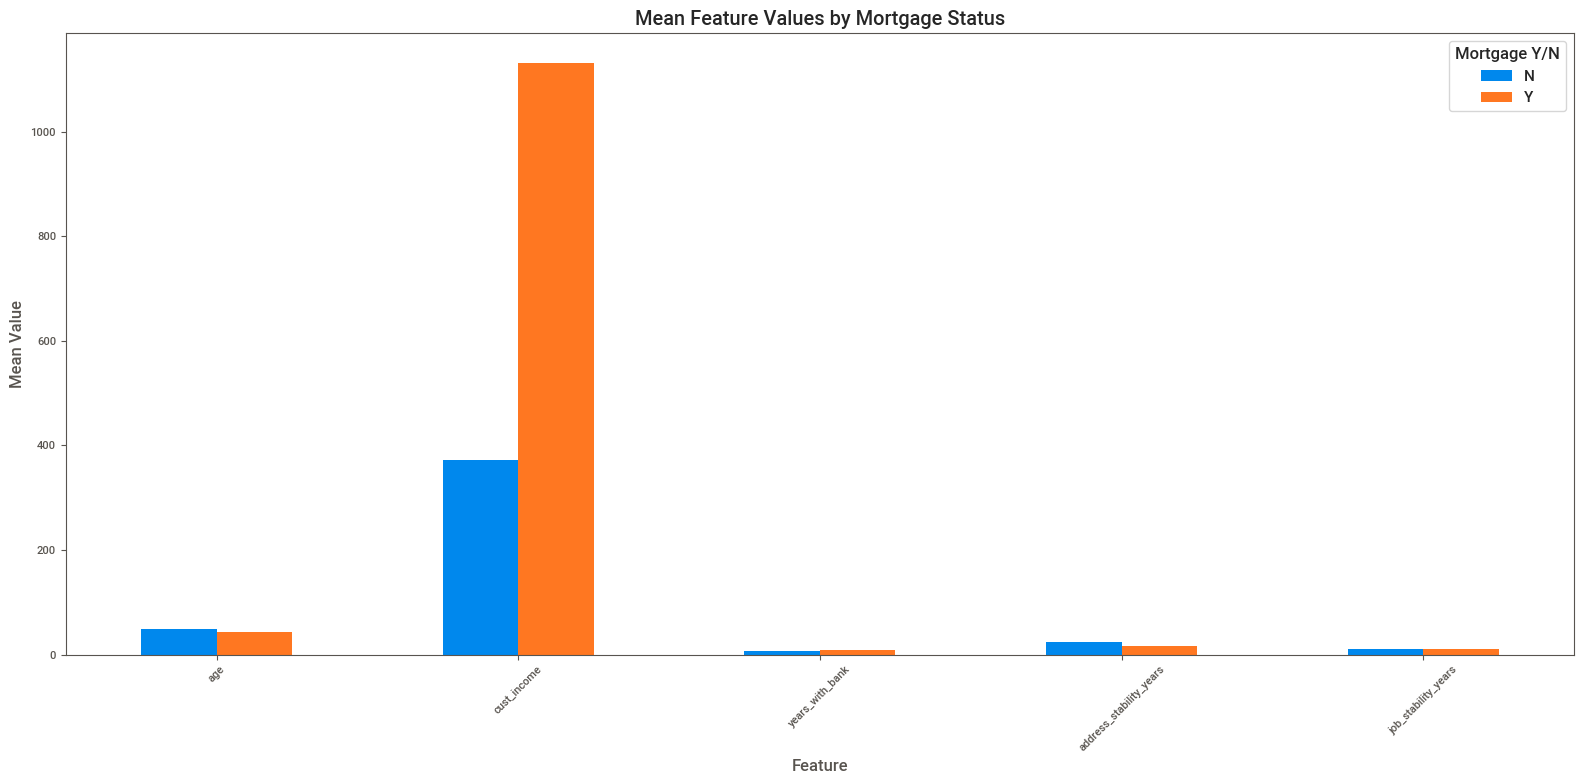

In [56]:
# Bar plot for EDA summary by mortgage
eda_summary.T.plot(kind="bar", title="Mean Feature Values by Mortgage Status")
plt.ylabel("Mean Value")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.legend(title="Mortgage Y/N")
plt.tight_layout()
plt.show()

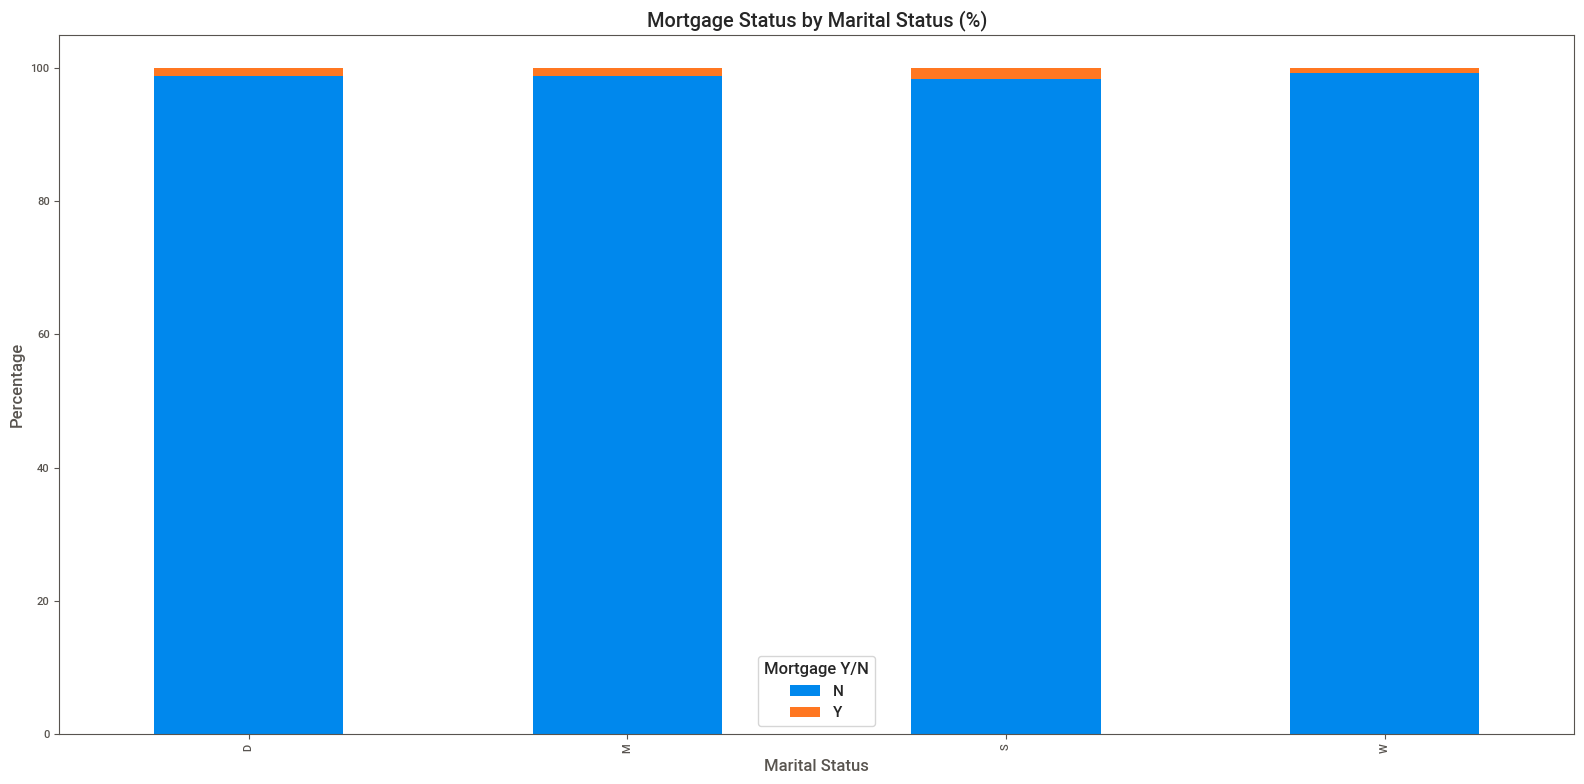

In [57]:
# Stacked bar plot
marital_mortgage.plot(kind="bar", stacked=True)
plt.title("Mortgage Status by Marital Status (%)")
plt.ylabel("Percentage")
plt.xlabel("Marital Status")
plt.legend(title="Mortgage Y/N")
plt.tight_layout()
plt.show()


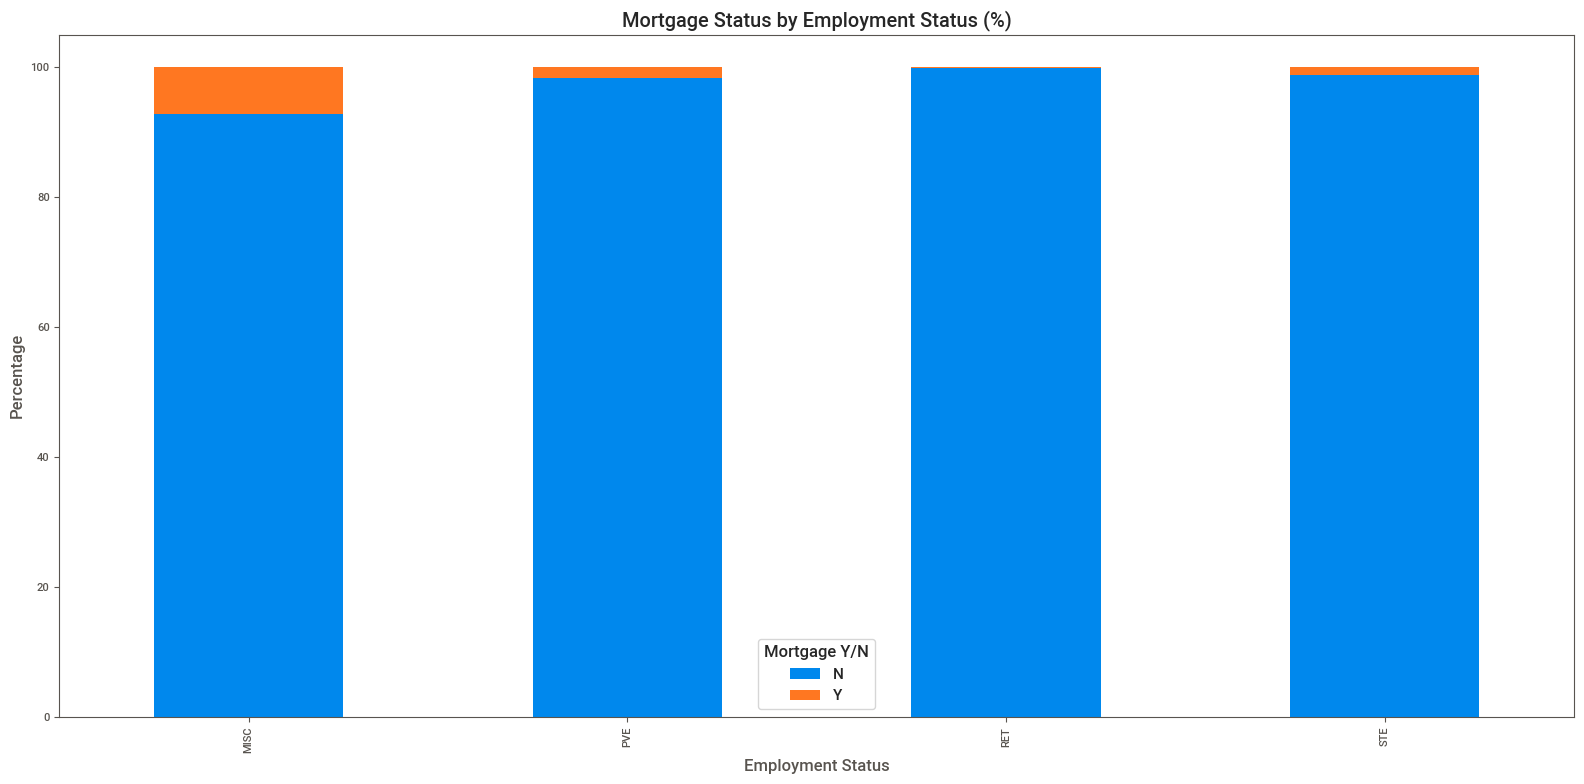

In [58]:
employment_mortgage.plot(kind="bar", stacked=True)
plt.title("Mortgage Status by Employment Status (%)")
plt.ylabel("Percentage")
plt.xlabel("Employment Status")
plt.legend(title="Mortgage Y/N")
plt.tight_layout()
plt.show()

In [59]:
# Map 'mortgage_yn' to binary values
retail_df["mortgage_yn_binary"] = retail_df["mortgage_yn"].map({"Y": 1, "N": 0})

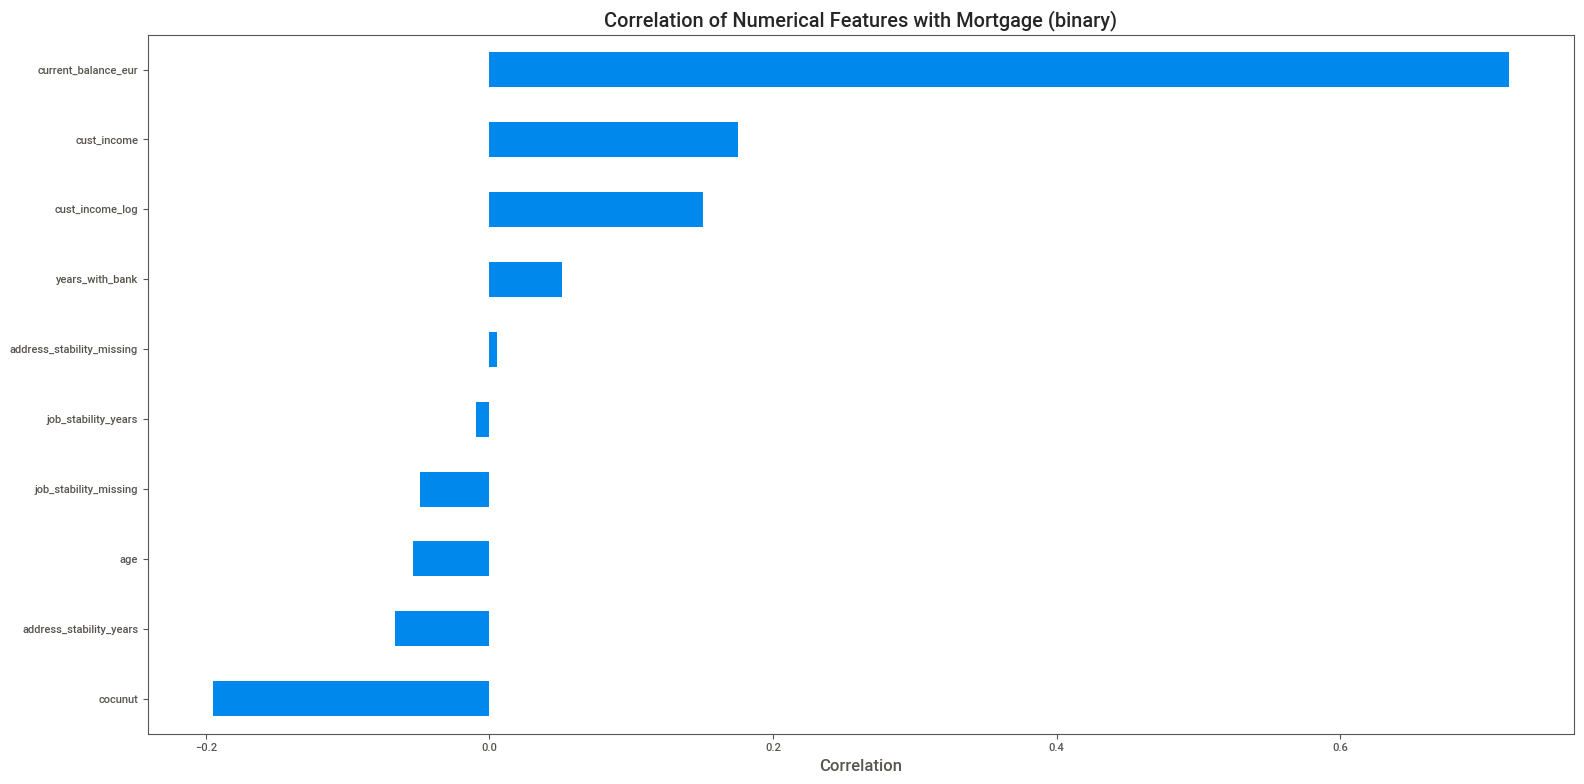

In [60]:
# Copy retail_df since it contains 'mortgage_yn'
df_corr = retail_df.copy()

# Keep only numerical columns
num_cols = df_corr.select_dtypes(include=["number"]).columns.drop("mortgage_yn_binary")

# Compute correlations with the binary mortgage target
mortgage_correlations = df_corr[num_cols].corrwith(df_corr["mortgage_yn_binary"]).sort_values()

# Plot the correlations
mortgage_correlations.plot(kind='barh')
plt.title("Correlation of Numerical Features with Mortgage (binary)")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()

- **cust_income** and **years_with_bank** show positive correlations — indicating that customers with higher income and longer banking relationships are more likely to have a mortgage. 
- **current_balance_eur** shows an unusually high correlation, which may indicate data leakage — it's likely capturing behavior after a mortgage is issued. Therefore, we decided to exclude it from the model.

- **age** and **address_stability_years** are negatively correlated — suggesting that younger and less address-stable individuals are more likely to have a mortgage, likely due to being in earlier life stages such as starting families or careers.

- **cocunut** which is a unique customer ID, has measurable correlation — further supporting the decision to exclude it from modeling.

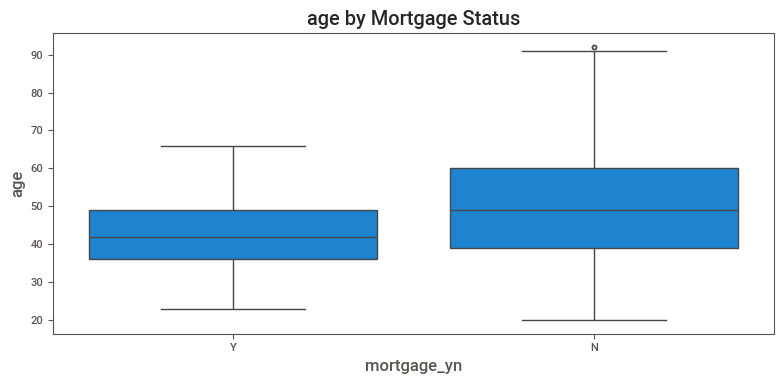

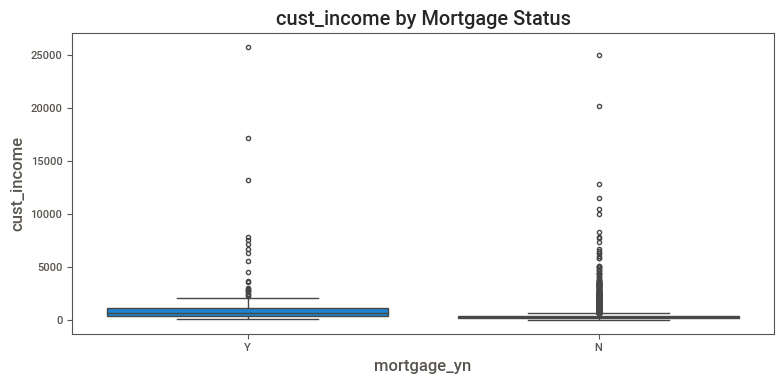

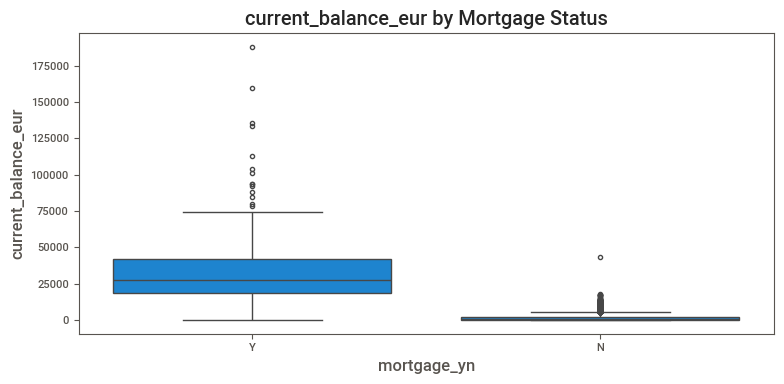

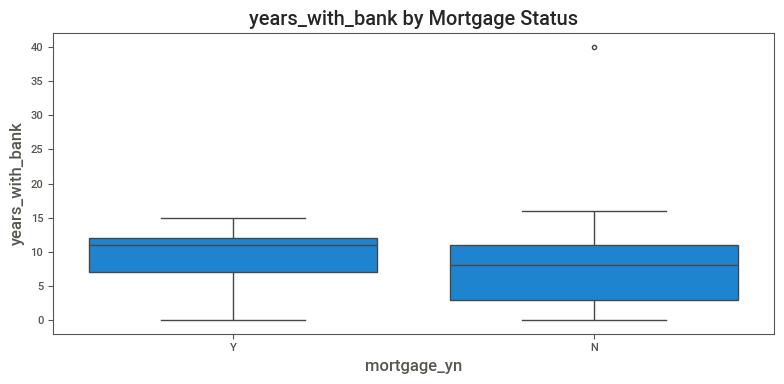

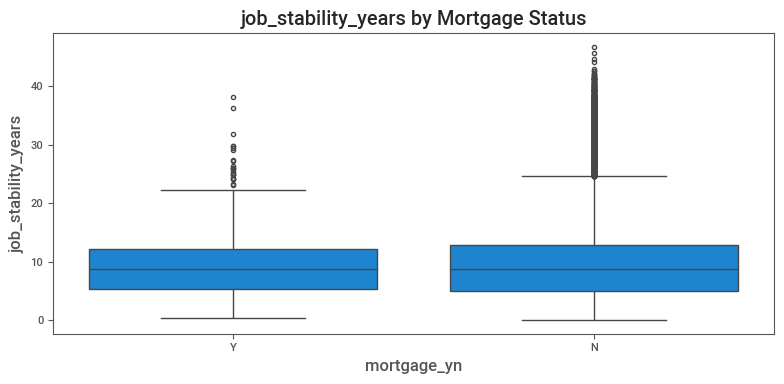

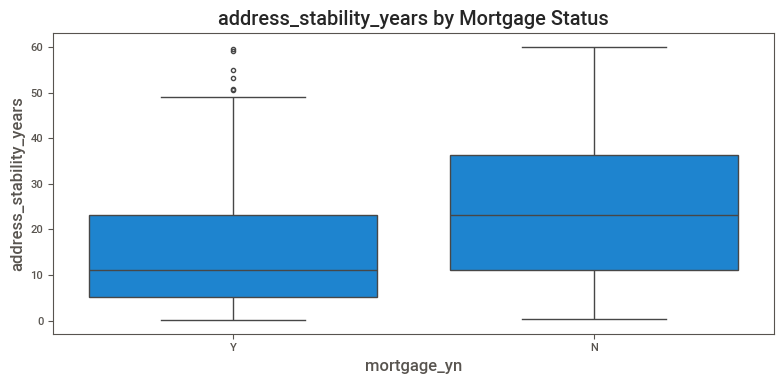

In [61]:
# Split features into numerical and categorical
numeric_features = ["age", "cust_income", "current_balance_eur",
                    "years_with_bank", "job_stability_years", "address_stability_years"]
categorical_features = ["gender", "marital_status", "education", "employment"]

# BIVARIATE ANALYSIS (NUMERIC vs mortgage_yn) — Boxplots
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="mortgage_yn", y=feature, data=retail_df)
    plt.title(f"{feature} by Mortgage Status")
    plt.tight_layout()
    plt.show()

- **Age**

Mortgage holders (Y) are generally younger, centered around 40–45 years.

Non-holders (N) skew older, with a wider spread and higher max values.

This shows younger individuals are more likely to take mortgages.

- **Customer Income (cust_income)**

Clear difference in medians: mortgage holders earn more on average.

More high-income outliers among mortgage holders.

- **Current Balance (current_balance_eur)**

Huge disparity: mortgage holders have much higher balances.

This plot visually confirms the need to exclude this feature.

- **Years With Bank**

Slight shift upward for mortgage holders — higher median.

Not a huge spread difference, but overall a bit more tenure among mortgage customers.

Weak-moderate signal; retained due to business logic.

- **Job Stability (Years)**

Similar distributions between groups — small shift to lower stability for mortgage holders.

Suggests it may not differentiate strongly but adds mild signal when combined with others.

- **Address Stability (Years)**

Big visual difference! Mortgage holders tend to have lower address stability.

Opposite of what we might assume, but it aligns with the idea of them being in transition (buying homes).

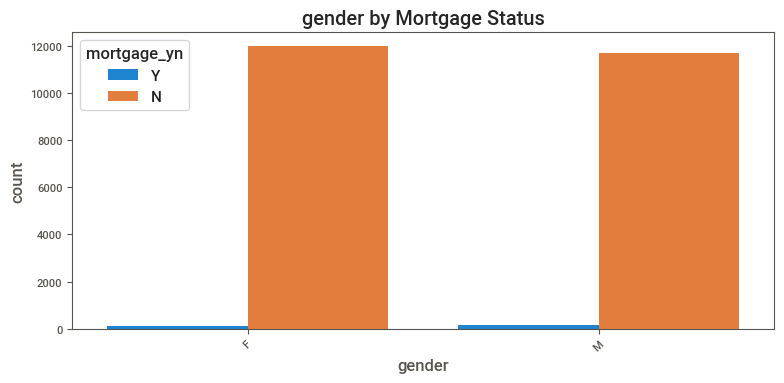

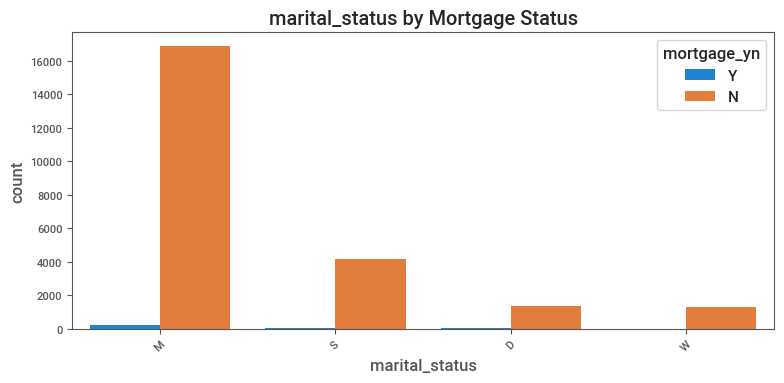

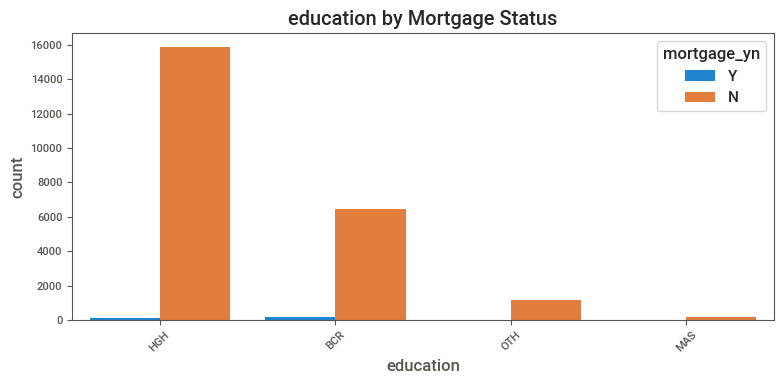

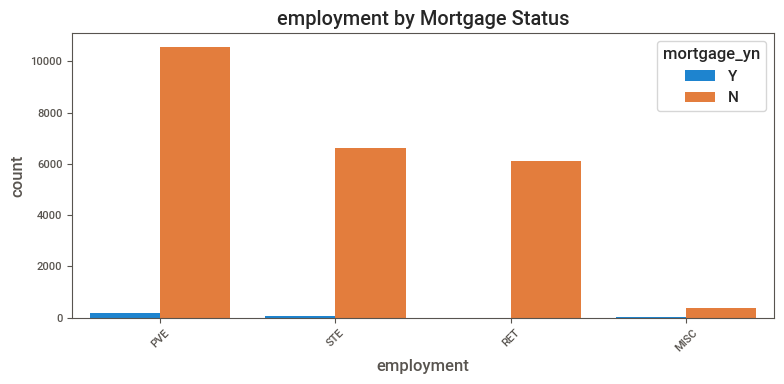

In [62]:
# BIVARIATE ANALYSIS (CATEGORICAL vs mortgage_yn) — Countplots
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=feature, hue="mortgage_yn", data=retail_df,
                  order=retail_df[feature].value_counts().index)
    plt.title(f"{feature} by Mortgage Status")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

1. **Gender**

Nearly equal counts of male and female customers overall.

The proportion of mortgage holders (blue) is similarly low for both genders.

No strong gender bias is evident in mortgage status — useful for fairness check.

2. **Marital Status**

Majority of customers are married (M), but singles (S) seem to have a higher proportion of mortgage holders.

Very few mortgage holders among divorced (D) or widowed (W).

Indicates relationship status may signal life stage: singles entering homeownership.

3. **Education**

Most customers have high school (HGH) or bachelor’s (BCR).

Higher proportions of mortgage holders are visible among BCR and MAS.

Suggests education may reflect earning potential, which links to creditworthiness.

4. **Employment**

Most customers fall under PVE (Private), STE (Self-Employed), RET (Retired).

But mortgage holders are more concentrated in MISC (which might include transitional roles) and slightly in PVE

Some groups are more mortgage-prone.

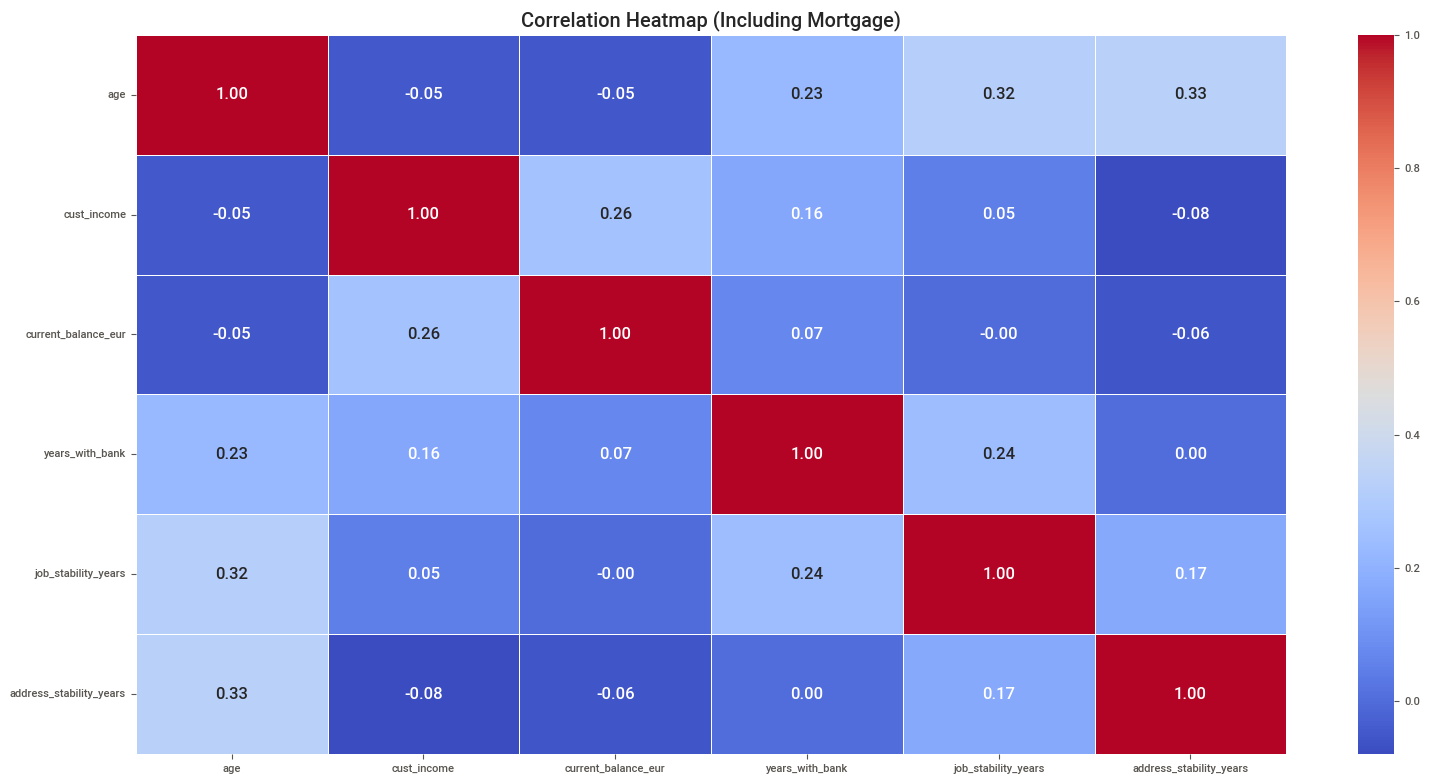

In [63]:
# MULTIVARIATE ANALYSIS — Correlation heatmap
corr_matrix = retail_df[numeric_features + ["mortgage_yn"]].corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Including Mortgage)")
plt.tight_layout()
plt.show()

The heatmap confirms mild positive relationships among age, job stability, and address stability — consistent with real-world expectations. However, overall multicollinearity remains low, with most features being weakly correlated. Notably, cust_income and years_with_bank provide independent signals, supporting their inclusion in the modeling process.

In [64]:
# Chi-square tests between categorical variables and mortgage_yn
categorical_vars = ["gender", "education", "employment", "marital_status"]
chi2_results = {}

for var in categorical_vars:
    contingency = pd.crosstab(retail_df[var], retail_df["mortgage_yn"])
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi2_results[var] = {"chi2_statistic": chi2, "p_value": p, "degrees_of_freedom": dof}

# Age bins: young (18-30), mid (31-50), senior (51+)
retail_df["age_group"] = pd.cut(
    retail_df["age"],
    bins=[17, 30, 50, 100],
    labels=["young", "mid", "senior"]
)

# Income bins: low, medium, high based on quantiles
retail_df["income_group"] = pd.qcut(
    retail_df["cust_income"],
    q=3,
    labels=["low", "medium", "high"]
)

(chi2_results, retail_df[["age", "age_group", "cust_income", "income_group"]].head(10))

({'gender': {'chi2_statistic': 6.973482192573332,
   'p_value': 0.00827263587289746,
   'degrees_of_freedom': 1},
  'education': {'chi2_statistic': 255.2247109014942,
   'p_value': 4.850107375659521e-55,
   'degrees_of_freedom': 3},
  'employment': {'chi2_statistic': 200.37367804603244,
   'p_value': 3.5028414143751764e-43,
   'degrees_of_freedom': 3},
  'marital_status': {'chi2_statistic': 8.84426257881488,
   'p_value': 0.03143478839813189,
   'degrees_of_freedom': 3}},
    age age_group  cust_income income_group
 0   52    senior   909.501308         high
 1   49       mid   288.461539       medium
 2   55    senior  1280.528692         high
 3   66    senior   620.959769         high
 4   47       mid  2239.853846         high
 5   35       mid  1016.004308         high
 6   53    senior   458.609231         high
 7   58    senior   615.384615         high
 8   47       mid   744.007615         high
 9   46       mid   473.818000         high)

- Chi-square tests confirmed statistically significant associations between all categorical features and mortgage status. Education and employment in particular exhibited strong relationships (p < 0.001), further validating their inclusion in the model.
- For exploratory purposes and potential feature engineering, age and income were discretized into ordinal groups. This supported additional insights on mortgage trends by demographic segments, though the continuous versions were retained for tree-based modeling.

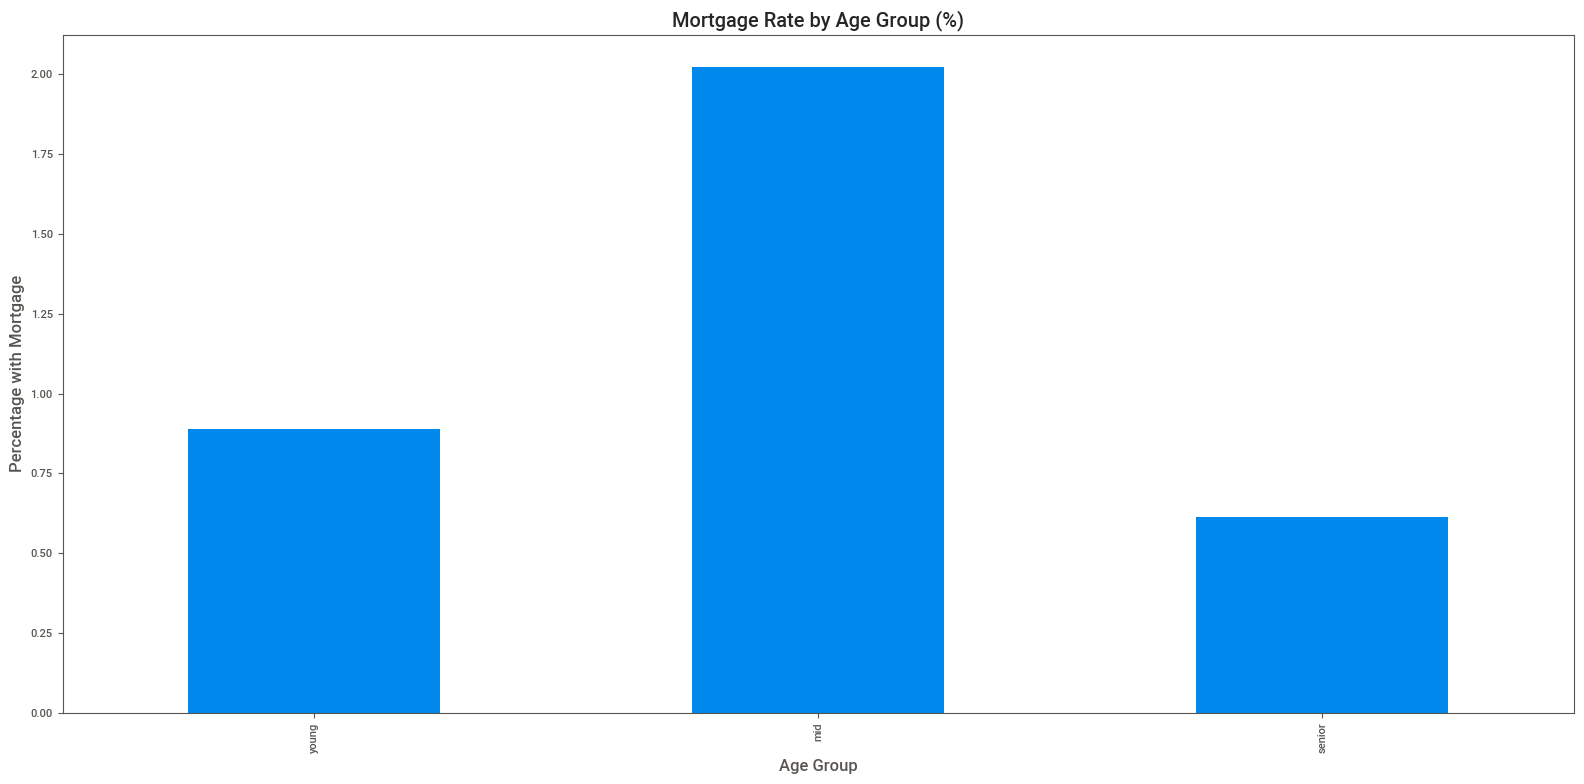

In [65]:
mortgage_by_age_group = (
    retail_df.groupby("age_group")["mortgage_yn_binary"]
    .mean() * 100
)

mortgage_by_age_group.plot(kind="bar", title="Mortgage Rate by Age Group (%)", )
plt.ylabel("Percentage with Mortgage")
plt.xlabel("Age Group")
plt.tight_layout()
plt.show()


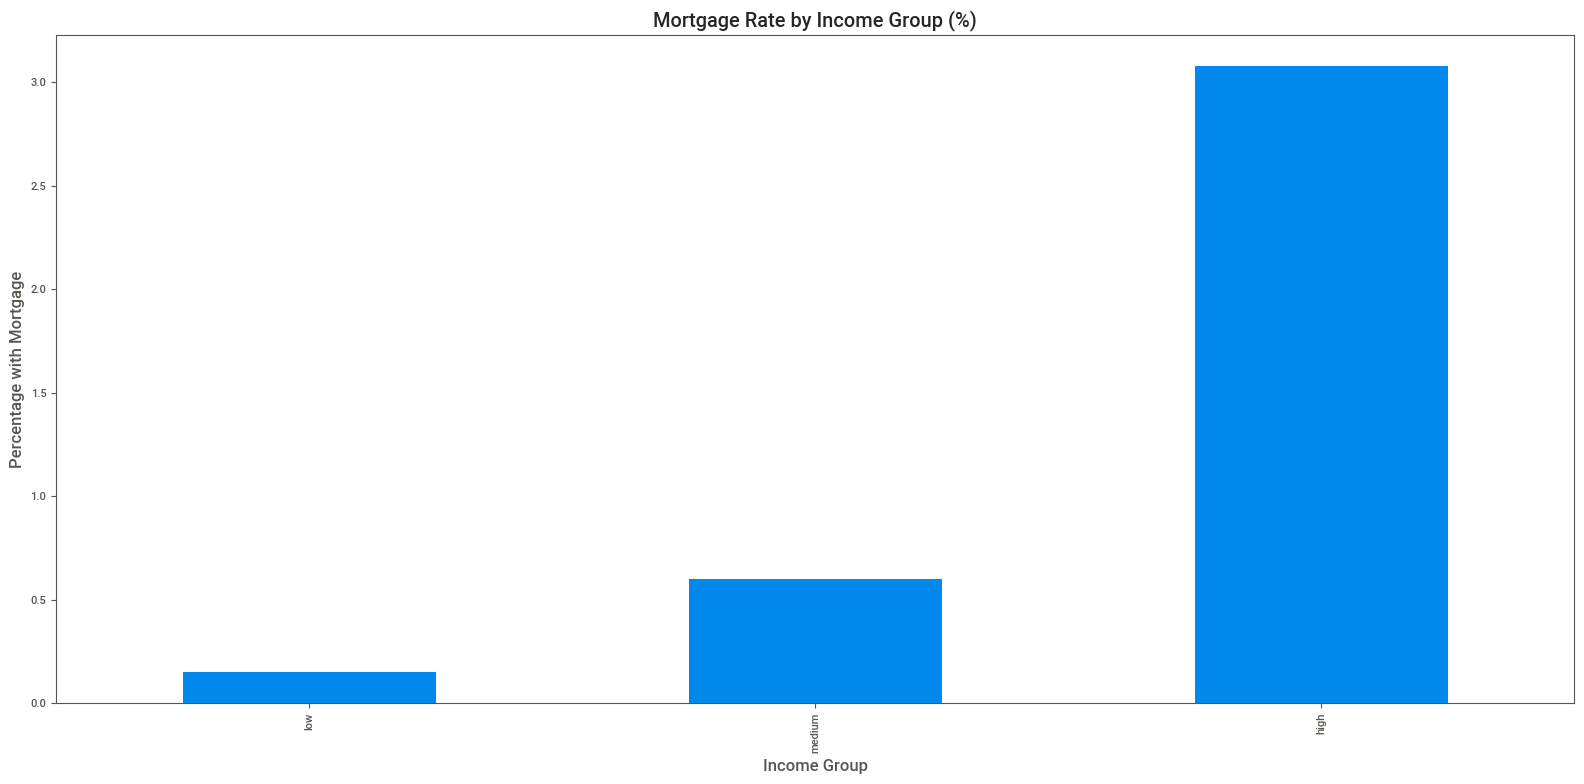

In [66]:
mortgage_by_income_group = (
    retail_df.groupby("income_group")["mortgage_yn_binary"]
    .mean() * 100
)

mortgage_by_income_group.plot(kind="bar", title="Mortgage Rate by Income Group (%)", )
plt.ylabel("Percentage with Mortgage")
plt.xlabel("Income Group")
plt.tight_layout()
plt.show()

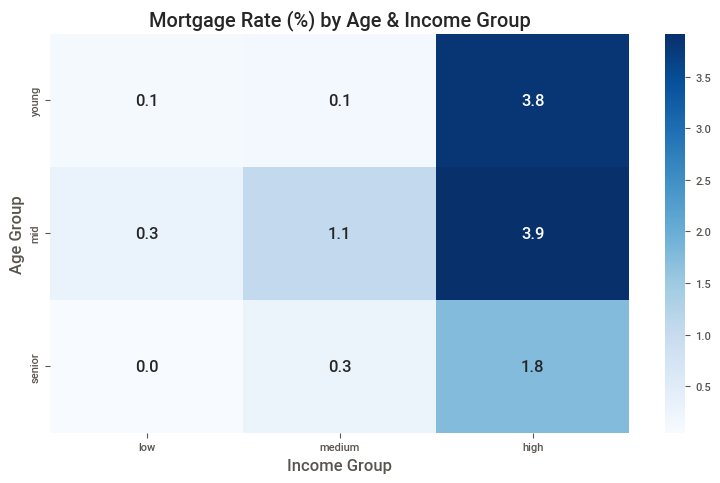

In [67]:
heatmap_data = retail_df.groupby(["age_group", "income_group"])["mortgage_yn_binary"].mean().unstack() * 100

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Blues")
plt.title("Mortgage Rate (%) by Age & Income Group")
plt.ylabel("Age Group")
plt.xlabel("Income Group")
plt.tight_layout()
plt.show()


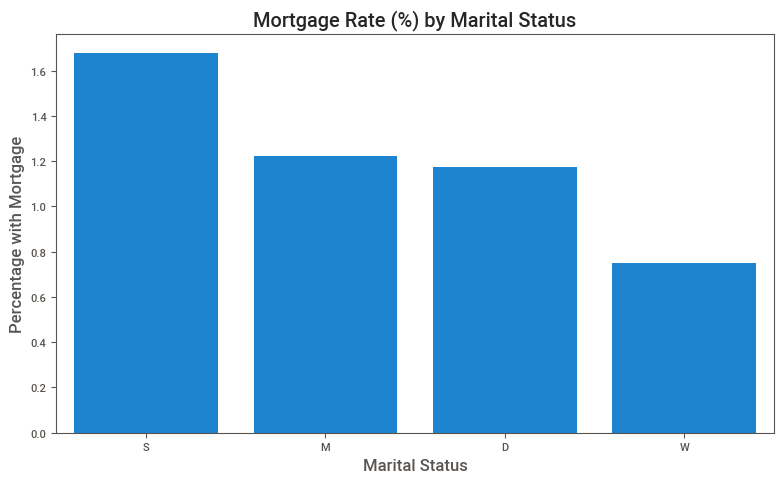

In [68]:
# Mortgage rate by marital status
marital_mortgage_rate = (
    retail_df.groupby("marital_status")["mortgage_yn_binary"]
    .mean()
    .multiply(100)
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 5))
sns.barplot(x=marital_mortgage_rate.index, y=marital_mortgage_rate.values)
plt.title("Mortgage Rate (%) by Marital Status")
plt.ylabel("Percentage with Mortgage")
plt.xlabel("Marital Status")
plt.tight_layout()
plt.show()


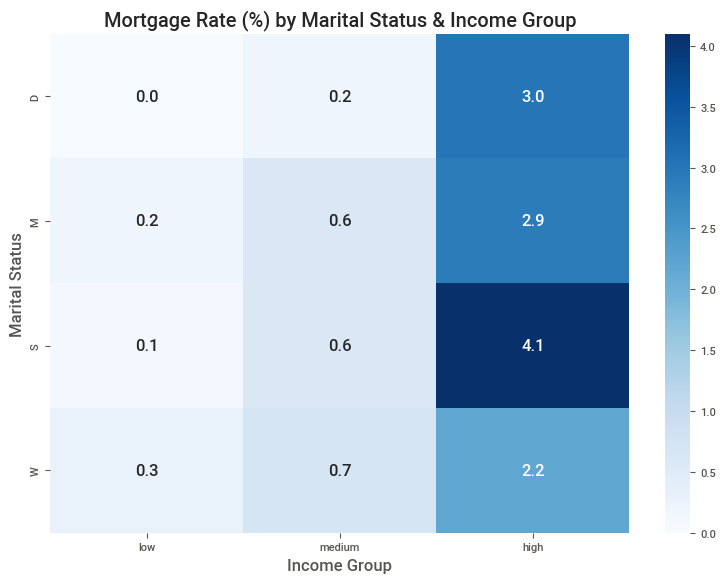

In [69]:
# Create a heatmap for Marital Status vs Income Group
pivot_marital_income = (
    retail_df.pivot_table(
        index="marital_status", 
        columns="income_group", 
        values="mortgage_yn_binary", 
        aggfunc="mean"
    )
    * 100
).round(1)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_marital_income, annot=True, cmap="Blues", fmt=".1f")
plt.title("Mortgage Rate (%) by Marital Status & Income Group")
plt.ylabel("Marital Status")
plt.xlabel("Income Group")
plt.tight_layout()
plt.show()


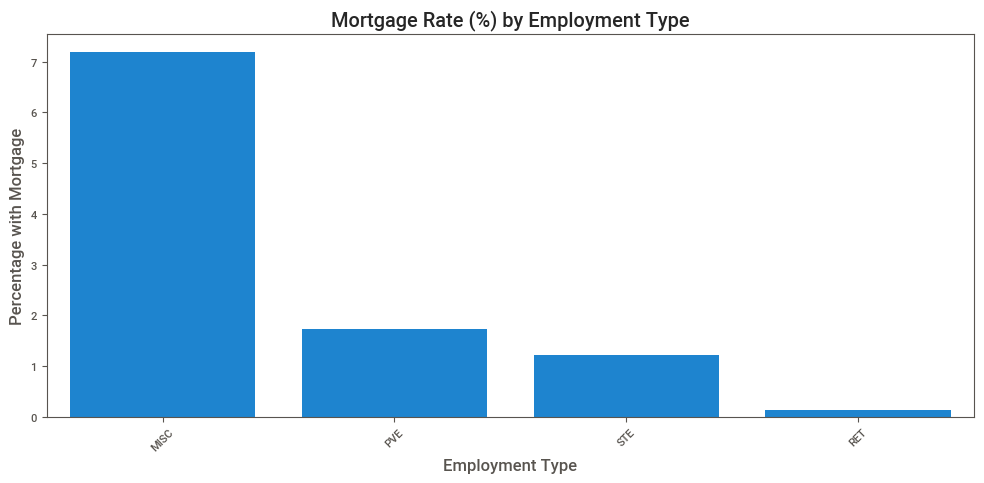

In [70]:
# Mortgage rate by employment type
employment_mortgage_rate = (
    retail_df.groupby("employment")["mortgage_yn_binary"]
    .mean()
    .multiply(100)
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 5))
sns.barplot(x=employment_mortgage_rate.index, y=employment_mortgage_rate.values)
plt.title("Mortgage Rate (%) by Employment Type")
plt.ylabel("Percentage with Mortgage")
plt.xlabel("Employment Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


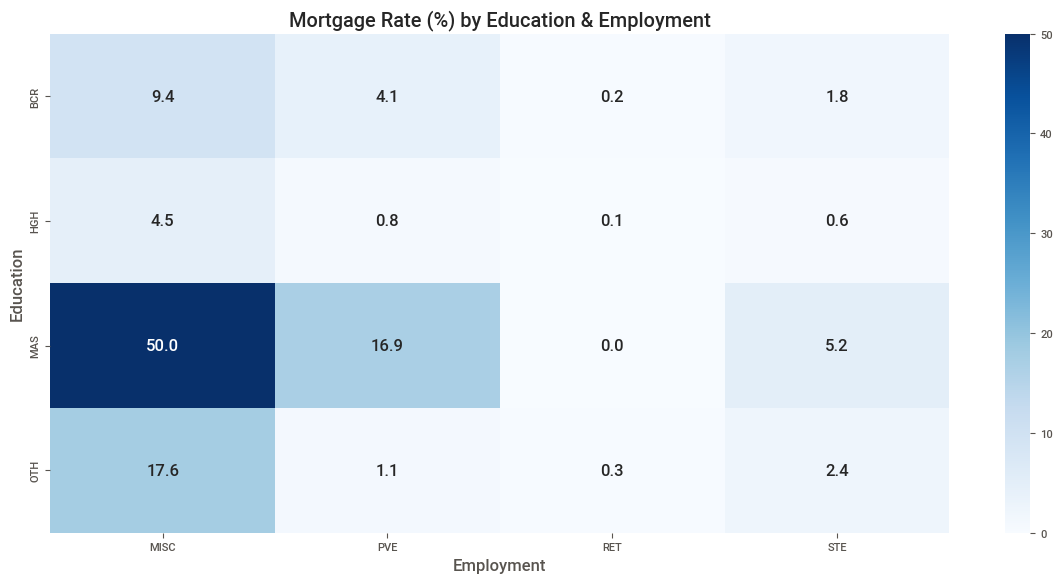

In [71]:
# Mortgage rate by education & employment
pivot_edu_emp = (
    retail_df.pivot_table(
        index="education", 
        columns="employment", 
        values="mortgage_yn_binary", 
        aggfunc="mean"
    )
    * 100
).round(1)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_edu_emp, annot=True, cmap="Blues", fmt=".1f")
plt.title("Mortgage Rate (%) by Education & Employment")
plt.ylabel("Education")
plt.xlabel("Employment")
plt.tight_layout()
plt.show()


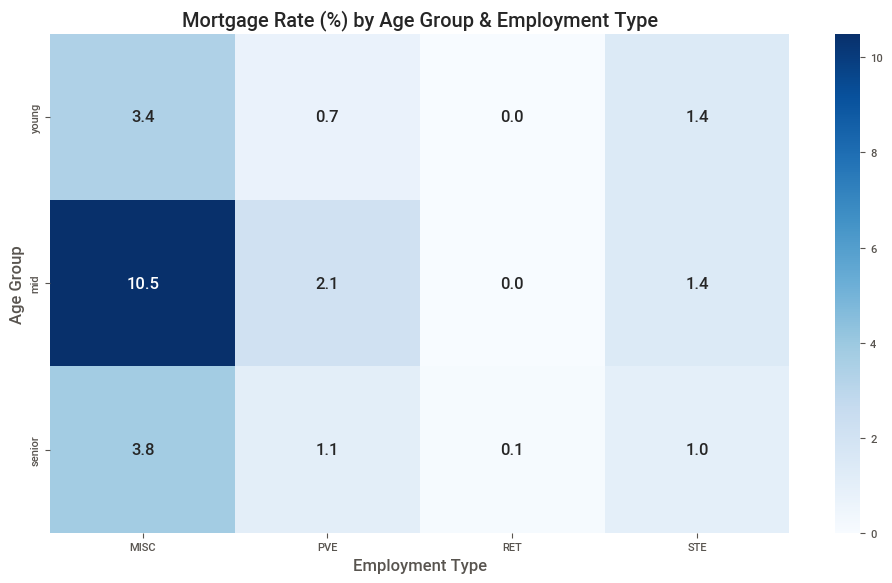

In [72]:
# Crosstab: Age Group × Employment Type
age_emp = pd.crosstab(
    index=retail_df["age_group"],
    columns=retail_df["employment"],
    values=retail_df["mortgage_yn_binary"],
    aggfunc=lambda x: round(100 * sum(x) / len(x), 1)
).fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(age_emp, annot=True, fmt=".1f", cmap="Blues")
plt.title("Mortgage Rate (%) by Age Group & Employment Type")
plt.ylabel("Age Group")
plt.xlabel("Employment Type")
plt.tight_layout()
plt.show()

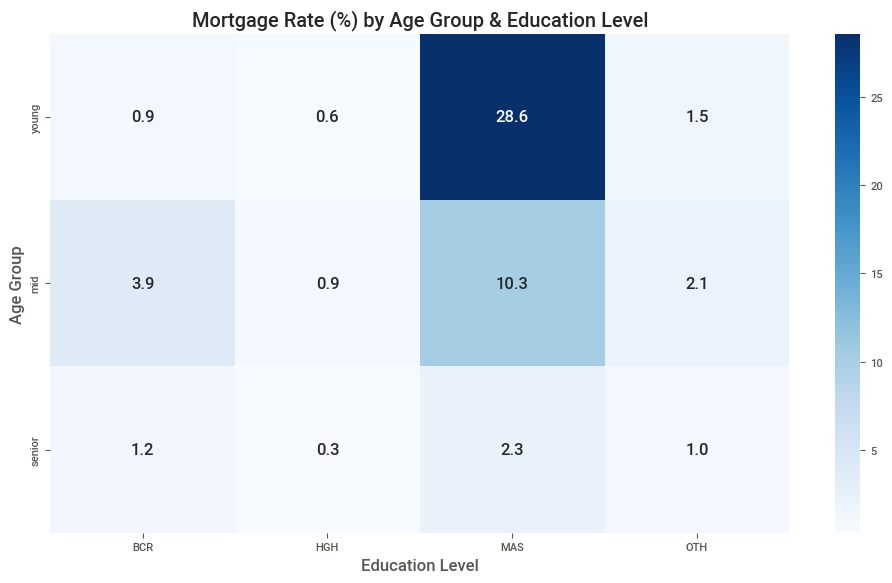

In [73]:
# Crosstab: Age Group × Education
age_edu = pd.crosstab(
    index=retail_df["age_group"],
    columns=retail_df["education"],
    values=retail_df["mortgage_yn_binary"],
    aggfunc=lambda x: round(100 * sum(x) / len(x), 1)
).fillna(0)

plt.figure(figsize=(10, 6))
sns.heatmap(age_edu, annot=True, fmt=".1f", cmap="Blues")
plt.title("Mortgage Rate (%) by Age Group & Education Level")
plt.ylabel("Age Group")
plt.xlabel("Education Level")
plt.tight_layout()
plt.show()

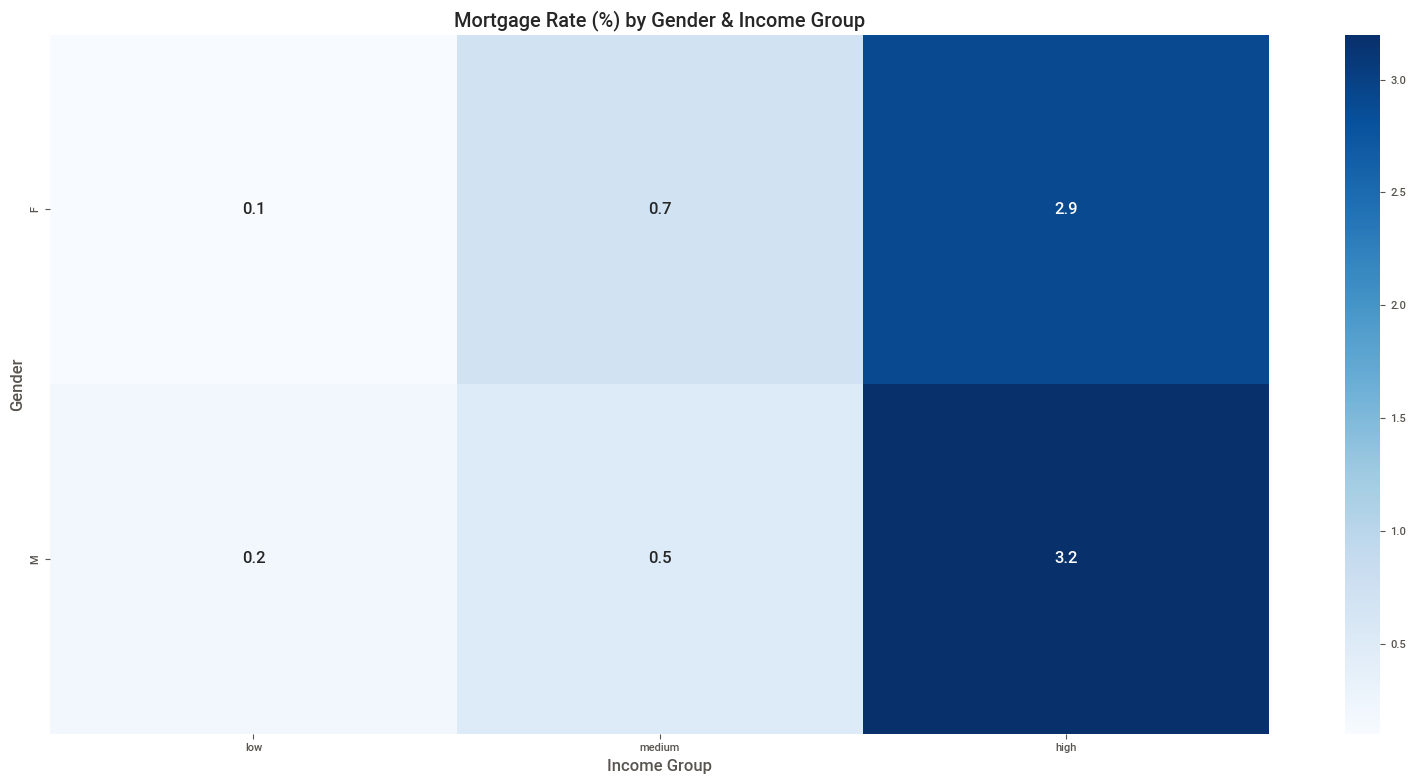

In [74]:
# Crosstab: Gender × Income Group
gender_income = pd.crosstab(
    index=retail_df["gender"],
    columns=retail_df["income_group"],
    values=retail_df["mortgage_yn_binary"],
    aggfunc=lambda x: round(100 * sum(x) / len(x), 1)
).fillna(0)

sns.heatmap(gender_income, annot=True, fmt=".1f", cmap="Blues")
plt.title("Mortgage Rate (%) by Gender & Income Group")
plt.ylabel("Gender")
plt.xlabel("Income Group")
plt.tight_layout()
plt.show()

**Insights:**

1. **Age & Mortgage Propensity**

Mid-aged customers have the highest mortgage rate (~2%) compared to young and senior groups.

This aligns with expectations, as people in their 30s-50s are more likely to be taking out mortgages.

2. **Customer Income**

There is a strong positive relationship between income and mortgage rates:

High-income customers have a mortgage rate of over 3%.

In contrast, the low-income group has a rate below 0.2%.

This reinforces the idea that income is a strong predictor.

3. **Marital Status**

Single (S) individuals have a slightly higher rate (~1.7%) than Married (M) (~1.2%) or Divorced (D) (~1.2%), while Widowed (W) have the lowest (~0.75%).

Chi-square test confirmed significant dependency between marital status and mortgage outcome (p = 0.03).

4. **Employment Type**

Customers in MISC (miscellaneous/other) employment types have the highest mortgage rate (7.2%).

Private (PVE) and State (STE) employees are much lower (~1.3%–1.7%), while retirees (RET) have the lowest (~0.1%).

Strong chi-squared significance (p < 1e-40) suggests employment status adds predictive value.

5. **Education**

Customers with a Master's degree (MAS) show extremely high mortgage uptake rates (up to 50% in MISC employment).

BCR and OTH also show variability by employment type.

The variable is significant, as seen from the chi-squared test (p < 1e-50).

6. **Interaction Effects**

Heatmaps show:

- High income and mid-age are jointly very predictive (mortgage rates 3.8%–3.9%).

- Education + Employment interaction is crucial — e.g., MAS + MISC = 50% mortgage rate.

- Certain combinations (e.g., young + MAS) are also strong predictors.

In [75]:
def run_chi_squared_test_safe(df, row_var, col_var, target_var="mortgage_yn_binary"):
    # Create contingency table (summing mortgage presence by group)
    contingency = pd.crosstab(index=df[row_var], columns=df[col_var], values=df[target_var], aggfunc='sum').fillna(0)

    # Chi-Squared Test
    chi2, p, dof, expected = chi2_contingency(contingency)

    print(f"Chi-Squared Test for {row_var} vs {col_var}")
    print(f"Chi2 statistic = {chi2:.4f}, p-value = {p:.4f}, dof = {dof}")
    if p < 0.05:
        print("→ Statistically significant relationship (reject H0)")
    else:
        print("→ No statistically significant relationship (fail to reject H0)")
    print("-" * 60)

# Run tests
run_chi_squared_test_safe(retail_df, "age_group", "employment")
run_chi_squared_test_safe(retail_df, "age_group", "education")
run_chi_squared_test_safe(retail_df, "gender", "income_group")
run_chi_squared_test_safe(retail_df, "marital_status", "income_group")
run_chi_squared_test_safe(retail_df, "education", "employment")

Chi-Squared Test for age_group vs employment
Chi2 statistic = 41.1326, p-value = 0.0000, dof = 6
→ Statistically significant relationship (reject H0)
------------------------------------------------------------
Chi-Squared Test for age_group vs education
Chi2 statistic = 20.3194, p-value = 0.0024, dof = 6
→ Statistically significant relationship (reject H0)
------------------------------------------------------------
Chi-Squared Test for gender vs income_group
Chi2 statistic = 4.2094, p-value = 0.1219, dof = 2
→ No statistically significant relationship (fail to reject H0)
------------------------------------------------------------
Chi-Squared Test for marital_status vs income_group
Chi2 statistic = 13.0440, p-value = 0.0423, dof = 6
→ Statistically significant relationship (reject H0)
------------------------------------------------------------
Chi-Squared Test for education vs employment
Chi2 statistic = 9.6487, p-value = 0.3797, dof = 9
→ No statistically significant relationship (

**Insights:**

- Strong Associations:

**Age Group ↔ Employment** and **Age Group ↔ Education**: These relationships are statistically significant, suggesting age plays a key role in influencing both job type and education level.

**Marital Status ↔ Income Group**: Although weaker, this relationship is still statistically significant, implying that marital status may affect income distribution or vice versa.

- No Clear Association:

**Gender ↔ Income Group**: No statistically significant association observed. This may suggest that gender alone doesn't impact income level in this dataset.

**Education ↔ Employment**: Surprisingly, these two variables don't show a significant relationship. This could imply that career paths in this population are not strongly dictated by education level.

## 6. Model Building & Evaluation

In [76]:
retail_df.columns

Index(['cocunut', 'mortgage_yn', 'age', 'years_with_bank', 'marital_status',
       'education', 'employment', 'gender', 'cust_income',
       'current_with_bank_date', 'current_balance_eur', 'job_stability_years',
       'address_stability_years', 'job_stability_missing',
       'address_stability_missing', 'cust_income_log', 'mortgage_yn_binary',
       'age_group', 'income_group'],
      dtype='object')

In [77]:
common_columns = list(set(retail_df.columns) & set(potential_df.columns))

# Print common columns
print("Common columns:", common_columns)

Common columns: ['current_with_bank_date', 'gender', 'address_stability_years', 'marital_status', 'education', 'cocunut', 'years_with_bank', 'address_stability_missing', 'job_stability_missing', 'employment', 'cust_income', 'age', 'current_balance_eur', 'job_stability_years', 'cust_income_log']


In [78]:
retail_df["mortgage_yn_binary"].value_counts()

mortgage_yn_binary
0    23677
1      306
Name: count, dtype: int64

In [ ]:
features = [
    'age',
    'years_with_bank',
    'marital_status',         
    'education',              
    'employment',             
    'gender',                 
    'job_stability_years',
    'address_stability_years',
    'job_stability_missing',
    'address_stability_missing',
    'cust_income_log'
]

In [80]:
# Split categorical and numerical
numeric_cols = [
    'age', 'years_with_bank', 'job_stability_years',
    'address_stability_years', 'job_stability_missing',
    'address_stability_missing', 'cust_income_log'
]

categorical_cols = ['marital_status', 'education', 'employment', 'gender']

In [81]:
# Full input features to RFE
all_features = categorical_cols + numeric_cols

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# RFE pipeline
estimator = RandomForestClassifier(n_estimators=100, random_state=42)
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rfe', RFE(estimator, n_features_to_select=8))
])

# Fit pipeline on final_retail_encoded data
pipeline.fit(retail_df[all_features], retail_df["mortgage_yn_binary"])

# Extract selected features
all_transformed = pipeline.named_steps['preprocessing'].get_feature_names_out()
selected_mask = pipeline.named_steps['rfe'].support_
selected_features = all_transformed[selected_mask]
print("Selected RFE features:\n", selected_features)

Selected RFE features:
 ['cat__marital_status_M' 'cat__employment_PVE' 'cat__gender_M'
 'remainder__age' 'remainder__years_with_bank'
 'remainder__job_stability_years' 'remainder__address_stability_years'
 'remainder__cust_income_log']


Using RFE for feature selection with a Random Forest classifier, we selected 8 features that collectively offer the strongest predictive signal while minimizing noise and redundancy. This set combines demographic, financial, and stability-related variables, ensuring a balanced and interpretable model foundation.

In [82]:
# Transform retail_df with the RFE pipeline
X_transformed = pipeline.named_steps['preprocessing'].transform(retail_df[all_features])
X_selected = X_transformed[:, selected_mask]
y = retail_df["mortgage_yn_binary"]

# Scale selected features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Handle imbalance for XGBoost/CatBoost
neg, pos = np.bincount(y)
scale_pos_weight = neg / pos

# Define models
models = {
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(
        eval_metric='logloss',
        objective="binary:logistic",
        scale_pos_weight=scale_pos_weight,
        random_state=42
    ),
    "CatBoost": CatBoostClassifier(
        scale_pos_weight=scale_pos_weight,
        verbose=0,
        random_state=42
    )
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    roc_scores, pr_scores = [], []

    for train_idx, val_idx in cv.split(X_scaled, y):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # SMOTE on training set only
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_train, y_train)

        model.fit(X_res, y_res)
        y_pred = model.predict_proba(X_val)[:, 1]

        roc_scores.append(roc_auc_score(y_val, y_pred))
        pr_scores.append(average_precision_score(y_val, y_pred))

    results.append({
        "Model": name,
        "ROC AUC (Mean)": np.mean(roc_scores),
        "PR AUC (Mean)": np.mean(pr_scores)
    })

# Output results
results_df = pd.DataFrame(results)
print(results_df)

          Model  ROC AUC (Mean)  PR AUC (Mean)
0  RandomForest        0.813894       0.062622
1       XGBoost        0.754101       0.048689
2      CatBoost        0.828857       0.076578


- CatBoost is the most suitable model here — it performs best in both ranking and precision-recall tradeoff. This is especially important in imbalanced classification tasks where PR AUC is a better indicator of performance on the minority class.
- RandomForest is a solid performer, but its lower PR AUC suggests that it may produce more false positives at the decision threshold — a risk when selecting high-confidence leads.
- XGBoost performs worse in both metrics, and might not be ideal for this use case without additional tuning, calibration, or feature engineering.
- We choose CatBoost as the final model.

### Hyperparameter Tuning

In [83]:
def objective_catboost(trial):
    # Sample hyperparameters
    params = {
        "iterations": trial.suggest_int("iterations", 100, 500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "scale_pos_weight": scale_pos_weight,
        "verbose": 0,
        "random_state": 42
    }

    model = CatBoostClassifier(**params)
    
    # Cross-validation with SMOTE
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pr_scores = []

    for train_idx, val_idx in cv.split(X_scaled, y):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_train, y_train)

        model.fit(X_res, y_res)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        pr_auc = average_precision_score(y_val, y_pred_proba)
        pr_scores.append(pr_auc)

    return np.mean(pr_scores)

In [85]:
# Run the Optimization
study = optuna.create_study(direction="maximize", study_name="catboost_pr_auc")
study.optimize(objective_catboost, n_trials=30, timeout=900, catch=(FloatingPointError,)) 

[I 2025-05-17 17:34:13,161] A new study created in memory with name: catboost_pr_auc
[I 2025-05-17 17:35:25,536] Trial 0 finished with value: 0.09078479957635871 and parameters: {'iterations': 225, 'depth': 10, 'learning_rate': 0.01658655067405888, 'l2_leaf_reg': 2.74045443406769, 'random_strength': 0.0011141091957237459, 'bagging_temperature': 0.843616029357225, 'border_count': 79}. Best is trial 0 with value: 0.09078479957635871.
[I 2025-05-17 17:37:14,821] Trial 1 finished with value: 0.09513044242457054 and parameters: {'iterations': 490, 'depth': 7, 'learning_rate': 0.004577562035123861, 'l2_leaf_reg': 1.5341725215171405, 'random_strength': 5.823937995567345, 'bagging_temperature': 0.08271979670168161, 'border_count': 208}. Best is trial 1 with value: 0.09513044242457054.
[I 2025-05-17 17:37:41,429] Trial 2 finished with value: 0.05304262946857592 and parameters: {'iterations': 250, 'depth': 4, 'learning_rate': 0.0010572387512933737, 'l2_leaf_reg': 7.42187445440773, 'random_streng

In [86]:
# View results
print("Best PR AUC score:", study.best_value)
print("Best hyperparameters:")
for key, val in study.best_params.items():
    print(f"  {key}: {val}")

Best PR AUC score: 0.0985548436469441
Best hyperparameters:
  iterations: 278
  depth: 5
  learning_rate: 0.003934681264835867
  l2_leaf_reg: 2.7108457562726107
  random_strength: 1.028054498196597
  bagging_temperature: 0.8353217879096189
  border_count: 132


- We’ve achieved a solid 28.7% improvement in PR AUC (0.0766 → 0.0986), which is significant in an imbalanced classification setting.

In [87]:
# Refit the best model with the best parameters
best_model = CatBoostClassifier(
    **study.best_params,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    verbose=0
)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)
best_model.fit(X_res, y_res)

In [113]:
# Predict probabilities
y_probs = best_model.predict_proba(X_scaled)[:, 1]

# Compute PR curve
precisions, recalls, thresholds = precision_recall_curve(y, y_probs)

# Compute F1 scores (exclude the last precision/recall point to match threshold shape)
f1s = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-6)

# Find best index based on F1
best_idx = f1s[:-1].argmax()
best_threshold = thresholds[best_idx]
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]
best_f1 = f1s[best_idx]

# Print values
print(f"Best threshold by F1: {best_threshold:.3f}")
print(f"Precision: {best_precision:.3f}, Recall: {best_recall:.3f}, F1: {best_f1:.3f}")
print(f"ROC AUC: {roc_auc_score(y, y_probs):.3f}")
print(f"PR AUC: {average_precision_score(y, y_probs):.3f}")

Best threshold by F1: 0.969
Precision: 0.138, Recall: 0.275, F1: 0.184
ROC AUC: 0.873
PR AUC: 0.108


- Threshold (0.969)
The model only predicts "Yes (1)" for very high confidence probabilities ≥ 0.969.

This is typical in highly imbalanced settings — since the model is cautious about assigning the rare positive class (mortgage takers).

- Precision (13.8%)
Out of all predicted positives, only 13.8% were true positives.

Still much better than the baseline rate (~1.3%) — so this threshold is helping narrow down a useful candidate list.

- Recall (27.5%)
Out of all actual positives, the model recovers ~27.5%.

That means we’re catching roughly 1 in 4 actual mortgage customers at this threshold.

- F1 Score (18.4%)
Balances the tradeoff between precision and recall. In an imbalanced setting, this is a reasonable value — much better than random guessing.

- ROC AUC: 0.873
The model ranks positive instances (mortgage customers) well above negatives.

A value above 0.85 is generally considered excellent, especially with tabular, imbalanced data.

However, ROC AUC can sometimes be overly optimistic in imbalanced settings because it accounts for true negatives.

- PR AUC: 0.108
More appropriate for our task (since only ~1.3% have mortgages).

Baseline PR AUC (random guessing) is ~0.013 → our model is performing ~8× better than chance.

This confirms that our model is learning meaningful signals, and not just overfitting or guessing.

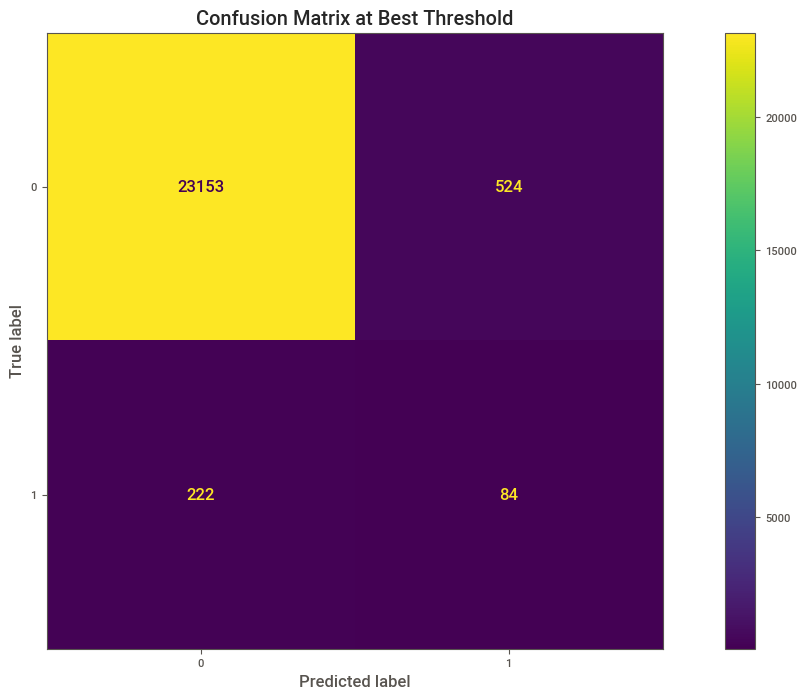

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix at Best Threshold")
plt.show()

- The model is highly conservative at threshold 0.969 — only 84 positives are predicted out of nearly 24,000 samples.

- Precision is significantly improved over random guessing (13.8% vs. 1.3%), meaning this shortlist of 84 customers is very likely to include true mortgage takers.

- Recall is moderate (27.5%) — we’re catching only 1 in 4 real mortgage customers.

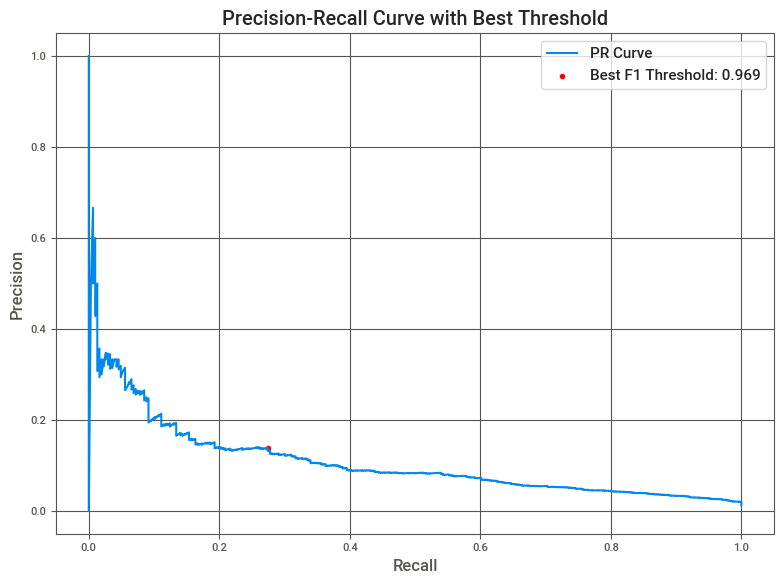

In [112]:
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="PR Curve")
plt.scatter(recalls[best_idx], precisions[best_idx], color="red", label=f"Best F1 Threshold: {best_threshold:.3f}")
plt.title("Precision-Recall Curve with Best Threshold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

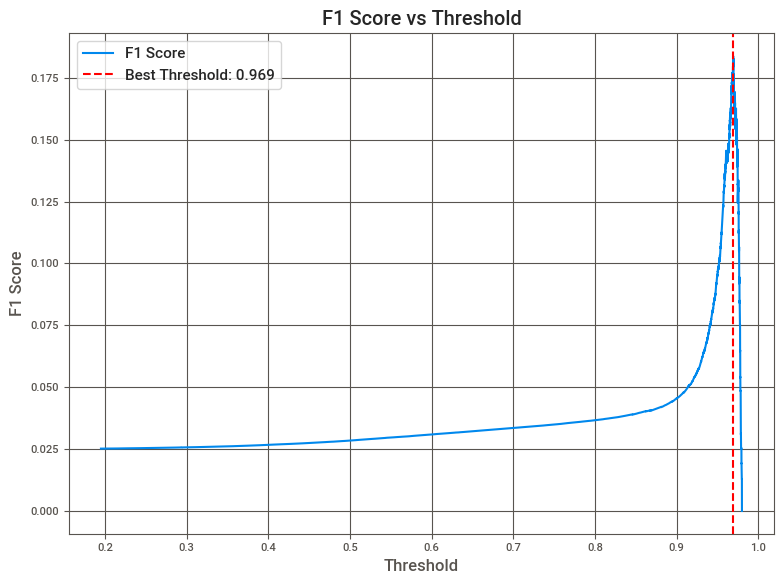

In [91]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1s[:-1], label="F1 Score")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best Threshold: {best_threshold:.3f}")
plt.title("F1 Score vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

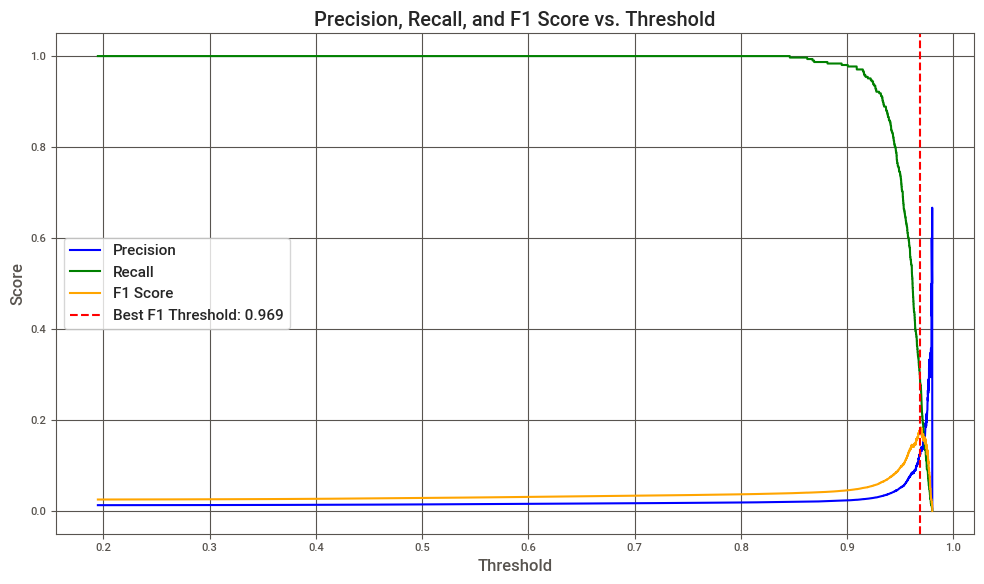

In [ ]:
# Get PR curve
precisions, recalls, thresholds = precision_recall_curve(y_true=y, probas_pred=y_probs)
f1s = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-6)
thresholds = thresholds 

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precision', color='blue')
plt.plot(thresholds, recalls[:-1], label='Recall', color='green')
plt.plot(thresholds, f1s, label='F1 Score', color='orange')
plt.axvline(x=0.969, color='red', linestyle='--', label='Best F1 Threshold: 0.969')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- We evaluated three classifiers — RandomForest, XGBoost, and CatBoost — using Stratified K-Fold cross-validation to ensure stable results across class distributions.

- The target variable mortgage_yn_binary is highly imbalanced:

0 (No Mortgage): 23,677 customers (98.7%)

1 (Mortgage): 306 customers (1.3%)

- Given this extreme imbalance, we emphasized:

ROC AUC: overall ranking quality

PR AUC: precision-recall tradeoff focused on the rare positive class

- All models ranked well on ROC AUC, but this metric can be overly optimistic in imbalanced settings.

- PR AUC is more informative here — the baseline PR AUC is ~0.013 (equal to the positive class prevalence: 306 / 23,983).

- CatBoost exceeds this baseline, offering signal beyond random guessing.

**We Chose CatBoost**

- Best ROC AUC and PR AUC

- Capable of handling skewed distributions (scale_pos_weight)

- Handles categorical features natively

- Stable performance across folds

**Final Note:**

While PR AUC values may appear low, they are expected in datasets where the positive class makes up only 1.3%. The improvement over the baseline demonstrates that the model is capturing useful patterns and can support high-precision targeting when calibrated.

### Calibration

In [ ]:
# Wrap CatBoost model
calibrated_model = CalibratedClassifierCV(estimator=best_model, method='isotonic', cv=StratifiedKFold(n_splits=5))

# Re-fit on full dataset 
calibrated_model.fit(X_scaled, y)

# Predict calibrated probabilities
y_probs_calibrated = calibrated_model.predict_proba(X_scaled)[:, 1]

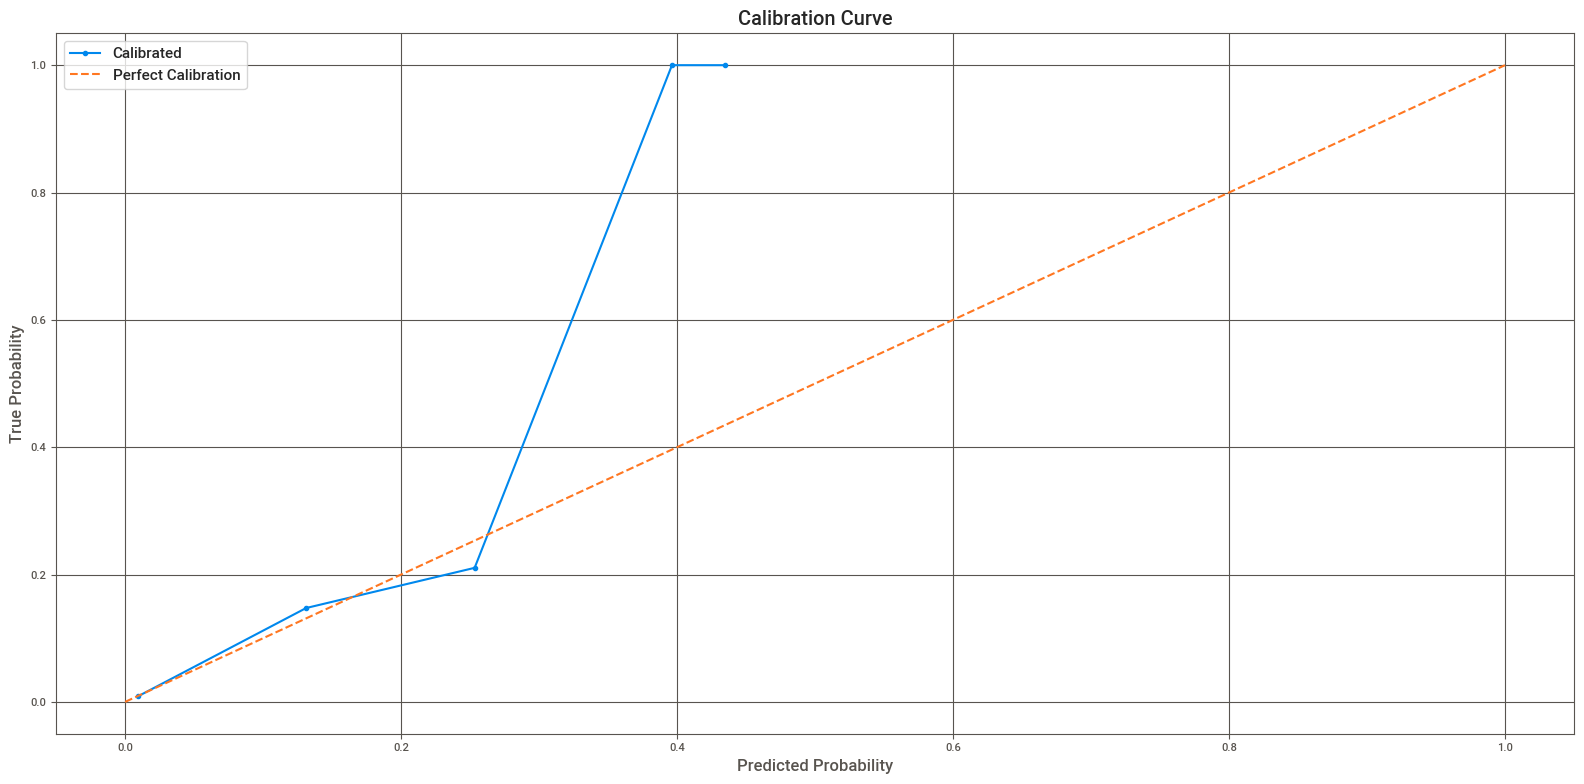

In [ ]:
prob_true, prob_pred = calibration_curve(y, y_probs_calibrated, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- Low-probability predictions (left side):

Up to ~0.25, the calibrated probabilities closely follow the ideal line → model is well-calibrated for lower probability bins.

This is especially useful when scoring/ranking a large pool and want meaningful relative confidence even in the lower range.

- Mid-probability predictions (~0.25–0.4):

The curve spikes sharply → this means model is assigning ~0.3 probabilities to samples that are almost always positive (true positive rate ≈ 1.0).

Overconfidence in a narrow bin — might be due to data sparsity or overfitting in high-score areas.

- No predictions above ~0.4:

After calibration, model doesn’t assign any probabilities beyond 0.4.

This is expected in rare-event settings: it means even most confident predictions are only ~30–40% likely in reality.

That’s not bad — it’s actually more honest than the raw CatBoost outputs, which might assign misleading 0.9+ scores.

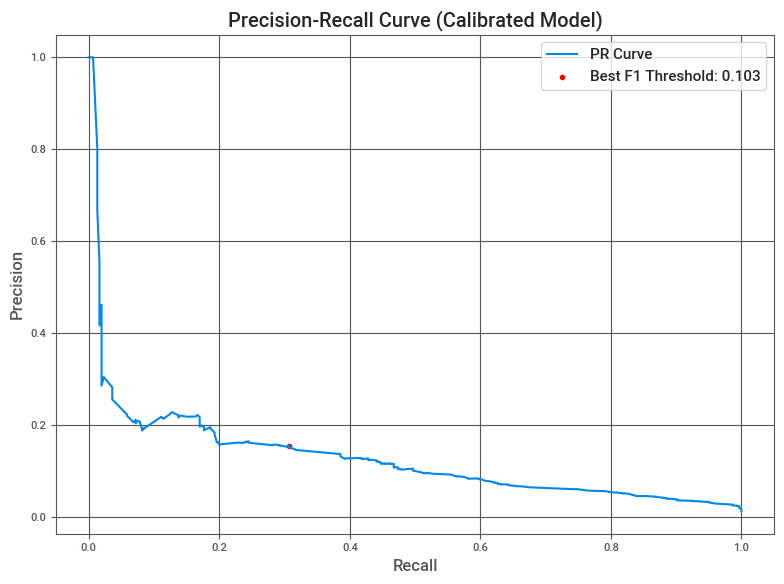

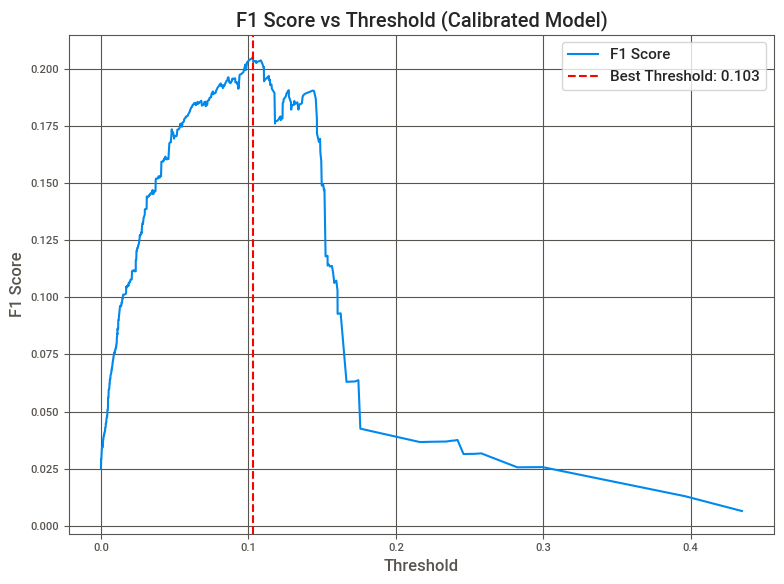

In [ ]:
# Compute precision, recall, thresholds for the calibrated model
precisions_cal, recalls_cal, thresholds_cal = precision_recall_curve(y, y_probs_calibrated)
f1s_cal = 2 * (precisions_cal[:-1] * recalls_cal[:-1]) / (precisions_cal[:-1] + recalls_cal[:-1] + 1e-6)

# Find best F1 index
best_idx_cal = f1s_cal.argmax()
best_threshold_cal = thresholds_cal[best_idx_cal]
best_f1_cal = f1s_cal[best_idx_cal]
best_precision_cal = precisions_cal[best_idx_cal]
best_recall_cal = recalls_cal[best_idx_cal]

# Plot Precision-Recall Curve with best threshold
plt.figure(figsize=(8, 6))
plt.plot(recalls_cal, precisions_cal, label="PR Curve")
plt.scatter(recalls_cal[best_idx_cal], precisions_cal[best_idx_cal], color="red", label=f"Best F1 Threshold: {best_threshold_cal:.3f}")
plt.title("Precision-Recall Curve (Calibrated Model)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot F1 Score vs Threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds_cal, f1s_cal, label="F1 Score")
plt.axvline(x=best_threshold_cal, color="red", linestyle="--", label=f"Best Threshold: {best_threshold_cal:.3f}")
plt.title("F1 Score vs Threshold (Calibrated Model)")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# Predictions from calibrated probabilities
y_preds = (y_probs_calibrated >= 0.103).astype(int)

# True labels
y_true = y  

# Print metrics
precision = precision_score(y_true, y_preds)
recall = recall_score(y_true, y_preds)
f1 = f1_score(y_true, y_preds)

print(f"Threshold = 0.103")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

Threshold = 0.103
Precision: 0.152
Recall: 0.304
F1 Score: 0.203


### Why we calibrated the Model
- Context

We are predicting mortgage propensity in a dataset with strong class imbalance (~1.3% positive class).

The model we use (CatBoost) is highly effective, but like most tree-based models, its predicted probabilities are not naturally well-calibrated.

Our goal is to rank customers accurately and define a threshold for targeting high-potential leads.

- Problem with the Uncalibrated Model

Overconfident scores: The model assigns extreme values (e.g., 0.97) even when uncertainty is high.

Misleading thresholds: The original best threshold was 0.969, suggesting only a tiny fraction of customers were mortgage candidates.

Hard to interpret: A score of 0.9 doesn’t really mean “90% chance” — it might be more like 10%.

- Why Calibration Helped

Improved interpretability: After calibration, a score of 0.10 means ~10% of those customers are actual mortgage takers.

More actionable threshold: The best F1 threshold dropped from 0.969 → 0.103, identifying more realistic and usable leads.

Better performance: Calibrated model achieved higher F1 score (0.20) and higher recall, with acceptable precision.

Business-aligned decision making: Enables targeting based on confidence ranges (e.g., “customers with ≥20% chance”).

- Visual Impact

Calibration curve showed alignment between predicted probabilities and actual outcome frequencies.

Precision-Recall and F1 vs. Threshold plots are smoother, more stable, and more informative.

- Takeaway
Calibrating the model helped us turn raw model outputs into meaningful, interpretable, and business-ready insights.
It made our scoring system both more accurate and more actionable.

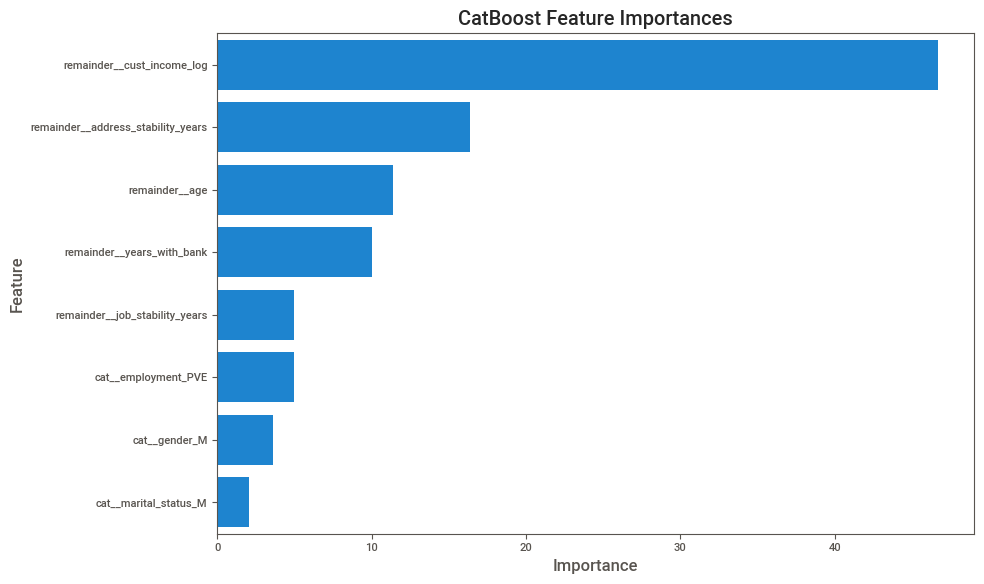

In [114]:
# Get and sort feature importances
importances = best_model.get_feature_importance()
sorted_idx = importances.argsort()[::-1] 

# Sort both values and labels
importances_sorted = importances[sorted_idx]
features_sorted = selected_features[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_sorted, y=features_sorted)
plt.title("CatBoost Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### Top features driving mortgage predictions:

- cust_income_log and address_stability_years are the strongest predictors.

- Followed by job_stability_years, age, and years_with_bank.

- Demographic features like gender_M, employment_PVE, and marital_status_M contribute less.

## 8. Model Interpretation using SHAP

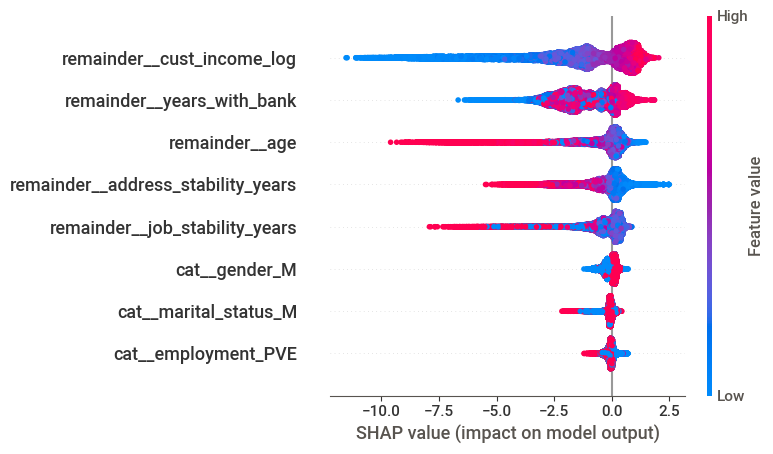

In [93]:
# Create SHAP explainer and values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_res)

# Summary plot (global importance)
shap.summary_plot(shap_values, X_res, feature_names=selected_features)

- **cust_income_log**: Higher income leads to higher mortgage probability (clearly red → positive SHAP).

- **address_stability_years**: Stable address contributes positively.

- **age and job_stability_years**: Moderate effect, with age showing both positive and negative SHAP contributions.

- Demographic features (**gender_M, employment_PVE, marital_status_M**) have limited but noticeable influence.

## 9. Final Predictions on Potential Customers

In [121]:
# Transform categorical features using the existing preprocessing pipeline
X_pot_transformed = pipeline.named_steps['preprocessing'].transform(potential_df[all_features])

# Select the same RFE-reduced feature subset
X_pot_selected = X_pot_transformed[:, selected_mask]

# Scale using the existing fitted scaler
X_pot_scaled = scaler.transform(X_pot_selected)

# Predict calibrated probabilities
pot_probs_calibrated = calibrated_model.predict_proba(X_pot_scaled)[:, 1]

# Apply the new calibrated threshold
calibrated_threshold = 0.103  # ← Best threshold from calibrated F1 curve
pot_preds_calibrated = (pot_probs_calibrated >= calibrated_threshold).astype(int)

# Attach to original dataframe
potential_df["mortgage_probability_calibrated"] = pot_probs_calibrated
potential_df["mortgage_prediction_calibrated"] = pot_preds_calibrated

# Sort by calibrated probability
potential_df_sorted = potential_df.sort_values("mortgage_probability_calibrated", ascending=False)

In [127]:
# Attach original ID
final_predictions = pd.DataFrame({
    "cocunut": potential_df["cocunut"],
    "mortgage_probability_calibrated": pot_probs_calibrated,
    "mortgage_prediction_calibrated": pot_preds_calibrated
}).sort_values("mortgage_probability_calibrated", ascending=False)

In [128]:
# Value counts of predictions
final_predictions.mortgage_prediction_calibrated.value_counts()

mortgage_prediction_calibrated
0    2691
1      56
Name: count, dtype: int64

In [129]:
# Filter potential_df for mortgage predictions
potential_df_sorted[potential_df_sorted["mortgage_prediction_calibrated"] == 1]

cocunut  age  years_with_bank marital_status education employment  \
851     80852   39               12              M       BCR        PVE   
1982    81983   44               13              S       BCR        PVE   
1596    81597   44                9              M       BCR        PVE   
2207    82208   37               13              M       HGH        PVE   
1015    81016   34                9              S       BCR        PVE   
91      80092   32               10              M       BCR        PVE   
2399    82400   51               15              D       HGH        PVE   
2692    82693   43               12              M       BCR        PVE   
2134    82135   42               13              M       MAS        PVE   
422     80423   34                9              M       BCR        PVE   
1408    81409   35               10              M       BCR        PVE   
2655    82656   45               13              M       BCR        PVE   
1377    81378   41               11              M       HGH        PVE   
1922    81923   46               14              M       BCR        PVE   
532     80533   46               15              M       BCR        STE   
1477    81478   40                9              S       BCR        PVE   
246     80247   34                6              M       HGH        PVE   
1252    81253   36               10              M       HGH        PVE   
2452    82453   31                5              S       BCR        PVE   
2242    82243   37                0              M       BCR        PVE   
2304    82305   44               14              M       HGH        PVE   
1543    81544   42               12              M       HGH        PVE   
490     80491   42               12              M       HGH        PVE   
1483    81484   34                7              M       OTH        STE   
1076    81077   28                7              S       BCR        PVE   
1708    81709   36                3              M       BCR        PVE   
1705    81706   37               11              M       HGH        PVE   
24      80025   37               11              M       HGH        PVE   
1438    81439   31                9              S       BCR        PVE   
2567    82568   42               11              M       BCR        PVE   
2251    82252   47               12              M       BCR        STE   
245     80246   36                6              S       BCR        PVE   
968     80969   35                2              M       BCR        PVE   
155     80156   37                3              M       MAS        PVE   
1136    81137   40               11              M       BCR        STE   
2604    82605   49               13              S       MAS        PVE   
1872    81873   54               15              M       HGH        STE   
2528    82529   38               14              M       BCR        PVE   
886     80887   45               12              M       HGH        PVE   
2033    82034   47               12              M       HGH        PVE   
1405    81406   42               12              M       BCR        PVE   
1696    81697   41               12              S       HGH        PVE   
1218    81219   41               14              S       BCR       MISC   
1865    81866   45               12              M       HGH        PVE   
269     80270   41               13              M       HGH       MISC   
358     80359   40               11              M       BCR        PVE   
1482    81483   39                9              M       BCR        PVE   
1141    81142   41               13              M       HGH       MISC   
1892    81893   39               11              M       MAS        PVE   
659     80660   32                9              D       HGH        PVE   
1532    81533   42                9              M       HGH        PVE   
1724    81725   42               13              M       BCR        PVE   
2137    82138   41             

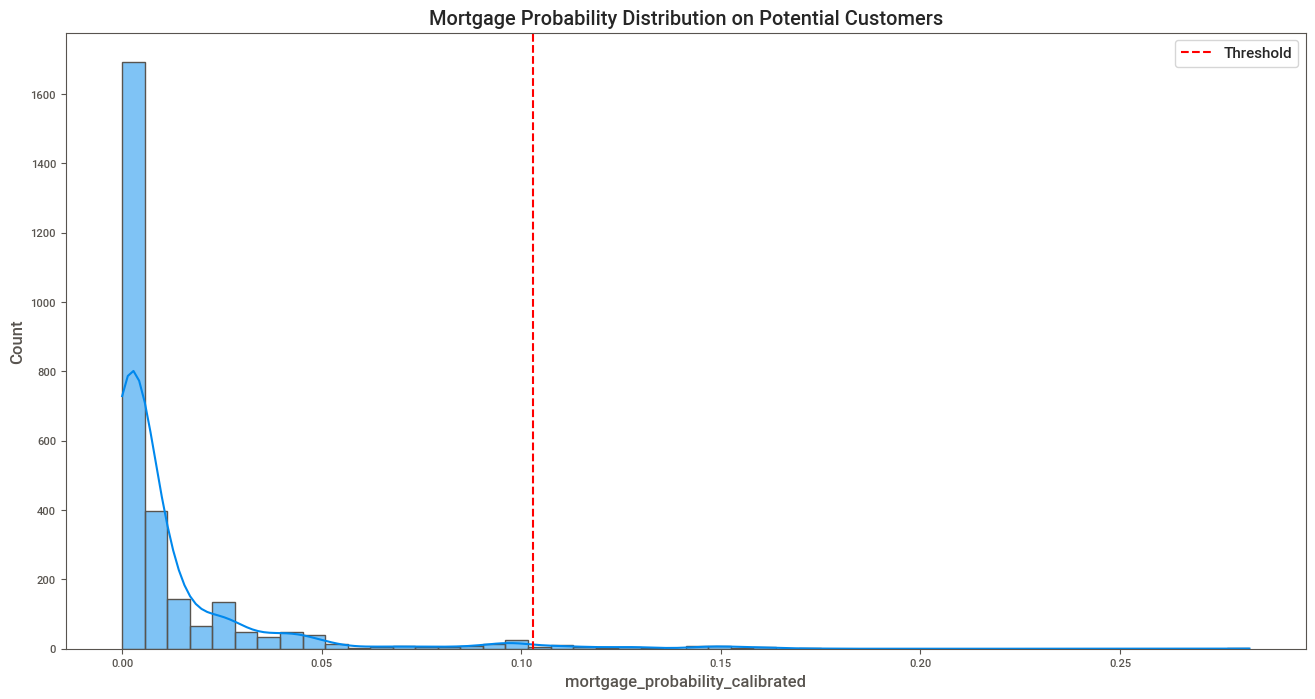

In [132]:
# Plot mortgage probability distribution
sns.histplot(potential_df["mortgage_probability_calibrated"], bins=50, kde=True)
plt.axvline(0.103, color="red", linestyle="--", label="Threshold")
plt.title("Mortgage Probability Distribution on Potential Customers")
plt.legend()
plt.show()

In [133]:
# Save the final predictions to CSV
potential_df_sorted.to_csv("../output/potential_df_scored.csv", index=False)

In [134]:
# Save the model using joblib
joblib_model_path = "../models/final_catboost_model.pkl"
joblib.dump(best_model, joblib_model_path)

['../models/final_catboost_model.pkl']